# Workshop 6: Cheminformatics

This notebook builds on our previous work performing machine learning by extending your knowledge to machine learning of chemistry.

This workshop will show you how to calculate and use molecular descriptors from SMILES codes for molecules, then will show you how to fit a machine learning model to predict molecular properties from them.

A few other new concepts will be introduced here:

- Hyperparameter tuning
- Model interpretation

This workshop uses RDKit - A toolkit for working with molecules in python: https://www.rdkit.org 

## There is an answer workbook provided in the github repository if you get stuck.

## Section 1: Working with RDKit

In [486]:
## We first need to install RDkit 
%pip install rdkit

In [5]:
import pandas as pd
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, DataStructs

In [6]:
# RDKit works by first defining a molecule object, then these can be used to calculate descriptors.

mol = Chem.MolFromSmiles("CCCC")

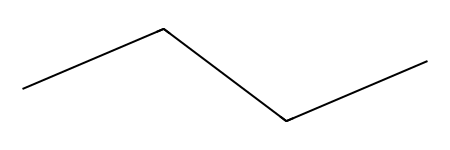

In [7]:
mol

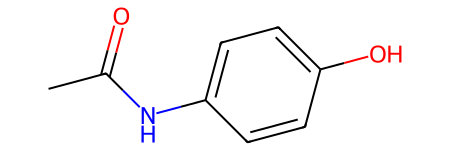

In [4]:
paracetamol = Chem.MolFromSmiles("CC(=O)Nc1ccc(cc1)O")

paracetamol

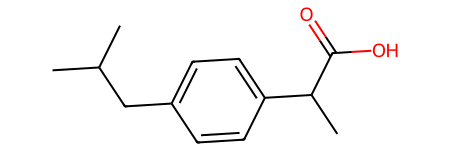

In [5]:
ibuprofen = Chem.MolFromSmiles("CC(Cc1ccc(cc1)C(C(=O)O)C)C")

ibuprofen

We can now calculate properties of these molecules using the Descriptors function

In [6]:
# Molecular weight of paracetamol
print(Descriptors.MolWt(paracetamol))

151.165


In [7]:
# LogP of paracetamol
print(Descriptors.MolLogP(paracetamol))

1.3505999999999998


In [8]:
# Total polar surface area (TPSA) of paracetamol
print(Descriptors.TPSA(paracetamol))

49.33


There is an excellent description of all the molecular descriptors available here:

https://github.com/milanimarcel/Descriptors-from-RDKit

There are over 200 descriptors like this available for a molecule, and the CalcMolDescriptors function can calculate them all at once for a molecule.

In [9]:
## Collecting all of the molecular descriptors for paracetamol
print(rdkit.Chem.Descriptors.CalcMolDescriptors(paracetamol))

{'MaxAbsEStateIndex': 10.524468537414966, 'MaxEStateIndex': 10.524468537414966, 'MinAbsEStateIndex': 0.11510204081632636, 'MinEStateIndex': -0.11510204081632636, 'qed': 0.5950261967780849, 'SPS': 9.181818181818182, 'MolWt': 151.165, 'HeavyAtomMolWt': 142.093, 'ExactMolWt': 151.063328528, 'NumValenceElectrons': 58, 'NumRadicalElectrons': 0, 'MaxPartialCharge': 0.22074743631242583, 'MinPartialCharge': -0.5079643157925783, 'MaxAbsPartialCharge': 0.5079643157925783, 'MinAbsPartialCharge': 0.22074743631242583, 'FpDensityMorgan1': 1.3636363636363635, 'FpDensityMorgan2': 1.9090909090909092, 'FpDensityMorgan3': 2.3636363636363638, 'BCUT2D_MWHI': 16.254688714379633, 'BCUT2D_MWLOW': 10.280190859964737, 'BCUT2D_CHGHI': 1.9280360590359853, 'BCUT2D_CHGLO': -1.9945540738765866, 'BCUT2D_LOGPHI': 2.125247579160176, 'BCUT2D_LOGPLOW': -2.0440113126102855, 'BCUT2D_MRHI': 5.88095478459792, 'BCUT2D_MRLOW': -0.11373578338266148, 'AvgIpc': 1.9291266251851134, 'BalabanJ': 2.7362980721056545, 'BertzCT': 253.29

# Section 1: Unsupervised machine learing of molecules

### We first calculate all the molecular descriptors for our molecules - we take each SMILE and:

- Convert it to an rdkit molecule
- Extract the molecular descriptors using the CalcMolDescriptors function

I have provided a function that can compute the descriptors for a smiles code below

### Hardcoded data (if using google colab)

In [12]:
# Define the data
data = {'Drug_ID': ['(-)-epicatechin', '(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -ynamide', 'codeine', 'creatinine', 'danazol', 'dexamethasone b D glucoside', 'dexamethasone b D glucuronide', 'DMXAA-G', 'd-praeruptorin', 'echinacoside', 'EF5154', 'EF5170', 'EF5232', 'EF5242', 'EF5248', 'EF5249', 'EF5251', 'EF5261', 'EF5264', 'EF5265', 'EF5270', 'EF5278', 'EF5283', 'EF5292', 'elarofiban', '5-chlorosalicylic acid', 'epinephrine', 'eriodictyol ', 'erythromycin', 'famotidine', 'fexofenadine', 'fexofenadine hydrochloride', 'fluparoxan', 'AACV', 'glycerol', 'glycine-valine acyclovir', 'guanabenz', 'hesperetin ', 'hexapeptide 01', 'hexapeptide 03', 'hexapeptide 05', 'hexapeptide 06', 'hexapeptide 07', 'hexapeptide 08', 'hexapeptide 09', 'aceclofenac', 'hexapeptide 12', 'hexapeptide 13', 'hexapeptide 14', 'hexapeptide 18', 'hexapeptide 20', 'acetaminophen', 'hexapeptide 22', 'hexapeptide 23', 'hexapeptide 24', 'hexapeptide 25', 'hexapeptide 26', 'hexapeptide 27', 'hexapeptide 28', 'hexapeptide 29', 'hexapeptide 32', 'hexapeptide 33', 'hexapeptide 34', 'hexapeptide 37', 'hexapeptide 38', 'hexapeptide 41', 'hexapeptide 42', 'hexapeptide 47', 'hexapeptide 48', 'hexapeptide 52', 'hexapeptide 53', 'hexapeptide 54', 'hexapeptide 55', 'hexapeptide 56', 'hexapeptide 57', 'hexapeptide 58', 'hexapeptide 59', 'hexapeptide 60', 'hydralazine', 'hydrocortisone', 'IACV', 'alminoprofen', 'imipramine', 'indomethacin', 'isoquercitrin ', 'ketoconazole', 'lamotrigine', 'lansoprazole', 'Liquiritin apioside ', 'lisinopril', 'loracarbef', 'amfenac sodium', 'LY366659', 'LY366799', 'LY366853', 'LY366856', 'meloxicam', 'methylscopolamine', 'metolazone', 'amoxicillin', 'nadalol', 'naproxen', 'naproxen sodium', 'naringenin', 'N-carbobenzoxy-tryptophan', 'N-desmethylclozapine', 'neolignan smi02', 'neolignan smi05', 'ampicillin', 'neolignan smi08', 'neolignan smi09', 'oxacillin', 'oxprenolol ester', 'PNU200001', 'PNU200647', 'PNU200648', 'PNU200969', 'pravastatin', 'prazosin', 'prednisolone', 'preladenant', 'propranolol ester', 'puerarin ', 'quinidine', 'raffinose', 'artesunate', 'rapamycin', 'SACV', 'scopolamine', 'serotonin', 'sildenafil', 'atropine', 'sulfadiazine', 'sulfasalazine', 'tenidap', 'tenoxicam', 'theophylline', 'tiotidine', 'tryptophan', 'tryptophanamide', 'ursolic acid', 'VACV', 'verapamil', 'benzoic acid', 'vinblastine', 'VLA-4 antagonist 2', 'VLA-4 antagonist 3', 'VLA-4 antagonist 4', 'VLA-4 antagonist 5', 'VLA-4 antagonist 6', 'benzylpenicillin', 'zidovudine', 'CA-DADLE', 'CA-Leu-Enk', 'camptothecin', 'carboxamido 28', 'cefazolin', 'ceftriaxone', 'cephalexin', 'cephalexin acetylated', 'CFPN-PI', 'cimetidine', 'clozapine', '2', '34', '31', '20', '7', '6', 'Amiloride', 'Cimetidine', 'Lef53', '15j', '15f', '65', '32', 'Lobucavir', 'Metoprolol', '9', '4b', '2n', '2k', '2i', '2m', '2e', '2h', '2o', '2l', '2d', '1', '49', '48', '1', '17', '5', '22', '36', '34', '23', 'S-6j', '659-Harmane', '795-Coptisine chloride (COP)', "877-(2S,4S,5R)-2-[(4'-Chlorophenyl)-4-methyl-1,3-dioxan-5-yl]amine (5h)", "878-(2S,4S,5R)-2-[(4'-Nitrophenyl)-4-methyl-1,3-dioxan-5-yl]amine (5i)", '879-(cis)-[2-(E-Phenylvinyl)-1,3-dioxan-5-yl]amine (6a)', '880-(2S,4S,5R)-[2-(E-Phenylvinyl)-4-methyl-1,3-dioxan-5-yl]amine (6b)', '881-13h', '883-(cis)-[2-(E-Phenylvinyl)-1,3-dioxan-5-yl]phenylacetamide (14a)', '884-14b', '1029-Dihydrotetrabenazine isomer', '228-Raffinose', '234-Cortisone', '677-Prednisolone', '679-Captopril (Cap)', '732-Amitriptyline', '801-Yohimbine (YOH)', '808-Asn-Ala-NH2', '1033-Dextromethorphan (DEM)', '014-Ampicillin', '016-Ceftibuten', '107-zidovudine', '150-Artesunate', '167-cephradine', '170-Grepafloxacin hydrochloride (GRX)', '174-Guanabenz', '205-Fluoxetine', '243-Famotidine', '247-Lobucavir', '263-Amrinone', '285-Ephedrine', '403-Atorvastatin', '453-(2E,4E,8Z,10Z)-N-Isobutyldodeca-2,4,8,10-tetraenamide (5) mw=247', '643-(2E,4E,8Z)-N-isobutyldodeca-2,4,8-trienamide (6) mw = 249', 'Acrivastine', 'Aminopyrine', 'Amitriptyline', 'Amphetamine sulfate', 'Ampicillin', 'Artesunate', 'Astemizole', 'Atorvastatin', 'Betaxolol', 'Bicalutamide', 'Bisoprolol', 'Bromazepam', 'Bupropion', 'Camazepam', 'Captopril (Cap)', 'Cefuroxime', 'Celecoxib', 'Cetirizine', 'Chloroquine', 'Chlorpheniramine', 'Chlorprothixene', 'Chlortetracycline', 'Chlorzoxazone', 'Clarithromycin', 'Clozapine', 'Codeine', 'Cycloserine', 'Danazol', 'Dextromethorphan', 'Diclofenac', 'Digoxin', 'Diltiazem', 'Efavirenz', 'Emetine', 'Enalaprilat', 'Exemestane', 'Ethionamide', 'Fluoxetine', 'Fluparoxan (GR50360A)', 'Flupenthixol', 'Fluvastatin', 'Gancyclovir', 'Glipizide', 'Glutaminic Acid', 'Grepafloxacin HCl', 'Guanabenz', 'Haloperidol', 'Imatinib', 'Indinavir', 'Isoxicam', 'Ketanserin', 'Labetalol', 'Lamivudine', 'Lisinopril', 'Lomefloxacin', 'Loperamide HCl', 'Lobucavir', 'Losartan', 'Lovastatin', 'Loxoprofen', 'Mebendazole', 'Meloxicam', 'Methylprednisolone', 'Metolazone', 'Nelfinavir', 'Netivudine (882C87)', 'Nicardipine', 'Nifedipine', 'Nisoldipine', 'Nitrendipine', 'Olopatadine', 'Ouabain', 'Oxaprozin', 'Pentoxifylline', 'Phenobarbital', 'Piroxicam', 'Pravastatin', 'Prazocin', 'Pranoprofen; pyranoprofen', 'Prednisolone', 'Promazine', 'Promethazine', 'Pyrimethamine', 'Quinidine', 'Raloxifene HCl', 'Remikiren (Ro 42-5892)', 'Reserpine', 'Rifampicin', 'Rofecoxib', 'Saquinavir', 'Simvastatin', 'Sorivudine (BVaraU)', 'Sparfloxacin (SPX)', 'Spironolactone', 'Stavudine (d4T)', 'Sulfamethizole', 'Sumatriptan', 'Tacrolimus', 'Tamoxifen', 'Tenidap', 'Thalidomide', 'Tinidazole', 'Trazodone', 'Triazolam', 'Valproic acid', 'Valsartan', 'Yohimbine (YOH)', 'Zolpidem', 'Zomepirac', 'Flavone', 'Gly-Pro (glycylproline)', 'Phencyclidine (PCP)', 'DMP 851', 'N-Acetyl-D-alanyl-D-phenylalanine N-Methylamide (2)', 'N-Acetyl-D-valyl-D-phenylalanine N-Methylamide (3a)', 'N-Acetyl-D-phenylalanyl-D-phenylalanine N-Methylamide (5a)', 'N-Acetyl-D-cyclohexylalanyl-D-phenylalanine N-Methylamide (6)', 'N-Acetyl-D-alanine Phenethylamide (8)', 'N-Acetyl-D-leucine Phenethylamide (10)', 'N-Acetyl-D-phenylalanine Phenethylamide (11a)', 'N-Acetyl-D-cyclohexylalanine Phenethylamide (12)', '1', '2', '3', '4', '6', '7', '8', '9', '13', '16', 'Alprenolol ester', 'Betaxolol ester', 'Oxprenolol ester', 'Sulfasalazine', 'V', 'VIII', 'XI', 'XIV', 'DB75 [2,5-bis(4-amidinophenyl)furan]', 'Gomisin A', 'Epinephrine', 'Fleroxacin', 'Ceftriaxone', 'Penicillin G', 'BVaraU', 'Glutamine', 'LY334370', 'Dexamethasone-?-D-glucoside', 'Lactulose', 'PNU 200603', 'L-alanine', 'Tiotidine', 'Glycylsarcosine', 'MEN15596', '9-Nitrocamptothecin (9-NC)', 'H 95/71', 'H 244/45', 'Oxacillin', 'Cyclo(-PFwKTF-) (1)', 'Cyclo(-PFwKTMeF-) (3)', 'Cyclo(-PFMewKTF-) (4)', 'Cyclo(-PFMewMeKTF-) (6)', 'Ac-D-phe-NH2', 'Ac-D-phe2-NH2', 'Ac-D-phe2-(NMe-D-phe)-NH2', 'Ac-D-phe-(NMe-D-phe)2-NH2 {[14C]-Acf(N-Mef)2NH2 }', 'Ac-(NMe-D-phe)3-NH2', 'Ac-(NMe-D-phe)3-NHMe', 'BMS 189664', 'PNU200969', 'PNU-93936A', 'PNU-100766', 'PNU-184435', 'PNU-184249', 'PNU-184148', 'PNU-184147', 'PNU-184421', 'PNU-184470', 'PNU-179962', 'PNU-179399', 'NK1NK2 analogue 105 (MDL 105,212)', 'NK1NK2 analogue 212 (15d)', '366094', 'EI analogue 101 (MDL 101,146)', '354400', 'EI analogue 102 (MDL 102,111)', '368177', 'Thiamin (Vitamin B1)', '6MAQH (W2)', 'Bicyclol', "5'-L-phenylalanyl-floxuridine", "5'-L-isoleucyl-floxuridine", "5'-L-valyl-L-phenylalanyl-floxuridine", "5'-L-leucyl-L-glycyl-floxuridine", 'Tanshinol (TSL)', 'Salvianolic acid A (SAA)', 'Salvianolic acid D (SAD)', 'Lithospermic acid (LSA)', '14', 'Epimedin A', 'Epimedin B', 'Icariin', 'Baohuoside I', 'Umbelliferone', 'Angelol-A', 'Angelol-B', '8-Hydroxy-pentadeca-(9E,13Z)-dien-11-yn-2-one (2)', 'Pentadeca-(8Z,13Z)dien-11-yn-2-one (5)', 'Tetradec-(8Z)-ene-11,13-diyn-2-one (6)', 'SB639', 'PB-26', 'PB-27', 'PB-104', 'MEN14268', 'MEN14732', 'MEN14745', 'MEN15353', 'MEN15366', 'MEN15716', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', "4'-Cl BZT", "3',4''-diCl BZT", '7-MF', '5,7-DMF', "5,7,4'-TMF", "7,4'-DHF", 'Chrysin (5,7-DHF)', "Apigenin (5,7,4'-THF)", '12d', '12q', 'Biotin-Saquinavir', 'G6191', 'G6262', 'G6264', 'XP13512', '20(S)-camptothecin (CPT)', '353462', '366853', 'CPU-86017', 'Harmol', 'CF 1525 (p-Me)', 'CF 1523 (p-Cl)', 'CF 1517 (p-Br)', 'CF 1572 (p-I)', 'Roxithromycin', '2-Amino-1-methyl-6-phenylimidazo-[4,5-b]pyridine (PhIP)', '8', '10', '11', '12', '14', '15', '16', '14c', '21c', '25a', '25f', '48d', '48e', '20E 22-ethyl ether (5)', '20E 22-allyl ether (7)', '20E 25-methyl ether (10)', 'PoA 22-methyl ether (18)', '20-Hydroxyecdysone (25)', 'Muristerone A (28)', '(E)-4-(3,4-dimethoxyphenyl)but-3-en-1-yl linoleate (1)', '(E)-4-(3,4-dimethoxyphenyl)but-3-en-1-yl oleate (2)', 'Compound D', 'Rutaecarpine (RCP)', 'Evodiamine (EDM)', 'YH439', 'Choline', 'Cerulenin', 'Rebaudioside A', 'D-Phe-D-Ala-D-Ser-OH', "Dimethyl-4',4'-dimethoxy-5,6,5',6'-dimethylene dioxybiphenyl-2,2'-dicarboxylate (DDB)", 'Carbendazim', 'Dexloxiglumide', 'Lys-FITC-OCH3', 'Neostenine', 'Decursinol angelate (DA)', 'Imidacloprid (IMI)', 'Laudanosine (LAU)', 'Cepharanthine (CEP)', 'Corynanthine (COR)', 'Ac-Trp-Ala-Gly-Gly-Asp-Ala-NH2', 'Ac-Gly-Asn-Ala-NH2', 'Ac-Gly-Lys-Ala-NH2', 'cyclo[Trp-Ala-Gly-Gly-Asp-Ala]', 'Strychnine (Str)', 'Brucine (Bru)', 'Brucine N-oxide (B-N)', 'Pseudostrychnine (Psd)', 'Bilirubin', 'Bilirubin ditaurate', 'Biliverdin', '16', '32b', 'TMC435350 (32c)', '32f', '32g', '32h', 'DXG (9)', 'Isovitexin (10)', 'DG (13)', 'Kaempferol (16)', 'Tamarixetin (17)', 'Quercitrin (21)', 'Isoquercitrin (22)', 'IRR (23)', 'Eriodictyol (28)', 'Puerarin (34)', 'Isoliquiritigenin (35)', '(-)-Epicatechin (36)', '7d', '9', '10c', '10d', '11b', '11c', '11e', '12c', '12d', '3-[5-(4-hydroxyphenyl)-1,3-oxazol-2-yl]phenol (18)', 'N-(4-Chlorophenyl)-1-(2-(pyridin-4-yl)ethyl)-1H-pyrazole-5-carboxamide (11)', '19', '20', 'N-(4-(Chlorodifluoromethoxy)phenyl)-1-(2-(pyridin-4-yl)ethyl)-1H-pyrazole-5-carboxamide (22)', 'N-(4-tert-Butylphenyl)-1-(2-(pyridin-4-yl)ethyl)-1H-pyrazole-5-carboxamide (23)', '24', '1', '18 (5R,S)', '4-(Pyridin-4-ylmethylamino)-N-(3-(trifluoromethyl)phenyl)isothiazole-3-carboxamide (3)', '9', 'N-(3-tertbutylphenyl)-4-(pyridin-4-ylmethylamino)isothiazole-3-carboxamide (11)', '14', '22', '4-(quinolin-4-ylmethylamino)-N-(3-(trifluoromethyl)phenyl)isothiazole-3-carboxamide (30)', '6', '6b', '22', '24', '25', '26', '28', '30', '32', '34', '35', '36', '17d', 'KAR-2', '11-keto-beta-boswellic acid (KBA)', 'Bis(7)-tacrine (B7T)', '1', '3', "Quercetin 3,4'-diglucoside", 'D-Glu(OBzl)-Ala', 'D-Ser(Bzl)-Ala', 'Glycocholate', 'F-(S)-IZD', 'Cyclo(-PFMewKTMeF-) (7)', 'M1', 'Epigallocatechin (EGC)', 'Fluorescein', 'DB377 (4)', 'NS5B inhibitor 2', 'Deoxynivalenol (DON)', 'Putrescine', 'Met-enkephalin', '[D-Ala2]Met-enkephalin', 'Metkephamid', 'Oxazolidin-2-one (OXa)', 'OXb', 'OXc', 'OXd', 'OXe', 'OXf', 'OXh', 'OXo', 'OXn', 'Ac-Trp-Ala-Gly-Gly-Lys-Ala-NH2', 'Cytarabine (1)', "5'-L-valyl-cytarabine (2)", 'XM970', 'E15', 'E17', 'E23', 'E24', 'E25', 'E28', 'Naringin', 'N-desmethylclozapine', '13', '14', 'VX-950', 'BILN-2061', '2c', '4b', '4c', '4f', '4g', '4h', '4c', '1-naphthol', 'V', 'a', 'b', 'C', 'I-II', "5'-L-Val-FUdR", "5'-L-Leu-FUdR", 'Methylparaben', 'Propylparaben', 'Butylparaben', 'Octylparaben', 'Arzanol', '2', '4', '6', 'Pyrilamine Maleate', 'Org 12962', 'Org 5222', 'Org 33062', 'Org 25907', 'Org 13011', 'Org 34037', 'Org 23366', 'Org 34167', '21d', '2', '21e', 'Teniposide', '22', '25', '5m', '1', '13', '13d', '13e', '13g', '13i', '13j', '(E-Z)-19a', '(Z)-19b', '(Z)-19c', '(Z)-19d', '(Z)-19e', '(Z)-19g', 'T2000', 'T2007', 'Cycloastragenol', 'Byankangelicol', 'CD1', 'CD21', 'CD27', 'Zearalenone (ZEN)', 'a-Zearalenol (a-ZEL)', 'a-Zearalanol (a-ZAL)', 'Telaprevir', 'Tryptanthrin', '6', '8', '10', '11', '25', '45a', '45b', '45c', '51a', '51e', '60a', '60c', '67c', 'Amfenac', 'Levofloxacin', 'Paraoxon', 'Sulfasalamide', 'Amlodipine', 'Alfuzosin', 'Dronedarone', 'Trimethobenzamide', 'Desloratadine', 'Xaliproden (SR57746)', 'Setrobuvir (ANA598)', 'corticosterone', 'cymarin', 'daidzin ', 'desoxycarticosterone', '(2E,9Z)-N-(2-methylbutyl)pentadeca-2,9-diene-12,14-diynamide', 'EACV', '5-aminolevulinic acid', 'EF5289', 'enalapril', 'ganciclovir', 'hexapeptide 04', 'hexapeptide 15', 'hexapeptide 16', 'hexapeptide 19', 'hexapeptide 43', 'hexapeptide 51', 'indobufen', 'IRR ', 'isovitexin ', 'kaempferide ', 'LEF553', 'LY366092', 'methanol', 'N-acetyl-tryptophanamide', 'neolignan smi06', 'neolignan smi07', 'neolignan smi10', 'nitrendipine', 'omeprazole', 'ouabain', 'PNU200603', 'quercitrin ', 'saquinavir', 'SB209670', 'SDZ-RAD', 'sulfamethoxazole', 'betazolol', 'betazolol ester', 'caffeine', '4', '74', 'Verapamil', '2j', '2f', '2g', '31', '943-Ketotifen fumarate (38)', '882-13i', '061-Amiloride', '187-Saquinavir', 'Acyclovir', 'Atropine', 'Bendroflumethiazide', 'Cisapride', 'Cymarin', 'Diphenhydramine', 'Erlotinib', 'Furazolidone', 'Gefitinib', 'Ketoconazole', 'Ketotifen', 'Methadone', 'Methyldopa', 'Scopolamine', 'Talinolol', 'Terfenadine', 'Viloxazine', 'Maraviroc (UK-427,857)', 'Rhodamine 123 (Rho 123)', 'N-Acetyl-D-leucyl-D-phenylalanine N-Methylamide (4)', 'N-Acetylglycine Phenethylamide (7)', 'N-Acetyl-D-valine Phenethylamide (9a)', '10', 'Corticosterone', 'Sucrose', 'Doxorubicin', 'Propranolol ester', 'Proscillaridin', 'Dexamethasone-?-D-glucuronide', 'U-84656 (IV)', 'Ac-D-phe3-NH2', 'PNU200648', 'PNU200681', 'PNU-179450', 'PNU-182347', 'PNU-179397', 'PNU-182945', 'PNU-241028', 'NK1NK2 analogue 104 (15f)', '341908', 'UK 224,671', "5'-L-glycyl-L-leucyl-floxuridine", 'N-[5-[(4-Dimethylaminobenzoyl)amino]pentyl]-2-mercaptoacetamide (S2)', 'Vorinostat (SAHA-suberoylanilide hydroxamic acid)', '2', '11', '13', 'Sulfanilic acid', 'PB-43', 'PB-102', 'MEN14970', '-', '-', '-', '-', "3'-Cl BZT", "7,4'-DMF", '12g', '(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -ynamide (4) mw = 245', "2',3'-dideoxyinosine (ddI)", 'Val-ACV', 'CF 1526 (p-OMe)', 'S-nitrosylated captopril (CapNO)', '13', 'ME3229', '10b', '25c', '25e', '30d', '21b', '20E 22-methyl ether (4)', 'PoA 2-methyl ether (16)', 'PoA 3.22-dimethyl ether (20)', 'Ponasterone A (26)', 'Ergonovine', 'Folinic acid', 'Liquiritigenin (LG)', 'Ginsenoside Rg1 (Rg1)', 'Berberrubine (BRB)', 'Ajmalicine (AMC)', 'Ajmaline (AML)', 'Beta-colubrine (Col)', 'Icajine (Ica)', 'Pyr-His-Pro-NH2 (TRH)', 'Taxifolin (29)', '11d', '11f', 'C', 'D', '32', '3', '21', '23', '27', '29', '31', '3', 'L1 (1,2-dimethyl-3 hydroxypyridin-4-one)', 'Me-(S)-IZD', 'Acrylamide', 'Dihydrotetrabenazine isomer A', 'Ethylparaben', "5'-L-phenylalanyl-cytarabine (5)", 'Astilbin', 'Methyl gallate', 'Ketamine', '12', 'S1', 'S2', '4d', 'II', "3'-L-Ile-FUdR", "5'-L-Asp-FUdR", 'Acetyl-Trp-Ala-Gly-Gly-Asn-Ala-Amide', 'Daunorubicin', 'PDE-310', 'Cerivastatin', '23', '24', '5d', '13c', '13h', '(Z)-19f', 'MMMDPB', 'Ac-C8-Enk-NH (3)', 'Rivulobirin A', 'Capric acid (decanoic acid)', 'Apometzgerin (2)', '3', '51d', 'Cycloheximide'], 'Drug_SMILES': ['Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2', 'C/C=C\\C#CCC/C=C\\C=C\\C(=O)NCC(C)C', 'COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2)N(C)CC[C@]314', 'CN1CC(=O)NC1=N', 'C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(C)[C@H]3CC[C@@]21C', 'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)CO[C@H]1O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]1O', 'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)CO[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O', 'Cc1ccc2c(=O)c3cccc(CC(=O)OC4OC(C(=O)O)[C@@H](O)[C@@H](O)[C@@H]4O)c3oc2c1C', 'C/C=C(\\C)C(=O)O[C@H]1[C@@H](OC(C)=O)c2c(ccc3ccc(=O)oc23)OC1(C)C', 'C[C@@H]1O[C@@H](O[C@@H]2[C@@H](O)[C@H](OCCc3ccc(O)c(O)c3)O[C@H](CO[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@H]2OC(=O)/C=C/c2ccc(O)c(O)c2)[C@H](O)[C@H](O)[C@H]1O', 'O=C(O)COc1ccc(C(=O)CN2CCN(C3CCNCC3)CC2=O)cc1', 'CCCCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCNCC3)CC2=O)cc1', 'CCCCC(C)OC(=O)COc1ccc(C(=O)CN2CCN(C3CCNCC3)CC2=O)cc1', 'CCCCCCC(C)OC(=O)COc1ccc(C(=O)CN2CCN(C3CCNCC3)CC2=O)cc1', 'CCCCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OCc4oc(=O)oc4C)CC3)CC2=O)cc1', 'Cc1oc(=O)oc1COC(=O)N1CCC(N2CCN(CC(=O)c3ccc(OCC(=O)OC4CCCCC4)cc3)C(=O)C2)CC1', 'CCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC(C)OC(C)=O)CC3)CC2=O)cc1', 'O=C(COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC/C=C4/OC(=O)c5ccccc54)CC3)CC2=O)cc1)OC1CCCCC1', 'CC(=O)OC(C)OC(=O)N1CCC(N2CCN(CC(=O)c3ccc(OCC(=O)OC4CCOCC4)cc3)C(=O)C2)CC1', 'CCOCC(COCC)OC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC(C)OC(C)=O)CC3)CC2=O)cc1', 'CCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC(OC(C)=O)C(C)(C)C)CC3)CC2=O)cc1', 'CCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC(OC(=O)C(C)(C)C)C(C)(C)C)CC3)CC2=O)cc1', 'CCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC(C)OC(=O)C(C)(C)C)CC3)CC2=O)cc1', 'CC(C)(C)C(=O)OCOC(=O)N1CCC(N2CCN(CC(=O)c3ccc(OCC(=O)OC4CCCCC4)cc3)C(=O)C2)CC1', 'O=C(O)C[C@H](NC(=O)[C@@H]1CCCN(C(=O)CCC2CCNCC2)C1)c1cccnc1', 'O=C(O)c1cc(Cl)ccc1O', 'CNC[C@H](O)c1ccc(O)c(O)c1', 'O=C1C[C@@H](c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21', 'CC[C@@H]1OC(=O)[C@@H](C)[C@H](O[C@H]2C[C@](C)(OC)[C@@H](O)[C@H](C)O2)[C@@H](C)[C@@H](O[C@H]2O[C@H](C)C[C@@H](N(C)C)[C@H]2O)[C@@](C)(O)C[C@@H](C)C(=O)[C@H](C)[C@@H](O)[C@@]1(C)O', 'NC(N)=Nc1nc(CSCCC(N)=NS(N)(=O)=O)cs1', 'CC(C)(C(=O)O)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1', 'CC(C)(C(=O)O)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1.Cl', 'Fc1cccc2c1O[C@H]1CNC[C@@H]1O2', 'C=C1NC(N)=Nc2c1ncn2COCCOC(=O)[C@@H](C)N', 'OCC(O)CO', 'CC(=O)C(NC(=O)CN)c1ccc(O)cc1', 'NC(N)=N/N=C/c1c(Cl)cccc1Cl', 'COc1ccc([C@@H]2CC(=O)c3c(O)cc(O)cc3O2)cc1O', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'CC(=O)Nc1ccc(O)cc1', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@H]1C(=O)N[C@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N1C', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C1=O', 'C[C@H]1C(=O)N(C)[C@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N1C', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C1=O', 'C[C@H]1C(=O)N(C)[C@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N(C)[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N1C', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C1=O', 'C[C@H]1C(=O)N(C)[C@H](C)C(=O)N(C)[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N1C', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C1=O', 'C[C@H]1C(=O)N[C@H](C)C(=O)N(C)[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N(C)[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N1C', 'NNc1nncc2ccccc12', 'C[C@]12C[C@@H](O)[C@@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@H]1CC[C@@]2(O)C(=O)CO', 'C=C1NC(N)=Nc2c1ncn2COCCOC(=O)[C@H](N)[C@H](C)CC', 'C=C(C)CNc1ccc(C(C)C(=O)O)cc1', 'CN(C)CCCN1c2ccccc2CCc2ccccc21', 'COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1', 'O=c1c(OC2C(O)OC(CO)C(O)C2O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12', 'CC(=O)N1CCN(c2ccc(OC[C@H]3CO[C@](Cn4ccnc4)(c4ccc(Cl)cc4Cl)O3)cc2)CC1', 'Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1', 'Cc1c(OCC(F)(F)F)ccnc1CS(=O)c1nc2ccccc2[nH]1', 'O=c1cc(-c2ccc(O)cc2)oc2cc(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O[C@@H]3OC[C@](O)(CO)[C@H]3O)cc(O)c12', 'NCCCC[C@H](N[C@@H](CCc1ccccc1)C(=O)O)C(=O)N1CCC[C@H]1C(=O)O', 'N[C@@H](C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(Cl)CC[C@H]12)c1ccccc1.O', 'Nc1c(CC(=O)[O-])cccc1C(=O)c1ccccc1.O.[Na+]', 'CC(C)S(=O)(=O)n1c(N)nc2ccc(/C(=C/C(N)=O)c3c(F)c(F)cc(F)c3F)cc21', 'CC(C)S(=O)(=O)n1c(N)nc2ccc(/C(=C/C(N)=O)c3ccccc3F)cc21', 'C.CC(C)n1c(N)nc2ccc(/C(=C/C(N)=O)c3cccc(F)c3F)cc21', 'CC(C)S(=O)(=O)n1c(N)nc2ccc(/C(=C/C(N)=O)c3ccc(F)c(F)c3F)cc21', 'Cc1cnc(NC(=O)C2=C(O)c3ccccc3S(=O)(=O)N2C)s1', 'C[N+]1(C)[C@H]2CC(OC(=O)[C@H](CO)c3ccccc3)C[C@H]1C1OC12.[Br-]', 'Cc1ccccc1N1C(=O)c2cc(S(N)(=O)=O)c(Cl)cc2NC1C', 'CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)C(=O)N2[C@H]1C(=O)O', 'CC(C)(C)NCC(O)COc1cccc2c1CC(O)C(O)C2', 'COc1ccc2cc([C@H](C)C(=O)O)ccc2c1', 'COc1ccc2cc(C(C)C(=O)[O-])ccc2c1.[Na+]', 'O=C1C[C@@H](c2ccc(O)cc2)Oc2cc(O)cc(O)c21', 'O=C(NC(Cc1c[nH]c2ccccc12)C(=O)O)OCc1ccccc1', 'Clc1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2', 'C/C=C/c1cc(OC)c2c(c1)C(C)C(c1cc(OC)c(O)c(OC)c1)O2', 'C=CCc1cc(OC)c(OC(C)Cc2cc(OC)c(OC)c(OC)c2)c(OC)c1', 'CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=O)N2[C@H]1C(=O)O', 'C=CCc1cc(OC)c(OC(C)C(O)c2cc(OC)c(OC)c(OC)c2)c(OC)c1', 'C=CCc1cc(OC)c(OC(C)C(O)c2ccc(O)c(OC)c2)c(OC)c1', 'Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12', 'C=CCOc1ccccc1OC[C@@H](CNC(C)C)OC(=O)C1CC1', 'N=C(N)c1ccc2[nH]c(Cc3nc4ccccc4[nH]3)nc2c1', 'N/C(=N/O)c1ccc2[nH]c(-c3ccccn3)nc2c1', 'Cc1ccnc2nc(Cc3nc4cc(C(=N)N)ccc4[nH]3)[nH]c12', 'CCOC(=O)NC(=N)c1ccc2[nH]c(Cc3nc4ccccc4[nH]3)nc2c1', 'CC[C@H](C)C(=O)O[C@H]1C[C@H](O)C=C2C=C[C@H](C)[C@H](CC[C@@H](O)C[C@@H](O)CC(=O)O)[C@H]21', 'COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC', 'C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO', 'COCCOc1ccc(N2CCN(CCn3ncc4c3nc(N)n3nc(-c5ccco5)nc43)CC2)cc1', 'CC(C)NC[C@H](COc1cccc2ccccc12)OC(=O)C1CC1', 'O=c1c(-c2ccc(O)cc2)coc2c([C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)c(O)ccc12', 'C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2ccc(OC)cc12', 'OC[C@H]1O[C@@](CO)(O[C@H]2O[C@H](CO[C@H]3O[C@H](CO)[C@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](O)[C@@H]1O', 'C[C@@H]1CC[C@H]2[C@@H](C)[C@H](OC(=O)CCC(=O)O)O[C@@H]3O[C@@]4(C)CC[C@@H]1[C@@]23OO4', 'CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(=O)N2CCCC[C@H]2C(=O)O[C@H]([C@H](C)C[C@@H]2CC[C@@H](O)[C@H](OC)C2)CC(=O)[C@H](C)/C=C(\\C)[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)/C=C/C=C/C=C/1C', 'C=C1NC(N)=Nc2c1ncn2COCCOC(=O)[C@H](N)CO', 'CN1[C@H]2CC(OC(=O)[C@H](CO)c3ccccc3)C[C@@H]1[C@H]1O[C@@H]21', 'NCCc1c[nH]c2ccc(O)cc12', 'CCCc1nn(C)c2c(=O)nc(-c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3OCC)[nH]c12', 'CN1[C@H]2CC[C@@H]1CC(OC(=O)C(CO)c1ccccc1)C2', 'Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1', 'O=C(O)c1cc(/N=N/c2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O', 'NC(=O)N1C(=O)C(C(=O)c2cccs2)c2cc(Cl)ccc21', 'COc1cc2nc(N3CCN(C(=O)C4CCCO4)CC3)nc(N)c2cc1OC', 'Cn1c(=O)c2[nH]cnc2n(C)c1=O', 'C/N=C(\\NC#N)NCCSCc1csc(N=C(N)N)n1', 'NC(Cc1c[nH]c2ccccc12)C(=O)O', 'NC(=O)C(N)Cc1c[nH]c2ccccc12', 'C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CC[C@H](O)C(C)(C)[C@@H]5CC[C@@]4(C)[C@]3(C)CC[C@@]2(C(=O)O)CC[C@H]1C', 'C=C1NC(N)=Nc2c1ncn2COCCOC(=O)[C@H](N)C(C)C', 'COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC', 'O=C(O)c1ccccc1', 'CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1', 'CCOC(=O)[C@H](Cc1ccc(OC(=O)N(C)C)cc1)NC(=O)[C@H]1N(S(=O)(=O)c2cnn(C)c2)CSC1(C)C', 'CC(C)OC(=O)[C@H](Cc1ccc(OC(=O)N(C)C)cc1)NC(=O)[C@H]1N(S(=O)(=O)c2cnn(C)c2)CSC1(C)C', 'CN(C)C(=O)Oc1ccc(C[C@H](NC(=O)[C@H]2N(S(=O)(=O)c3cnn(C)c3)CSC2(C)C)C(=O)OCC(C)(C)C)cc1', 'CN(C)C(=O)Oc1ccc(C[C@H](NC(=O)[C@H]2N(S(=O)(=O)c3cnn(C)c3)CSC2(C)C)C(=O)OCOC(=O)C(C)(C)C)cc1', 'COCCOCCOC(=O)[C@H](Cc1ccc(OC(=O)N(C)C)cc1)NC(=O)[C@H]1N(S(=O)(=O)c2cnn(C)c2)CSC1(C)C', 'CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O', 'Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(=O)[nH]c1=O', 'CC(C)C[C@H]1NC(=O)[C@@H](Cc2ccccc2)NC(=O)CNC(=O)[C@@H](C)NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)/C=C\\c2ccccc2OC1=O', 'CC(C)C[C@H]1NC(=O)[C@@H](CC2CCCCC2)NC(=O)CNC(=O)[C@@H](C)NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)/C=C\\c2ccccc2OC1=O', 'CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1', 'CC(C)(C)CC(=O)Nc1c(F)cc(C(=O)Nc2nccs2)cc1F', 'Cc1nnc(SCC2=C(C(=O)O)N3C(=O)[C@@H](NC(=O)Cn4cnnn4)[C@H]3SC2)s1', 'CO/N=C(\\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc(=O)c(=O)[nH]n3C)CS[C@H]12)c1csc(N)n1', 'CC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccccc3)C2SC1', 'CC(=O)NC(C(=O)NC1C(=O)N2C(C(=O)O)=C(C)CSC12)c1ccccc1', 'CC/C=C(\\C(=O)N[C@@H]1C(=O)N2C(C(=O)OCOC(=O)C(C)(C)C)=C(COC(N)=O)CS[C@H]12)c1csc(N)n1.Cl.O', 'C/N=C(\\NC#N)NCCSCc1[nH]cnc1C', 'CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1', 'CN(C(=O)[C@H](Cc1ccc(C(=N)N)cc1)NS(=O)(=O)c1ccc2ccccc2c1)C1CCCC1', 'NCc1cccc(Cc2ncccn2)c1', 'NC(=O)c1cccc(Cc2ncccn2)c1', 'N#Cc1cccc(Cc2ncccn2)c1', 'CNS(=O)(=O)c1ccc(Cl)cc1', 'NS(=O)(=O)c1ccc(Cl)cc1', 'N=C(N)NC(=O)c1nc(Cl)c(N)nc1N', 'CN/C(=N\\CCSCc1nc[nH]c1C)NC#N', 'NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@@H](N)Cc1ccc(O)cc1', 'COc1cccc(-n2c(=O)n(Cc3c(F)cccc3Br)c(=O)n(C[C@H](N)c3ccccc3)c2=O)c1F', 'COc1cccc(-n2c(=O)n(Cc3ccccc3C#N)c(=O)n(C[C@H](N)c3ccccc3)c2=O)c1F', 'CC(=O)c1sc(NC(=O)N[C@@H]2CCCC[C@H]2CN2CCC[C@@H](Cc3ccc(F)cc3)C2)nc1C', 'CC(=O)c1cccc(NC(=O)N[C@@H]2CCCC[C@H]2CN2CCC[C@@H](Cc3ccc(F)cc3)C2)c1', 'Nc1nc(O)c2ncn([C@@H]3C[C@H](CO)[C@H]3CO)c2n1', 'COCCc1ccc(OCC(O)CNC(C)C)cc1', 'CC(C)CNC(=O)[C@H](C)NC[C@H](Cc1ccccc1)NC(=O)c1cc(CCC2C[C@@H]2C)cc(N(C)S(C)(=O)=O)c1', 'CC(C)CNC(=O)[C@H](C)NC[C@H](Cc1ccccc1)NC(=O)c1cc(C(=O)N[C@H](C)c2ccc(F)cc2)cc(N(C)S(C)(=O)=O)c1', 'CCOC(=O)c1c(Cl)cccc1-c1cnc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'C[C@@H](NC(=O)C1(NC(=O)C(F)(F)F)CC1)c1ccc(-c2cc(Cl)cc(F)c2-c2nnn(C)n2)cc1F', 'Cc1nc(-c2c(Cl)cc(Cl)cc2-c2ccc([C@@H](C)NC(=O)C3(NC(=O)C(F)(F)F)CC3)c(F)c2)no1', 'COC(=O)c1c(Cl)cc(Cl)cc1-c1cnc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'C[C@@H](NC(=O)C1(NC(=O)C(F)(F)F)CC1)c1ccc(-c2cc(Cl)ccc2-c2nnn(C)n2)cc1F', 'CCOC(=O)c1c(Cl)cc(Cl)cc1-c1ccc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'CCOC(=O)c1c(Cl)cc(Cl)cc1-c1cnc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'COC(=O)c1c(Cl)cccc1-c1cnc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'Cc1nc(-c2ccc(Cl)cc2-c2ccc([C@@H](C)NC(=O)C3(NC(=O)C(F)(F)F)CC3)c(F)c2)no1', 'COC(=O)c1c(Cl)cccc1-c1ccc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'O=C(N[C@@H]1CCOC[C@@H]1C(=O)NO)c1ccc(Cc2c(C(F)(F)F)nn3ccccc23)cc1', 'CC(C)(C)c1nn2ccccc2c1Cc1ccc(C(=O)N[C@@H]2CCOC[C@@H]2C(=O)NO)cc1', 'CCCN(Cc1ccoc1)C(=O)c1cc(C)cc(OCC2(CON=C(N)N)CC2)c1', 'Cc1ccc(C(F)(F)CNc2ccc(C#N)c(CC(=O)NCCONC(=N)N)c2F)nc1', 'N#Cc1ccc(NCC(F)(F)c2ccccc2)c(F)c1CC(=O)NCCONC(=N)N', 'N#Cc1ccc(NCC(F)(F)c2cccc(F)c2)c(F)c1CC(=O)NCCONC(=N)N', 'Cc1nc(N)ccc1CNC(=O)Cc1c(C#N)ccc(NCC(F)(F)c2ccccn2)c1F', 'CN(OCCNC(=O)Cc1c(C#N)ccc(NCC(F)(F)c2ccccn2)c1F)C(=N)N', 'N#Cc1ccc(NCC(F)(F)c2ccc(F)c(F)c2)c(F)c1CC(=O)NCCONC(=N)N', 'c1csc([C@]23CNC[C@H]2C3)c1', 'Cc1nccc2c1[nH]c1ccccc12', '[Cl-].c1c2c(cc3c1OCO3)-c1cc3ccc4c(c3c[n+]1CC2)OCO4', 'C[C@@H]1O[C@@H](c2ccc(Cl)cc2)OC[C@H]1N', 'C[C@@H]1O[C@@H](c2ccc(N(O)O)cc2)OC[C@H]1N', 'C=C(c1ccccc1)C1OCC(N)CO1', 'C=C(c1ccccc1)[C@H]1OC[C@@H](N)[C@H](C)O1', 'C[C@@H]1O[C@@H](c2ccc(Cl)cc2)OC[C@H]1NC(=O)Cc1ccccc1', 'C=C(c1ccccc1)C1OCC(NC(=O)Cc2ccccc2)CO1', 'C=C(c1ccccc1)[C@H]1OC[C@@H](NC(=O)Cc2ccccc2)[C@H](C)O1', 'COc1cc2c(cc1OC)C1CC(O)C(CC(C)C)CN1CC2', 'OC[C@H]1O[C@@](CO)(OC2O[C@H](COC3O[C@H](CO)[C@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](O)[C@@H]1O', 'C[C@@]12CCC(=O)C=C1CC[C@H]1[C@@H]3CC[C@](O)(C(=O)CO)[C@@]3(C)CC(=O)[C@H]12', 'C[C@@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C@@]2(C)[C@H]1CC[C@]2(O)C(=O)CO', 'C[C@H](CS)C(=O)N1CCC[C@@H]1C(=O)O', 'CN(C)CCC=C1c2ccccc2CCc2ccccc21', 'COC(=O)[C@@H]1[C@H](O)CC[C@@H]2CN3CCc4c([nH]c5ccccc45)[C@H]3C[C@H]21', 'CC(NC(=O)C(N)CC(N)=O)C(N)=O', 'COc1ccc2c(c1)[C@@]13CCCC[C@@H]1[C@@H](C2)N(C)CC3', 'CC1(C)S[C@]2(C)[C@H](NC(=O)[C@H](N)c3ccccc3)C(=O)N2[C@H]1C(=O)O', 'Nc1nc(/C(=C\\CC(=O)O)C(=O)NC2C(=O)N3C(C(=O)O)=CCSC23)cs1', 'Cc1cn([C@H]2C[C@H]([N-][NH+]=N)[C@@H](CO)O2)c(=O)[nH]c1=O', 'C[C@@H]1CC[C@H]2[C@@H](C)[C@@H](OC(=O)CCC(=O)O)O[C@@H]3OC4(C)CC[C@@H]1[C@@]23OO4', 'CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@@H](N)C3=CCC=CC3)[C@H]2SC1', 'Cc1c(F)c(N2CCNC(C)C2)cc2c1C(=O)C(C(=O)O)CN2C1CC1', 'NC(N)=N/N=C/c1c(Cl)cccc1Cl', 'CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1', 'NC(N)=Nc1nc(CSCC/C(N)=N\\S(N)(=O)=O)cs1', 'Nc1nc(=O)c2ncn([C@@H]3C[C@H](CO)[C@H]3CO)c2[nH]1', 'Nc1cc(-c2ccncc2)c[nH]c1=O', 'CN[C@@H](C)[C@@H](O)c1ccccc1', 'CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@H](O)C[C@H](O)CC(=O)O', 'C/C=C\\C=C/CC/C=C/C=C/C(=O)NCC(C)C', 'CCC/C=C\\CC/C=C/C=C/C(=O)NCC(C)C', 'Cc1ccc(/C(=C/CN2CCCC2)c2cccc(/C=C/C(=O)O)n2)cc1', 'Cc1c(N(C)C)c(=O)n(-c2ccccc2)n1C', 'CN(C)CCC=C1c2ccccc2CCc2ccccc21', 'C[C@H](N)Cc1ccccc1', 'CC1(C)SC2C(NC(=O)C(N)c3ccccc3)C(=O)N2C1C(=O)O', 'CC1CCC2C(C)C(OC(=O)CCC(=O)O)OC3OC4(C)CCC1C32OO4', 'COc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1', 'CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@@H](O)C[C@@H](O)CC(=O)O', 'CC(C)NCC(O)COc1ccc(CCOCC2CC2)cc1', 'CC(O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc1ccc(C#N)c(C(F)(F)F)c1', 'CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1', 'O=C1CN=C(c2ccccn2)c2cc(Br)ccc2N1', 'CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1', 'CN(C)C(=O)OC1N=C(c2ccccc2)c2cc(Cl)ccc2N(C)C1=O', 'C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O', 'CON=C(C(=O)NC1C(=O)N2C(C(=O)O)=C(COC(N)=O)CSC12)c1ccco1', 'Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1', 'O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1', 'CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12', 'CN(C)CCC(c1ccc(Cl)cc1)c1ccccn1', 'CN(C)CC/C=C1/c2ccccc2Sc2ccc(Cl)cc21', 'CN(C)[C@@H]1C(=O)C(C(N)=O)=C(O)[C@@]2(O)C(=O)C3=C(O)c4c(O)ccc(Cl)c4[C@@](C)(O)[C@H]3C[C@@H]12', 'O=c1[nH]c2cc(Cl)ccc2o1', 'CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(OC)[C@@H](O)[C@H](C)O2)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)C[C@H](N(C)C)[C@H]2O)[C@](C)(OC)C[C@@H](C)C(=O)[C@H](C)[C@@H](O)[C@]1(C)O', 'CN1CCN(C2=c3ccccc3=Nc3ccc(Cl)cc3N2)CC1', 'COc1ccc2c3c1OC1C(O)C=CC4C(C2)N(C)CCC341', 'NC1CONC1=O', 'C#C[C@@]1(O)CC[C@@H]2[C@H]3CCC4=Cc5oncc5C[C@@]4(C)[C@@H]3CC[C@]21C', 'COc1ccc2c(c1)C13CCCCC1C(C2)N(C)CC3', 'O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl', 'C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[C@@H](O)C[C@H](O[C@H]4CC[C@@]5(C)[C@H]6C[C@@H](O)[C@]7(C)C(C8=CC(=O)OC8)CC[C@]7(O)[C@@H]6CC[C@@H]5C4)O[C@@H]3C)O[C@@H]2C)C[C@H](O)[C@@H]1O', 'COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O)cc1', 'O=C1Nc2ccc(Cl)cc2[C@@](C#CC2CC2)(C(F)(F)F)O1', 'CC[C@H]1CN2CCc3cc(OC)c(OC)cc3[C@@H]2C[C@@H]1C[C@H]1NCCc2cc(OC)c(OC)cc21', 'C[C@H](N[C@H](CCc1ccccc1)C(=O)O)C(=O)N1CCC[C@@H]1C(=O)O', 'C=C1C[C@@H]2[C@H](CC[C@]3(C)C(=O)CC[C@@H]23)[C@@]2(C)C=CC(=O)C=C12', 'CCc1cc(C(N)=S)ccn1', 'CNCCC(Oc1ccc(C)cc1)c1ccccc1', 'Fc1cccc2c1O[C@H]1CNC[C@H]1O2', 'OCCN1CCN(CC/C=C2/c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1', 'CC(C)n1c(/C=C/[C@H](O)C[C@H](O)CC(=O)O)c(-c2ccc(F)cc2)c2ccccc21', 'Nc1nc2c(ncn2COC(CO)CO)c(=O)[nH]1', 'Cc1cnc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)cc2)cn1', 'NC(CCC(=O)O)C(=O)O', 'Cc1c(F)c(N2CCNC(C)C2)cc2c1c(=O)c(C(=O)O)cn2C1CC1', 'NC(N)=NN=Cc1c(Cl)cccc1Cl', 'O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1', 'Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1', 'CC(C)(C)NC(=O)[C@@H]1CN(Cc2cccnc2)CCN1C[C@@H](O)C[C@@H](Cc1ccccc1)C(=O)N[C@H]1c2ccccc2C[C@H]1O', 'Cc1cc(NC(O)=C2C(=O)c3ccccc3S(=O)(=O)N2C)no1', 'O=C(c1ccc(F)cc1)C1CCN(CCn2c(=O)[nH]c3ccccc3c2=O)CC1', 'CC(CCc1ccccc1)NCC(O)c1ccc(O)c(C(N)=O)c1', 'Nc1ccn([C@@H]2CS[C@H](CO)O2)c(=O)n1', 'NCCCC[C@H](N[C@@H](CCc1ccccc1)C(=O)O)C(=O)N1CCC[C@@H]1C(=O)O', 'CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c21', 'CN(C)C(=O)C(CCN1CCC(O)(c2ccc(Cl)cc2)CC1)(c1ccccc1)c1ccccc1', 'Nc1nc2c(ncn2C2[C@@H](CO)C[C@@H]2CO)c(=O)[nH]1', 'CCCCc1nc(Cl)c(CO)n1Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1', 'CCC(C)C(=O)OC1CC(C)C=C2C=CC(C)C(CCC3CC(O)CC(=O)O3)C21', 'CC(C(=O)O)c1ccc(CC2CCCC2=O)cc1', 'COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1', 'Cc1cnc(N/C(O)=C2/C(=O)c3ccccc3S(=O)(=O)N2C)s1', 'C[C@H]1C[C@H]2[C@@H]3CC[C@](O)(C(=O)CO)[C@@]3(C)C[C@H](O)[C@@H]2[C@@]2(C)C=CC(=O)C=C12', 'Cc1ccccc1N1C(=O)c2cc(S(N)(=O)=O)c(Cl)cc2N[C@H]1C', 'Cc1c(O)cccc1C(=O)N[C@@H](CSc1ccccc1)[C@H](O)CN1C[C@H]2CCCC[C@H]2C[C@H]1C(=O)NC(C)(C)C', 'CC#Cc1cn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)[nH]c1=O', 'COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1c1cccc(N(O)O)c1', 'COC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1ccccc1N(O)O', 'COC(=O)C1=C(C)NC(C)=C(C(=O)OCC(C)C)C1c1ccccc1N(O)O', 'CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(N(O)O)c1', 'CN(C)CC/C=C1/c2ccccc2COc2ccc(CC(=O)O)cc21', 'C[C@@H]1O[C@@H](O[C@H]2C[C@@H](O)[C@@]3(CO)[C@H]4[C@H](O)C[C@]5(C)[C@@H](C6=CC(=O)OC6)CC[C@]5(O)[C@@H]4CC[C@]3(O)C2)[C@H](O)[C@H](O)[C@H]1O', 'O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1', 'CC(=O)CCCCn1c(=O)c2c(ncn2C)n(C)c1=O', 'CCC1(c2ccccc2)C(=O)NC(=O)NC1=O', 'CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O', 'CCC(C)C(=O)O[C@@H]1C[C@@H](O)C=C2C=C[C@@H](C)[C@@H](CC[C@@H](O)C[C@@H](O)CC(=O)O)[C@@H]21', 'COc1cc2nc(N3CCN(C(=O)c4occc4Cl)CC3)nc(N)c2cc1OC', 'CC(C(=O)O)c1ccc2c(c1)Cc1cccnc1O2', 'C[C@]12CC(O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO', 'CN(C)CCCN1c2ccccc2Sc2ccccc21', 'CC(CN1c2ccccc2Sc2ccccc21)N(C)C', 'CCc1nc(N)nc(N)c1-c1ccc(Cl)cc1', 'C=C[C@H]1CN2CC[C@H]1C[C@@H]2C(O)c1ccnc2ccc(OC)cc12', 'O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2cc(O)ccc12', 'CC(C)(C)S(=O)(=O)C[C@H](Cc1ccccc1)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@H](CC1CCCCC1)[C@@H](O)[C@H](O)C1CC1', 'COC(=O)[C@H]1[C@H]2C[C@@H]3c4[nH]c5cc(OC)ccc5c4CCN3C[C@H]2C[C@@H](OC(=O)c2cc(OC)c(OC)c(OC)c2)[C@@H]1OC', 'CO[C@@H]1C=CO[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C(=O)/C(=C\\NN2CCN(C)CC2)C(=C4O)NC(=O)C(C)=CC=C[C@@H](C)[C@H](O)[C@H](C)[C@H](O)[C@@H](C)[C@@H](OC(C)=O)[C@@H]1C', 'NS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)OC2)cc1', 'CC(C)(C)NC(=O)C1CC2CCCCC2CN1CC(O)C(Cc1ccccc1)NC(=O)C(CC(N)=O)NC(=O)c1ccc2ccccc2n1', 'CCC(C)(C)C(=O)O[C@@H]1C[C@H](C)C=C2C=C[C@@H](C)[C@@H](CC[C@@H]3C[C@H](O)CC(=O)O3)[C@@H]21', 'O=c1[nH]c(=O)n([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)cc1/C=C/Br', 'C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c3c2F)C[C@@H](C)N1', 'C=C[C@@H]1CN2CC[C@@H]1C[C@H]2[C@H](O)c1ccnc2ccc(OC)cc12', 'Cc1cn([C@H]2C=C[C@@H](CO)O2)c(=O)[nH]c1=O', 'Cc1nnc(NS(=O)(=O)c2ccc(N)cc2)s1', 'CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1', 'C=CC[C@@H]1/C=C(\\C)C[C@H](C)C[C@H](OC)[C@H]2O[C@@](O)(C(=O)C(=O)N3CCCC[C@H]3C(=O)O[C@H](/C(C)=C/[C@@H]3CC[C@@H](O)[C@H](OC)C3)[C@H](C)[C@@H](O)CC1=O)[C@H](C)C[C@@H]2OC', 'CC/C(=C(/c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1', 'NC(=O)n1c(O)c(C(=O)c2cccs2)c2cc(Cl)ccc21', 'O=C1CCC(N2C(=O)c3ccccc3C2=O)C(=O)N1', 'CCS(=O)(=O)CCn1c(N(O)O)cnc1C', 'O=c1n(CCCN2CCN(c3cccc(Cl)c3)CC2)nc2ccccn12', 'Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2', 'CCCC(CCC)C(=O)O', 'CCCCC(=O)N(Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1)[C@H](C(=O)O)C(C)C', 'COC(=O)C1C(O)CCC2CN3CCc4c([nH]c5ccccc45)C3CC21', 'Cc1ccc(-c2nc3ccc(C)cn3c2CC(=O)N(C)C)cc1', 'Cc1cc(CC(=O)O)n(C)c1C(=O)c1ccc(Cl)cc1', 'O=c1cc(-c2ccccc2)oc2ccccc12', 'NCC(=O)N1CCC[C@H]1C(=O)O', 'c1ccc(C2(N3CCCCC3)CCCCC2)cc1', 'CCCCN1C(=O)N(Cc2ccc3[nH]nc(N)c3c2)[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@H]1Cc1ccccc1', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](C)NC(C)=O', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@H](NC(C)=O)C(C)C', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](Cc1ccccc1)NC(C)=O', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](CC1CCCCC1)NC(C)=O', 'CC(=O)N[C@H](C)C(=O)NCCc1ccccc1', 'CC(=O)N[C@H](CC(C)C)C(=O)NCCc1ccccc1', 'CC(=O)N[C@H](Cc1ccccc1)C(=O)NCCc1ccccc1', 'CC(=O)N[C@H](CC1CCCCC1)C(=O)NCCc1ccccc1', 'CC1CCN(C(=O)CC(Cc2cccc(C(=N)N)c2)NS(=O)(=O)c2ccc3ccccc3c2)CC1', 'N=C(N)c1cccc(CC(CC(=O)N2CCCCC2C(=O)O)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'COC(=O)C1CCCCN1C(=O)CC(Cc1cccc(C(=N)N)c1)NS(=O)(=O)c1ccc2ccccc2c1', 'N=C(N)c1cccc(CC(CC(=O)N2CCCC(C(=O)O)C2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'N=C(N)c1cccc(CC(CC(=O)N2CCC(C(=O)O)CC2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'COC(=O)C1CCN(C(=O)CC(Cc2cccc(C(=N)N)c2)NS(=O)(=O)c2ccc3ccccc3c2)CC1', 'N=C(NO)c1cccc(CC(CC(=O)N2CCC(C(=O)O)CC2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'CNC(=N)c1cccc(CC(CC(=O)N2CCC(C(=O)O)CC2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'CC1CCN(C(=O)CC(Cc2cccc(N)c2)NS(=O)(=O)c2ccc3ccccc3c2)CC1', 'CNC(=N)c1cccc(CC(CC(=O)N2CCC(C)CC2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'C=CCc1ccccc1OCC(CNC(C)C)OC(=O)C1CC1', 'CC(C)NCC(COc1ccc(CCOCC2CC2)cc1)OC(=O)C1CC1', 'C=CCOc1ccccc1OCC(CNC(C)C)OC(=O)C1CC1', 'O=C(O)C1=C/C(=N\\Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)C=CC1=O', 'CCOc1cccc(NC(=O)OCCN2CCCC2)c1', 'CCCOc1cccc(NC(=O)OCCN2CCCC2)c1', 'CCCCOc1cccc(NC(=O)OCCN2CCCC2)c1', 'CCCCCOc1cccc(NC(=O)OCCN2CCCC2)c1', 'N=C(N)c1ccc(-c2ccc(-c3ccc(C(=N)N)cc3)o2)cc1', 'COc1cc2c(c(OC)c1OC)-c1c(cc3c(c1OC)OCO3)C[C@H](C)[C@@](C)(O)C2', 'CNCC(O)c1ccc(O)c(O)c1', 'CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(CCF)c3c2F)CC1', 'CO/N=C(/C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc(=O)c(=O)[nH]n3C)CS[C@H]12)c1csc(N)n1', 'CC1(C)S[C@H]2[C@@H](NC(=O)Cc3ccccc3)C(=O)N2[C@@H]1C(=O)O', 'O=c1[nH]c(=O)n([C@H]2O[C@@H](CO)[C@H](O)[C@H]2O)cc1/C=C/Br', 'NC(=O)CC[C@H](N)C(=O)O', 'CN1CCC(c2c[nH]c3ccc(NC(=O)c4ccc(F)cc4)cc23)CC1', 'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)COC1O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]1O', 'OC[C@@H]1O[C@@](O)(CO)[C@H](O)[C@H]1O[C@@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@H]1O', 'N=C(N)c1ccc2nc(-c3ccccn3)[nH]c2c1', 'C[C@H](N)C(=O)O', 'C/N=C(\\NC#N)NCCSCc1csc(N=C(N)N)n1', 'CN(CC(=O)O)C(=O)CN', 'Cc1ccc2cc(C(=O)NC3(C(=O)N[C@H](Cc4ccccc4)C(=O)NCC4CCN(CC5CCOCC5)CC4)CCCC3)sc2c1', 'CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(N(O)O)cccc3nc2-1', 'CC(C)NCC(O)COc1ccc(NC=O)cc1', 'CCC(=O)Nc1ccc(OCC(O)CNC(C)C)cc1', 'Cc1onc(-c2ccccc2)c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12', 'C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC1=O', 'C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)N(C)C1=O', 'C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC1=O', 'C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)N(C)C(=O)[C@@H](Cc2c[nH]c3ccccc23)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC1=O', 'CC(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccccc1)C(N)=O', 'CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccccc1)C(=O)N(C)[C@@H](Cc1ccccc1)C(N)=O', 'CC(=O)N[C@@H](Cc1ccccc1)C(=O)N(C)[C@H](Cc1ccccc1)C(=O)N(C)[C@@H](Cc1ccccc1)C(N)=O', 'CC(=O)N(C)[C@@H](Cc1ccccc1)C(=O)N(C)[C@H](Cc1ccccc1)C(=O)N(C)[C@@H](Cc1ccccc1)C(N)=O', 'CNC(=O)[C@H](Cc1ccccc1)N(C)C(=O)[C@@H](Cc1ccccc1)N(C)C(=O)[C@H](Cc1ccccc1)N(C)C(C)=O', 'CS(=O)(=O)N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)NCC1CCN(C(=N)N)CC1', 'CCOC(=O)NC(=N)c1ccc2nc(Cc3nc4ccccc4[nH]3)[nH]c2c1', 'CC(=O)NCC1CN(c2cc(F)c(-c3ccncc3)c(F)c2)C(=O)O1', 'CC(=O)NC[C@H]1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1', 'CC(=S)NC[C@H]1CN(c2ccc(N3CCCS(=O)CC3)c(F)c2)C(=O)O1', 'CCC(=S)NC[C@H]1CN(c2ccc(N3CCN(C=O)CC3)c(F)c2)C(=O)O1', 'O=C(CO)N1CCN(c2ccc(N3C[C@H](CNC(=S)C4CC4)OC3=O)cc2F)CC1', 'CCC(=S)NC[C@H]1CN(c2ccc(N3CCN(C(=O)CO)CC3)c(F)c2)C(=O)O1', 'CC(=O)NC[C@H]1CN(c2ccc(-c3ccc(C#N)nc3)c(F)c2)C(=O)O1', 'CC(=S)NC[C@H]1CN(c2ccc(N3CCCS(=O)(=O)CC3)c(F)c2)C(=O)O1', 'CC(=O)NC[C@H]1CN(c2ccc(-c3nnc(CC/C(C)=N\\O)s3)c(F)c2)C(=O)O1', 'NC(=S)NC[C@H]1CN(c2ccc(C3CCS(=O)(=O)CC3)c(F)c2)C(=O)O1', 'COc1cc(C(=O)N2CC[C@](CCN3CCC(C(N)=O)(c4ccccc4)CC3)(c3ccc(Cl)c(Cl)c3)C2)cc(OC)c1OC', 'COc1cc(C(=O)N2CC[C@](CCN3CCC(C(=O)N4CCOCC4)(c4ccccc4)CC3)(c3ccc(Cl)c(Cl)c3)C2)cc(OC)c1OC', 'CNC(=O)C(c1ccc2nc(N)n(C(C)C)c2c1)c1cccc(F)c1F', 'CC(C)C(NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)c1ccc(C(=O)N2CCOCC2)cc1)C(C)C)C(=O)C(F)(F)C(F)(F)F', 'CC(C)NS(=O)(=O)n1c(N)nc2ccc(C(C(N)=O)c3cc(F)ccc3F)cc21', 'CC(C)C(NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)N1CCOCC1)C(C)C)C(=O)C(F)(F)C(F)(F)F', 'CNC(=O)C(c1ccc2nc(N)n(C3CCCC3)c2c1)c1ccccc1F', 'Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1', 'O=C(CS)NCCCCCC(=O)Nc1cccc2cccnc12', 'COC(=O)c1cc(OC)c2c(c1-c1c(CO)cc(OC)c3c1OCO3)OCO2', 'NC(Cc1ccccc1)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CCC(C)C(N)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CC(C)C(N)C(=O)NC(Cc1ccccc1)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CC(C)CC(N)C(=O)NCC(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'O=C(O)C(O)Cc1ccc(O)c(O)c1', 'O=C(/C=C/c1ccc(O)c(O)c1/C=C/c1ccc(O)c(O)c1)OC(Cc1ccc(O)c(O)c1)C(=O)O', 'O=C(O)Cc1c(/C=C/C(=O)OC(Cc2ccc(O)c(O)c2)C(=O)O)ccc(O)c1O', 'O=C(/C=C/c1ccc(O)c2c1C(C(=O)O)C(c1ccc(O)c(O)c1)O2)OC(Cc1ccc(O)c(O)c1)C(=O)O', 'CCCCCCC(N)C(=O)N[C@@H](Cc1c(C)cc(O)cc1C)C(=O)N1CCC[C@@H]1C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'COc1ccc(-c2oc3c(CC=C(C)C)c(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)ccc3c(=O)c2O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@@H]2O[C@@H](C)[C@H](O)[C@@H](O)[C@H]2O)cc1', 'COc1ccc(-c2oc3c(CC=C(C)C)c(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)cc(O)c3c(=O)c2O[C@H]2O[C@H](C)[C@@H](O)[C@H](O)[C@@H]2O[C@H]2OC[C@H](O)[C@@H](O)[C@@H]2O)cc1', 'COc1ccc(-c2oc3c(CC=C(C)C)c(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)cc(O)c3c(=O)c2O[C@H]2O[C@H](C)[C@@H](O)[C@H](O)[C@@H]2O)cc1', 'COc1ccc(-c2oc3c(CC=C(C)C)c(O)cc(O)c3c(=O)c2O[C@H]2O[C@H](C)[C@@H](O)[C@H](O)[C@@H]2O)cc1', 'O=c1ccc2ccc(O)cc2o1', 'C/C=C(/C)C(=O)O[C@H](c1cc2ccc(=O)oc2cc1OC)[C@H](O)C(C)(C)O', 'C/C=C(/C)C(=O)O[C@@H]([C@@H](O)c1cc2ccc(=O)oc2cc1OC)C(C)(C)O', 'C/C=C\\C#C/C=C/C(O)CCCCCC(C)=O', 'C/C=C\\C#CC/C=C\\CCCCCC(C)=O', 'C#CC#CC/C=C\\CCCCCC(C)=O', 'O=C(/C=C/c1ccc2c(c1)nc(CCc1ccccc1)n2CCN1CCCC1)NO', 'Cn1cncc1CN1CC(N(Cc2cccc(-n3cccc3)c2)S(=O)(=O)c2ccccn2)Cc2cc(C#N)ccc21', 'Cn1cncc1CN1CC(N(Cc2ccccn2)S(=O)(=O)c2ccccn2)Cc2cc(C#N)ccc21', 'CCOC(=O)N1CCC(CN(C2Cc3cc(C#N)ccc3N(Cc3cncn3C)C2)S(=O)(=O)c2ccccn2)CC1', 'O=C(NC1(C(=O)N[C@@H](Cc2ccccc2)C(=O)NCCCN2CCOCC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCCN2CCOCC2)CCCC1)c1ccc(-c2ccccc2)cc1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCCN2CCOCC2)CCCC1)c1cc2ccccc2o1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NC2CCN(CC3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCC2CCN(CC3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'CCN(CC)c1ccc2cc(C(=O)NC3(C(=O)N[C@H](Cc4ccccc4)C(=O)NCC4CCN(CC5CCOCC5)CC4)CCCC3)sc2c1', 'O=C(O)c1ccncc1', 'Nc1cccnc1', 'NC(=O)c1ccncc1', 'Clc1ccncc1', 'OCc1ccncc1', 'c1ccc(-c2ccncc2)cc1', 'Nc1ccncc1', 'CCc1ccncc1', 'c1ccncc1', 'Cc1ccncc1', 'c1ccc(-c2cccnc2)cc1', 'CN1C2CC[C@@H]1CC(OC(c1ccccc1)c1ccc(Cl)cc1)C2', 'CN1C2CC[C@@H]1CC(OC(c1ccc(Cl)cc1)c1cccc(Cl)c1)C2', 'COc1ccc2c(=O)cc(-c3ccccc3)oc2c1', 'COc1cc(OC)c2c(=O)cc(-c3ccccc3)oc2c1', 'COc1ccc(-c2cc(=O)c3c(OC)cc(OC)cc3o2)cc1', 'O=c1cc(-c2ccc(O)cc2)oc2cc(O)ccc12', 'O=c1cc(-c2ccccc2)oc2cc(O)cc(O)c12', 'O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12', 'Cn1cnc(S(=O)(=O)N(CCN(Cc2cncn2C)c2ccc(C#N)cc2)Cc2ccccc2)c1', 'Cn1cnc(S(=O)(=O)N(CCN(Cc2cncn2C)c2ccc(C#N)cc2)CC2CCCCC2)c1', 'CC(C)(C)NC(=O)[C@@H]1CC2CCCCC2CN1CC(OC(=O)CCCCC1SCC2NC(=O)NC21)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(N)=O)NC(=O)c1ccc2ccccc2n1', 'CN1C(=O)CN(CCC(=O)O)C(=O)c2cc(NCc3ccc(C(=N)N)cc3)ccc21', 'CCOC(=O)CCN1CC(=O)N(C)c2ccc(OCc3ccc(C(=N)N)cc3)cc2C1=O', 'CCOC(=O)CCN1CC(=O)N(C)c2ccc(NCc3ccc(C(=N)N)cc3)cc2C1=O', 'CC(OC(=O)NCC1(CC(=O)O)CCCCC1)OC(=O)C(C)C', 'CC[C@]1(O)C(=O)OCc2c1cc1n(c2=O)-c2cc3ccccc3nc2C1', 'CN(C)C(=O)NS(=O)(=O)n1c(N)nc2ccc(C(C(N)=O)c3cccc(F)c3)cc21', 'CC(C)n1c(N)nc2ccc(C(C(N)=O)c3cccc(F)c3F)cc21', 'COc1ccc2c(c1OC)C[N+]1(Cc3ccc(Cl)cc3)CCc3cc4c(cc3C1C2)OCO4.[Cl-]', 'Cc1nccc2c1[nH]c1cc(O)ccc12', 'COC(=O)C(C)NP(=O)(OC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=O)O1)Oc1ccc(C)cc1', 'COC(=O)C(C)NP(=O)(OC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=O)O1)Oc1ccc(Cl)cc1', 'COC(=O)C(C)NP(=O)(OC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=O)O1)Oc1ccc(Br)cc1', 'COC(=O)C(C)NP(=O)(OC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=O)O1)Oc1ccc(I)cc1', 'CC[C@@H]1OC(=O)[C@@H](C)[C@H](O[C@@H]2C[C@](C)(OC)[C@H](O)[C@@H](C)O2)[C@H](C)[C@H](O[C@@H]2O[C@H](C)C[C@H](N(C)C)[C@H]2O)[C@@](C)(O)C[C@@H](C)/C(=N\\OCOCCOC)[C@H](C)[C@@H](O)[C@@]1(C)O', 'Cn1c(N)nc2ncc(-c3ccccc3)cc21', 'COc1cc(C)ccc1S(=O)(=O)NC(=O)C(c1ccc2c(c1)OCO2)c1cn(C)c2cc(C#N)ccc12', 'COc1cc(C)ccc1S(=O)(=O)NC(=O)C(c1ccc2c(c1)OCO2)c1cn(C)c2cc(F)ccc12', 'COc1cc(C)ccc1S(=O)(=O)NC(=O)C(c1ccc2c(c1)OCO2)c1cn(C)c2cc(C(C)=O)ccc12', 'COCc1ccc2c(C(C(=O)NS(=O)(=O)c3ccc(C)cc3OC)c3ccc4c(c3)OCO4)cn(C)c2c1', 'Cc1ccc(S(=O)(=O)NC(=O)C(c2ccc3c(c2)OCO3)c2cn(C)c3cc(CO)ccc23)cc1', 'COCCn1cc(C(C(=O)NS(=O)(=O)c2ccc(C)cc2OC)c2ccc3c(c2)OCO3)c2ccc(COC)cc21', 'COCCn1cc(C(C(=O)NS(=O)(=O)c2ccc(C)cc2OC)c2ccc3c(c2)OCO3)c2ccc(F)cc21', 'Cn1c(C(=O)NC2(C(=O)N[C@H](Cc3ccccc3)C(=O)NCCCN3CCOCC3)CCCC2)cc2ccccc21', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCCN2CCC(O)CC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCCC(=O)N2CCC(N3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCC(=O)N2CCN(C3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCC2CCN(CC3CCOCC3)CC2)CCCC1)c1cc2ccc(C(F)(F)F)cc2s1', 'COc1ccc2cc(C(=O)NC3(C(=O)N[C@H](Cc4ccccc4)C(=O)NCC4CCN(CC5CCOCC5)CC4)CCCC3)sc2c1', 'CCO[C@H](CCC(C)(C)O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'C=CCO[C@H](CCC(C)(C)O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'COC(C)(C)CC[C@@H](O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'CO[C@H](CCC(C)C)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'CC(C)(O)CC[C@@H](O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'CC(C)CC[C@@H](O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@]4(O)C[C@@H](O)[C@@H](O)C[C@@]4(C)C3[C@@H](O)C[C@]12C', 'CCCCC/C=C\\C/C=C\\CCCCCCCC(=O)OCC/C=C/c1ccc(OC)c(OC)c1', 'CCCCCCCC/C=C\\CCCCCCCC(=O)OCC/C=C/c1ccc(OC)c(OC)c1', 'COc1ccc(/C=C/CCO)cc1OC', 'O=c1c2ccccc2nc2n1CCc1c-2[nH]c2ccccc12', 'CN1c2ccccc2C(=O)N2CCc3c([nH]c4ccccc34)C21', 'Cc1csc(NC(=O)C(C(=O)OC(C)C)=C2SCS2)n1', 'C[N+](C)(C)CCO', 'C/C=C/C/C=C/CCC(=O)[C@@H]1O[C@@H]1C(N)=O', 'C=C1C[C@]23CC[C@H]4[C@@](C)(CCC[C@@]4(C)C(=O)OC4O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]4O)C2CC(O[C@H]2O[C@@H](CO)[C@H](O)C(O[C@H]4O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]4O)[C@@H]2O[C@H]2O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]2O)[C@H]1C3', 'C[C@H](NC(=O)[C@H](N)Cc1ccccc1)C(=O)N[C@H](CO)C(=O)O', 'COC(=O)c1cc(OC)c2c(c1-c1c(C(=O)OC)cc(OC)c3c1OCO3)OCO2', 'COC(=O)Nc1nc2ccccc2[nH]1', 'CCCCCN(CCCOC)C(=O)[C@@H](CCC(=O)O)NC(=O)c1ccc(Cl)c(Cl)c1', 'COC(=O)[C@H](N)CCCCNC(=S)Nc1ccc2c(c1)C(=O)OC21c2ccc(O)cc2Oc2cc(O)ccc21', 'CC[C@@H]1C2CCCCN3CCC(C23)[C@@H]2[C@H](C)C(=O)O[C@H]12', 'CC(C)=CC(=O)O[C@@H]1Cc2cc3ccc(=O)oc3cc2OC1(C)C', 'ON(O)NC1=NCCN1Cc1ccc(Cl)nc1', 'COc1ccc(CC2c3cc(OC)c(OC)cc3CCN2C)cc1OC', 'COc1ccc2cc1Oc1ccc(cc1)CC1c3c(cc4c(c3Oc3cc5c(cc3OC)CCN(C)C5C2)OCO4)CCN1C', 'COC(=O)[C@H]1[C@H](O)CC[C@@H]2CN3CCc4c([nH]c5ccccc45)[C@H]3C[C@H]21', 'CC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(C)C(=O)NCC(=O)NCC(=O)NC(CC(=O)O)C(=O)NC(C)C(N)=O', 'CC(=O)NCC(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](C)C(N)=O', 'CC(=O)NCC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(N)=O', 'CC1NC(=O)C(CC(=O)O)NC(=O)CNC(=O)CNC(=O)C(C)NC(=O)C(Cc2c[nH]c3ccccc23)NC1=O', 'O=C1C[C@@H]2OCC=C3CN4CC[C@]56c7ccccc7N1[C@H]5[C@H]2[C@H]3C[C@H]46', 'COc1cc2c(cc1OC)[C@]13CCN4CC5=CCO[C@@H]6CC(=O)N2[C@@H]1[C@@H]6[C@@H]5C[C@@H]43', 'COc1cc2c(cc1OC)[C@]13CC[N+]4([O-])CC5=CCO[C@@H]6CC(=O)N2[C@@H]1[C@@H]6[C@@H]5C[C@H]34', 'O=C1C[C@H]2OCC=C3CN4C[C@H](O)C56c7ccccc7N1[C@@H]5[C@H]2[C@H]3CC46', 'C=CC1=C(C)/C(=C\\c2[nH]c(Cc3[nH]c(/C=C4/NC(=O)C(C)=C4C=C)c(C)c3CCC(=O)O)c(CCC(=O)O)c2C)NC1=O', 'C=CC1=C(C)/C(=C\\c2[nH]c(Cc3[nH]c(/C=C4/NC(=O)C(C)=C4C=C)c(C)c3CCC(=O)NCCS(=O)(=O)O)c(CCC(=O)NCCS(=O)(=O)O)c2C)NC1=O', 'C=CC1=C(C)/C(=C\\C2=N/C(=C\\c3[nH]c(/C=C4/NC(=O)C(C)=C4C=C)c(C)c3CCC(=O)O)C(CCC(=O)O)=C2C)NC1=O', 'COc1cnn(C)c(=O)c1-c1ccc(C[C@@H](CO)NC(=O)c2c(Cl)cccc2Cl)cc1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)cc(-c3nc(C(C)C)cs3)nc2c1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)cc(-c3nc(C(C)C)cs3)nc2c1C', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)cc(-c3nc(C(C)C)cs3)nc2c1Cl', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)cc(-n3ccc(C(C)C)n3)nc2c1C', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)cc(-c3cccc(C(C)C)n3)nc2c1C', 'COc1ccc(-c2cc(=O)c3c(O)cc(OC4O[C@H](CO[C@@H]5OC[C@@H](O)[C@H](O)[C@H]5O)[C@@H](O)[C@H](O)[C@H]4O)cc3o2)cc1O', 'O=c1cc(-c2ccc(O)cc2)oc2cc(O)c([C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)c(O)c12', 'COc1ccc(-c2cc(=O)c3c(O)cc(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)cc3o2)cc1O', 'O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12', 'COc1ccc(-c2oc3cc(O)cc(O)c3c(=O)c2O)cc1O', 'C[C@@H]1O[C@@H](Oc2c(-c3ccc(O)c(O)c3)oc3cc(O)cc(O)c3c2=O)[C@@H](O)[C@H](O)[C@@H]1O', 'O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12', 'COc1cc(-c2oc3cc(O)cc(O)c3c(=O)c2OC2O[C@H](CO[C@H]3O[C@H](C)[C@@H](O)[C@H](O)[C@@H]3O)[C@@H](O)[C@H](O)[C@H]2O)ccc1O', 'O=C1CC(c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21', 'O=c1c(-c2ccc(O)cc2)coc2c(C3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)c(O)ccc12', 'O=C(/C=C/c1ccc(O)cc1)c1ccc(O)cc1O', 'Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@H](O)C2', 'Cc1ccc(N2CCN(C(=O)[C@H](C)Cc3ccc(Cl)cc3)CC2)c([C@@H](N)C(C)C)c1', 'CNCCN[C@H](c1cc(C)ccc1N1CCN(C(=O)[C@H](C)Cc2ccc(Cl)cc2F)CC1)C(C)C', 'CNCC(=O)N[C@H](c1cccc(F)c1N1CCN(C(=O)[C@H](C)Cc2ccc(Cl)cc2Cl)CC1)C(C)C', 'CC(C)[C@H](NC(=O)CCN(C)C)c1cccc(F)c1N1CCN(C(=O)[C@H](C)Cc2ccc(Cl)cc2)CC1', 'Cc1ccc(N2CCN(C(=O)[C@H](C)Cc3ccc(Cl)cc3)CC2)c([C@@H](NC(=O)CCN)C(C)C)c1', 'CNCCC(=O)N[C@H](c1cc(C)ccc1N1CCN(C(=O)[C@H](C)Cc2ccc(Cl)cc2)CC1)C(C)C', 'Cc1ccc(N2CCN(C(=O)[C@H](C)Cc3ccc(Cl)cc3F)CC2)c([C@@H](NC(=O)CCN(C)C)C(C)C)c1', 'COc1cc(Cl)ccc1C[C@@H](C)C(=O)N1CCN(c2ccc(Cl)cc2[C@@H](NC(=O)C(C)N)C(C)C)CC1', 'CC(C)[C@H](NC(=O)CCN(C)C)c1cc(Cl)ccc1N1CCN(C(=O)[C@H](C)Cc2ccc(Cl)cc2)CC1', 'Oc1ccc(-c2cnc(-c3cccc(O)c3)o2)cc1', 'O=C(Nc1ccc(Cl)cc1)c1ccnn1CCc1ccncc1', 'CCc1ccc(NC(=O)c2ccnn2CCc2ccncc2)cc1', 'O=C(Nc1ccc(OC(F)(F)F)cc1)c1ccnn1CCc1ccncc1', 'O=C(Nc1ccc(OC(F)(F)Cl)cc1)c1ccnn1CCc1ccncc1', 'CC(C)(C)c1ccc(NC(=O)c2ccnn2CCc2ccncc2)cc1', 'CC(C)c1ccc(NC(=O)c2ccnn2CCc2ccncc2)cc1', 'Cc1cc(COc2ccc(C(=O)N[C@@H]3CC4(C[C@@H]3C(=O)NO)OCCO4)cc2)c2ccccc2n1', 'Cc1cc(COc2ccc(C(=O)N[C@@H]3C[C@@]4(CCCO4)C[C@@H]3C(=O)NO)cc2)c2ccccc2n1', 'O=C(Nc1cccc(C(F)(F)F)c1)c1nscc1NCc1ccncc1', 'O=C(Nc1cccc(OC(F)(F)F)c1)c1nscc1NCc1ccncc1', 'CC(C)(C)c1cccc(NC(=O)c2nscc2NCc2ccncc2)c1', 'O=C(Nc1cccc(Br)c1)c1nscc1NCc1ccncc1', 'Cc1ccc(NC(=O)c2nscc2NCc2ccncc2)cc1C(F)(F)F', 'O=C(Nc1cccc(C(F)(F)F)c1)c1nscc1NCc1ccnc2ccccc12', 'Cn1c(NCCCN2CCC(CN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'CN(CCCN1CCC(CN2c3ccccc3Sc3ccc(C(=O)O)cc32)CC1)c1cc(=O)n(C)c(=O)n1C', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4c(C(=O)O)cccc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCN(CCN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCN(CCCCN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(CC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(CCC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(C(C)(C)C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(OCC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(/C=C/C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(C2=CCN(CCCN3c4ccccc4Sc4ccc(CC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'CC(C)[C@@H](C(=O)N[C@H](C)Cc1ccc(O)c(C(C)(C)C)c1)N(C)C(=O)[C@@H](N)Cc1ccccc1', 'CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)[C@H]3[C@@]5(C[C@]6(CC)C=CCN7CC[C@]43[C@@H]76)OC(=O)N(CCCl)C5=O)C2)C1', 'C[C@H]1C[C@@]2(C)C(=CC(=O)[C@@H]3[C@]4(C)CC[C@@H](O)[C@@](C)(C(=O)O)[C@H]4CC[C@]32C)[C@@H]2[C@@H](C)[C@H](C)CC[C@H]12', 'c1ccc2c(NCCCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c(nc2c1)CCCC3', 'Cc1c(O)c2c(c(C)c1CCO)C(=O)C(C)(C)C2', 'Cc1c(O)c2c(c(C)c1CCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(=O)C(C)(C)C2', 'O=c1c(OC2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)c(-c2ccc(OC3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)c(O)c2)oc2cc(O)cc(O)c12', 'CC(NC(=O)[C@@H](N)CCC(=O)OCc1ccccc1)C(=O)O', 'CC(NC(=O)[C@@H](N)COCc1ccccc1)C(=O)O', 'C[C@H](CCC(=O)NCC(=O)[O-])[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O', 'O=C1C[C@@H](c2ccc(C[C@H](NS(=O)(=O)c3ccccc3)c3nc4ccccc4[nH]3)cc2F)S(=O)([O-])=N1', 'C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)N(C)C(=O)[C@@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)N(C)C1=O', 'CN(C)CC1CCCCC1(O)c1cccc(O)c1', 'Oc1cc(O)c2c(c1)O[C@H](c1cc(O)c(O)c(O)c1)[C@H](O)C2', 'O=C(O)c1ccccc1-c1c2ccc(=O)cc-2oc2cc(O)ccc12', 'CCO/N=C(\\N)c1ccc(-c2ccc(-c3ccc(/C(N)=N/OCC)cc3)o2)cc1', 'CC(C)CCn1c(=O)c(C2=NS(=O)(=O)c3ccccc3N2)c(O)c2cccn21', 'CC1=C[C@@H]2O[C@@H]3[C@@H](O)C[C@](C)([C@]34CO4)[C@]2(CO)[C@@H](O)C1=O', 'NCCCCN', 'CSCC[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)O', 'CSCC[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)[C@@H](C)NC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)O', 'CN[C@@H](CCSC)C(=O)NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)[C@@H](C)NC(=O)[C@@H](N)Cc1ccc(O)cc1', 'CC(=O)NCC1CN(c2ccc(C(C)=O)cc2)C(=O)O1', 'CC(=O)c1ccc(N2CC(CO)OC2=O)cc1', 'CC(=O)c1ccc(N2CC(CN)OC2=O)cc1', 'CCCOCOCC1CN(c2ccc(C(C)=O)cc2)C(=O)O1', 'CC(=O)NC(O)CNc1ccc(C(C)=O)cc1', 'CC(=O)NCC1CN(c2ccc(C(C)=O)cc2)S(=O)N1C', 'CC(=O)NCC1CN(c2ccc(C(C)O)cc2)C(=O)N1', 'CC(=O)NCC1CN(S(=O)(=O)c2ccc(C)cc2)C(=O)O1', 'CC(=O)c1ccc2c(c1)N1C(=O)OCC1CC2', 'CC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](C)C(=O)NCC(=O)NCC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(N)=O', 'O=c1nc(O)ccn1[C@@H]1O[C@H](CO)[C@@H](O)[C@@H]1O', 'CC(C)[C@H](N)C(=O)OC[C@H]1O[C@@H](n2ccc(O)nc2=O)[C@@H](O)[C@@H]1O', 'CCCCC(=O)NS(=O)(=O)c1ccccc1-c1ccc(Cn2c(CCC)nc(CC)c2C(=O)O)c(F)c1', 'CC(C)S(=O)(=O)n1c(N)nc2ccc(/C(=C/C(N)=O)c3c(F)c(F)c(F)c(F)c3F)cc21', 'CC(C)S(=O)(=O)n1c(N)nc2ccc(/C(=C/C(N)=O)c3cc(F)c(F)c(F)c3)cc21', 'CNC(=O)/C=C(\\c1cccc(F)c1)c1ccc2nc(N)n(S(=O)(=O)NC(=O)N3CCOCC3)c2c1', 'CNC(=O)/C=C(\\c1cccc(F)c1)c1ccc2nc(N)n(S(=O)(=O)NC(=O)N3CCCC3)c2c1', 'NC(=O)/C=C(\\c1cccc(F)c1)c1ccc2nc(N)n(S(=O)(=O)NC(=O)N3CCOCC3)c2c1', 'CNC(=O)/C=C(/c1ccc2nc(N)n(C3CCCC3)c2c1)c1ccccc1F', 'C[C@@H]1O[C@@H](O[C@H]2[C@H](Oc3cc(O)c4c(c3)O[C@H](c3ccc(O)cc3)CC4=O)O[C@H](CO)[C@@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O', 'Clc1ccc2c(c1)NC(N1CCNCC1)=c1ccccc1=N2', 'CCCCCCCCCC(=O)Nc1ccc(S(=O)(=O)Nc2nncs2)cc1', 'CCCCCCCCCCCCc1ccc(S(=O)(=O)Nc2nncs2)cc1', 'CCC[C@H](NC(=O)C1[C@H]2CCC[C@H]2CN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)c1cnccn1)C1CCCCC1)C(C)(C)C)C(=O)C(=O)NC1CC1', 'COc1ccc2c(O[C@@H]3CC4C(=O)N[C@]5(C(=O)O)C[C@@H]5/C=C\\CCCCC[C@H](NC(=O)OC5CCCC5)C(=O)N4C3)cc(-c3csc(NC(C)C)n3)nc2c1', 'N=C(N)c1cccc(-n2nc(C(F)(F)F)cc2C(=O)Nc2ncc(-c3ccccc3S(N)(=O)=O)cn2)c1', 'Cc1cc(C(=O)Nc2ccc(-c3ccccc3S(N)(=O)=O)cc2F)n(-c2cccc(CN)c2)n1', 'Cc1cc(C(=O)Nc2ccc(-c3ccccc3S(C)(=O)=O)cc2)n(-c2cccc(CN)c2)n1', 'NCc1cccc(-n2nc(C(F)(F)F)cc2C(=O)Nc2ccc(-c3ccccc3S(N)(=O)=O)cc2F)c1', 'CS(=O)(=O)c1ccccc1-c1ccc(NC(=O)c2cc(C(F)(F)F)nn2-c2cccc(CN)c2)cc1', 'CS(=O)(=O)c1ccccc1-c1ccc(NC(=O)c2cc(C(F)(F)F)nn2-c2cccc(CN)c2)c(F)c1', 'COC(=O)/C=C/CNC(=O)CN1C(=O)[C@@H](COC(=O)Nc2ccc(Cl)cc2C(F)(F)F)N=C(c2ccccc2)c2ccccc21', 'Oc1cccc2ccccc12', 'CC(C)C[C@H](O)[C@H](O)[C@H](CC1CCCCC1)NC(=O)CCCCCc1ccccc1', 'O=C(O)CC(CC1CCN(C(=O)CCc2ccc3c(n2)NCCC3)CC1)c1cnc2ccccc2c1', 'O=C(O)CC(CC1CCN(C(=O)CCc2ccc3c(n2)NCCC3)CC1)C1CNc2ccccc2C1', 'O=C(O)CC(C1CCN(C(=O)CCCc2ccc3c(n2)NCCC3)CC1)C1CNc2ccccc2C1', 'O=C(O)C[C@@H](c1cnc2ccccc2c1)N1CC[C@@H](CCCc2ccc3c(n2)NCCC3)C1=O', 'CC(C)C(N)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CC(C)[C@H](N)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'COC(=O)c1ccc(O)cc1', 'CCCOC(=O)c1ccc(O)cc1', 'CCCCOC(=O)c1ccc(O)cc1', 'CCCCCCCCOC(=O)c1ccc(O)cc1', 'CCc1oc(O)c(Cc2c(O)c(CC=C(C)C)c(O)c(C(C)=O)c2O)c(=O)c1C', 'NC(=O)c1c(F)ccc(OCc2nc3cc(Cl)cnc3s2)c1F', 'CC(=O)N[C@H](Cc1ccccc1)C(=O)N(C)[C@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccccc1)C(N)=O', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](Cc1ccccc1)NC(C)=O', 'COc1ccc(CN(CCN(C)C)c2ccccn2)cc1', 'FC(F)(F)c1ccc(N2CCNCC2)nc1Cl', 'CN1C[C@@H]2c3ccccc3Oc3ccc(Cl)cc3[C@H]2C1', 'CC1(C)CC(=O)N(CCCCN2CCN(c3ncccn3)CC2)C(=O)C1', 'CC1(C)CC(=O)N(CCCCN2CCN(c3ncccn3)CC2)C(=O)C1O', 'O=C1CCCN1CCCCN1CCN(c2cc(C(F)(F)F)ccn2)CC1', 'Clc1ccc(C2CN3CCN=C3c3ccccc32)cc1', 'O=C(CCCN1CCC(=C(c2ccc(F)cc2)c2ccc(F)cc2)CC1)N1CCCC1', 'C=CCC(N)c1ccccc1-c1noc2ccccc12', 'CC(C)[C@H](NC(=O)[C@H](OCc1ccccc1)[C@H](O)[C@@H](O)[C@@H](OCc1ccccc1)C(=O)N[C@H]1c2ccccc2C[C@H]1O)C(=O)NCCF', 'CNC(=O)[C@@H](NC(=O)[C@H](OCc1ccccc1)[C@H](O)[C@@H](O)[C@@H](OCc1ccccc1)C(=O)N[C@H]1c2ccccc2C[C@H]1O)C(C)C', 'CC(C)[C@H](NC(=O)[C@H](OCc1ccccc1)[C@H](O)[C@@H](O)[C@@H](OCc1ccccc1)C(=O)N[C@H]1c2ccccc2C[C@H]1O)C(=O)NCC(F)(F)F', 'COc1cc([C@@H]2c3cc4c(cc3[C@@H](OC3OC5COC(c6cccs6)OC5C(O)C3O)[C@H]3COC(=O)[C@H]23)OCO4)cc(OC)c1O', 'O=C1NCC2(CCCNC2)c2[nH]c(-c3ccnc(-c4cc5ccccc5o4)n3)cc21', 'COCCCOc1ccc(-c2nccc(-c3cc4c([nH]3)C3(CCCNC3)CNC4=O)n2)cn1', 'c1ccc(Cn2nnnc2C(c2ccc(Cn3cncn3)cc2)N2CCCN(C3CCC3)CC2)cc1', 'CN1C(=O)CC(N2CCN(CCCN3c4ccccc4Sc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCN(CCCN3c4ccccc4COc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CCCN3c4ccccc4COc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CC(C(=O)O)c1ccc2c(c1)N(CCCN1CCCN(C3CC(=O)N(C)C(=O)N3C)CC1)c1ccccc1CO2', 'CN1C(=O)CC(N2CCCN(CCCN3c4ccccc4COc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CCCN3c4ccccc4CCc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CCCN3c4ccccc4CCc4ccc(C(C)(C)C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCN(CC/C=C3/c4ccccc4COc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CC/C=C3/c4ccccc4COc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCN(CC/C=C3/c4ccccc4COc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CC/C=C3/c4ccccc4COc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCN(CC/C=C3/c4ccccc4CCc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CC/C=C3/c4ccccc4CCc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'COCN1C(=O)N(COC)C(=O)C(c2ccccc2)(c2ccccc2)C1=O', 'O=C1NC(=O)C(c2ccccc2)(c2ccccc2)C(=O)N1', 'CC1(C)C2[C@@H](O)C[C@@H]3C4(CC[C@]5(C)[C@@H]([C@]6(C)CC[C@H](C(C)(C)O)O6)[C@@H](O)C[C@@]35C)CC24CC[C@@H]1O', 'COc1c2ccoc2c(OCC2OC2(C)C)c2oc(=O)ccc12', 'CCCCCCCCCC(=O)OC', 'CCCCCCCCCC(=O)NN', 'CCCCCCCCCC(=O)N1CCNCC1', 'CC1CCC(=O)CCC/C=C/c2cc(O)cc(O)c2C(=O)OC1', 'CC1CCC(O)CCC/C=C/c2cc(O)cc(O)c2C(=O)OC1', 'CC1CCC(O)CCCCCc2cc(O)cc(O)c2C(=O)OC1', 'CCC[C@H](NC(=O)[C@@H]1[C@H]2CCC[C@H]2CN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)c1cnccn1)C1CCCCC1)C(C)(C)C)C(=O)C(=O)NC1CC1', 'O=C1c2ccccc2-n2c1nc1ccccc1c2=O', 'COC(=O)C[C@@H](C(=O)NN(Cc1ccc(Br)cc1)C[C@@](O)(Cc1ccccc1)C(=O)NC1CCOC1)C(C)(C)C', 'COCCNC(=O)[C@H](NC(=O)[C@](O)(Cc1ccccc1)CN(Cc1ccc(Br)cc1)NC(=O)[C@H](CC(=O)OC)C(C)(C)C)C(C)C', 'CNC(=O)[C@H](NC(=O)[C@](O)(Cc1ccccc1)CN(Cc1ccc(Br)cc1)NC(=O)[C@H](CC(=O)OC)C(C)(C)C)C(C)(C)C', 'CNC(=O)[C@H](NC(=O)[C@](O)(Cc1ccccc1)CN(Cc1ccc(-c2ccccn2)cc1)NC(=O)[C@H](CC(=O)OC)C(C)(C)C)C(C)(C)C', 'CN1CCCC/C=C\\[C@@H]2C[C@@]2(C(=O)NS(=O)(=O)C2CC2)NC(=O)[C@@H]2C[C@@H](Oc3nc(-c4ccccc4)nc4ccccc34)C[C@H]2C1=O', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3ccccc3)nc2c1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3nc(C(C)C)cs3)nc2c1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3ccc(F)cc3)nc2c1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3ccccc3)nc2c1C', 'COc1ccc(-c2nc(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)c3ccc(OC)c(C)c3n2)cc1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCCN(C)C(=O)[C@@H]4C3)nc(-c3ccccc3)nc2c1C', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3ccc(F)cc3)nc2c1C', 'COc1ccc2c(O[C@H]3C[C@H]4C(=O)NCCCCC/C=C\\[C@@H]5C[C@@]5(C(=O)NS(=O)(=O)C5CC5)NC(=O)[C@@H]4C3)nc(-c3ccc(F)cc3)nc2c1C', 'Nc1c(CC(=O)O)cccc1C(=O)c1ccccc1', 'C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23', 'CCOP(=O)(OCC)Oc1ccc(N(O)O)cc1', 'NC(=O)Cc1cc(/N=N/c2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O', 'CCOC(=O)C1=C(COCCN)NC(C)=C(C(=O)OC)C1c1ccccc1Cl', 'COc1cc2nc(N(C)CCCNC(=O)C3CCCO3)nc(N)c2cc1OC', 'CCCCc1oc2ccc(NS(C)(=O)=O)cc2c1C(=O)c1ccc(OCCCN(CCCC)CCCC)cc1', 'COc1cc(C(=O)NCc2ccc(OCCN(C)C)cc2)cc(OC)c1OC', 'Clc1ccc2c(c1)CCc1cccnc1C2=C1CCNCC1', 'FC(F)(F)c1cccc(C2=CCN(CCc3ccc4ccccc4c3)CC2)c1', 'CS(=O)(=O)Nc1ccc2c(c1)S(=O)(=O)N/C(=C1\\C(=O)[C@@H]3[C@H]4CC[C@H](C4)[C@@H]3N(Cc3ccc(F)cc3)C1=O)N2', 'C[C@]12C[C@@H](O)[C@@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@H]1CC[C@H]2C(=O)CO', 'CO[C@H]1C[C@H](O[C@H]2CC[C@]3(C=O)[C@H]4CC[C@]5(C)[C@@H](C6=CC(=O)OC6)CC[C@]5(O)[C@@H]4CC[C@]3(O)C2)O[C@H](C)[C@H]1O', 'O=c1c(-c2ccc(O)cc2)coc2cc(OC3OC(CO)C(O)C(O)C3O)ccc12', 'C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@H]2C(=O)CO', 'C#CC#CC/C=C\\CCCCC/C=C/C(=O)NCC(C)CC', 'C=C1NC(N)=Nc2c1ncn2COCCOC(=O)CC[C@@H](N)C(=O)O', 'NCC(=O)CCC(=O)O', 'CCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OCOC(=O)C(C)(C)C)CC3)CC2=O)cc1', 'CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)O', 'Nc1nc(=O)c2ncn(COC(CO)CO)c2[nH]1', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C1=O', 'CCC(C(=O)O)c1ccc(N2Cc3ccccc3C2=O)cc1', 'COc1cc(-c2oc3cc(O)cc(O)c3c(=O)c2O[C@@H]2O[C@H](CO[C@@H]3O[C@@H](C)[C@H](O)[C@@H](O)[C@H]3O)[C@@H](O)[C@H](O)[C@H]2O)ccc1O', 'O=c1cc(-c2ccc(O)cc2)oc2cc([O-])c(C3OC(CO)C(O)C(O)C3O)c(O)c12', 'COc1ccc(-c2oc3cc(O)cc(O)c3c(=O)c2O)cc1', 'N=C(N)NCCC[C@@H](NC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'CNC(=O)/C=C(/c1ccc2nc(N)n(S(=O)(=O)C(C)C)c2c1)c1ccccc1-c1cccc2ccccc12', 'CO', 'CC(=O)NC(=O)[C@@H](N)Cc1c[nH]c2ccccc12', 'C=CCc1cc(OC)c(OC(C)C(OC(C)=O)c2ccc(OC)c(OC)c2)c(OC)c1', 'C=CCc1cc(OC)c(OC(C)C(O)c2ccc(OC)c(OC)c2)c(OC)c1', 'C=CCc1cc(OC)c(OC(C)C(O)c2cc(O)cc(OC)c2)c(OC)c1', 'CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc([N+](=O)[O-])c1', 'COc1ccc2[nH]c(S(=O)Cc3ncc(C)c(OC)c3C)nc2c1', 'C[C@@H]1O[C@@H](O[C@H]2C[C@@H](O)[C@]3(CO)[C@H]4[C@H](O)C[C@]5(C)[C@@H](C6=CC(=O)OC6)CC[C@]5(O)[C@@H]4CC[C@]3(O)C2)[C@H](O)[C@H](O)[C@H]1O', 'N=C(N)c1ccc2[nH]c(-c3ccccn3)nc2c1', 'C[C@@H]1O[C@@H](Oc2c(-c3ccc(O)c(O)c3)oc3cc(O)cc(O)c3c2=O)[C@H](O)[C@H](O)[C@H]1O', 'CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(N)=O)NC(=O)c1ccc2ccccc2n1', 'CCCOc1ccc2c(c1)[C@@H](c1ccc(OC)cc1OCC(=O)O)[C@H](C(=O)O)C2', 'CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(=O)N2CCCC3[C@H](C[C@@H]4CC[C@@H](OCCO)[C@H](OC)C4)[C@H](CC(=O)[C@H](C)/C=C(\\C)[C@@H](O)[C@@H](OC)C(=O)[C@H](C)CC[C@H](C)/C=C/C=C/C=C/1C)OC(=O)[C@H]32', 'Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1', 'CC(C)NC[C@@H](O)COc1ccc(CCOCC2CC2)cc1', 'CC(C)NC[C@H](COc1ccc(CCOCC2CC2)cc1)OC(=O)C1CC1', 'Cn1c(=O)c2c(ncn2C)n(C)c1=O', 'CN(C(=O)[C@H](Cc1ccc(CN)cc1)NS(=O)(=O)c1ccc2ccccc2c1)C1CCCC1', 'Cn1nnnc1-c1cccc(NC(=O)N[C@@H]2CCCC[C@H]2CN2CCC[C@@H](Cc3ccc(F)cc3)C2)c1', 'COc1ccc(CCN(C)CCC[C@](C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC', 'C[C@@H](NC(=O)C1(NC(=O)C(F)(F)F)CC1)c1ccc(-c2cc(Cl)cc(Cl)c2-c2nnn(C)n2)cc1F', 'COC(=O)c1c(Cl)cc(Cl)cc1-c1ccc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'COC(=O)c1c(F)cc(Cl)cc1-c1ccc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'CNCc1cnc(C)cc1Oc1ccccc1Oc1ccccc1', 'CN1CCC(=C2c3ccccc3CC(=O)c3sccc32)CC1', 'C[C@@H]1O[C@@H](c2ccc(N(O)O)cc2)OC[C@H]1NC(=O)Cc1ccccc1', 'NC(N)=NC(=O)c1nc(Cl)c(N)nc1N', 'CC(C)(C)NC(=O)[C@H]1C[C@H]2CCCC[C@H]2CN1C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)[C@@H](CC(N)=O)NC(=O)c1ccc2ccccc2n1', 'Nc1nc(=O)c2ncn(COCCO)c2[nH]1', 'CN1[C@@H]2CC[C@@H]1CC(OC(=O)C(CO)c1ccccc1)C2', 'NS(=O)(=O)c1cc2c(cc1C(F)(F)F)NC(Cc1ccccc1)NS2(=O)=O', 'COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC', 'COC1CC(OC2CCC3(C=O)C4CCC5(C)C(C6=CC(=O)OC6)CCC5(O)C4CCC3(O)C2)OC(C)C1O', 'CN(C)CCOC(c1ccccc1)c1ccccc1', 'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1', 'O=C1OCCN1/N=C/c1ccc(N(O)O)o1', 'COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1', 'CC(=O)N1CCN(c2ccc(OC[C@@H]3CO[C@@](Cn4ccnc4)(c4ccc(Cl)cc4Cl)O3)cc2)CC1', 'CN1CCC(=C2c3ccccc3CC(=O)c3sccc32)CC1', 'CCC(=O)C(CC(C)N(C)C)(c1ccccc1)c1ccccc1', 'C[C@@](N)(Cc1ccc(O)c(O)c1)C(=O)O', 'CN1C2CC(OC(=O)C(CO)c3ccccc3)CC1C1OC12', 'CC(C)(C)NCC(O)COc1ccc(NC(=O)NC2CCCCC2)cc1', 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1', 'CCOc1ccccc1OCC1CNCCO1', 'Cc1nnc(C(C)C)n1C1CC2CCC(C1)N2CC[C@H](NC(=O)C1CCC(F)(F)CC1)c1ccccc1', 'COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](CC(C)C)NC(C)=O', 'CC(=O)NCC(=O)NCCc1ccccc1', 'CC(=O)N[C@@H](C(=O)NCCc1ccccc1)C(C)C', 'N=C(N)c1cccc(CC(CC(=O)N2CCNCC2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@H]2C(=O)CO', 'OC[C@H]1O[C@H](O[C@]2(CO)O[C@H](CO)[C@@H](O)[C@@H]2O)[C@H](O)[C@@H](O)[C@@H]1O', 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@](O)(C(=O)CO)C[C@H]3O[C@@H]1C[C@@H](N)[C@@H](O)[C@@H](C)O1', 'CC(C)NCC(COc1cccc2ccccc12)OC(=O)C1CC1', 'CC1OC(O[C@@H]2C=C3CC[C@@H]4[C@H](CC[C@]5(C)[C@@H](c6ccc(=O)oc6)CC[C@]45O)[C@@]3(C)CC2)C(O)C(O)C1O', 'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)COC1O[C@@H](CC(=O)O)[C@H](O)[C@@H](O)[C@@H]1O', 'CNC(=O)[C@@H]1Cc2cn(cn2)CC(=O)N2CCC[C@H]2C(=O)N[C@@H](C)C(=O)N1C', 'CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'Cc1ccnc2nc(Cc3nc4ccc(C(=N)N)cc4[nH]3)[nH]c12', 'Cc1ccnc2[nH]c(Cc3nc4ccc(/C(N)=N\\O)cc4[nH]3)nc12', 'CCC(=O)NC[C@H]1CN(c2ccc(-c3nncs3)c(F)c2)C(=O)O1', 'CC(=S)NC[C@H]1CN(c2ccc(-c3nnc(CN)s3)c(F)c2)C(=O)O1', 'CCC(=O)NC[C@H]1CN(c2ccc(-n3cc(C#N)cn3)c(F)c2)C(=O)O1', 'CNCc1nnc(-c2ccc(N3C[C@H](CNC(C)=S)OC3=O)cc2F)s1', 'CC(=S)NC[C@H]1CN(c2ccc(-c3nnc(CNS(C)(=O)=O)s3)c(F)c2)C(=O)O1', 'COc1cc(C(=O)N2CC[C@](CCN3CCC(C(=O)N4CCN(C)CC4)(c4cccnc4)CC3)(c3ccc(Cl)c(Cl)c3)C2)cc(OC)c1OC', 'CC(C)NS(=O)(=O)n1c(N)nc2ccc(C(C(N)=O)c3cccc(F)c3)cc21', 'NS(=O)(=O)N1CCN(C2CN(CC[C@]3(c4ccc(Cl)c(Cl)c4)CCC(=O)N(CC4CC4)C3)C2)CC1', 'CC(C)CC(NC(=O)CN)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CN(C)c1ccc(C(=O)NCCCCCNC(=O)CS)cc1', 'O=C(CCCCCCC(=O)Nc1ccccc1)NO', 'CCCCCCC(N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N1CCC[C@@H]1C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'CCCCCCC(N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N1CCC[C@@H]1C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H]1O[C@H](C(N)=O)[C@@H](O)C(O)C1O', 'Cc1cc(O)cc(C)c1C[C@H](N)C(=O)N1CCC[C@@H]1C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'Nc1ccc(S(=O)(=O)O)cc1', 'Cn1cncc1CN1CC(N(CCn2cccc2)S(=O)(=O)c2ccccn2)Cc2cc(C#N)ccc21', 'CC(C)COC(=O)N1CCC(CN(C2Cc3cc(C#N)ccc3N(Cc3cncn3C)C2)S(=O)(=O)c2ccccn2)CC1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCCN2CCOCC2)CCCC1)c1ccc(-c2ccccc2)s1', 'O=Cc1ccncc1', 'Oc1ccncc1', 'c1ccc(Cc2ccncc2)cc1', 'Fc1ccncc1', 'CN1C2CC[C@@H]1CC(OC(c1ccccc1)c1cccc(Cl)c1)C2', 'COc1ccc(-c2cc(=O)c3ccc(OC)cc3o2)cc1', 'Cn1cncc1CN(CCN(Cc1ccccc1)S(=O)(=O)c1ccccn1)c1ccc(C#N)cc1', 'C/C=C/C#CCC/C=C\\C=C\\C(=O)NCC(C)C', 'OC[C@@H]1CC[C@H](n2cnc3c(O)ncnc32)O1', 'CC(C)C(N)C(=O)OCCOCn1cnc2c(=O)[nH]c(N)nc21', 'COC(=O)C(C)NP(=O)(OC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=O)O1)Oc1ccc(OC)cc1', 'C[C@H](CSN=O)C(=O)N1CCC[C@@H]1C(=O)O', 'CCOC(=O)c1ccc2c(C(C(=O)NS(=O)(=O)c3ccc(C)cc3OC)c3ccc4c(c3)OCO4)cn(C)c2c1', 'CCCCOC(=O)COc1ccc(C(=O)CNC(=O)c2cc3c(s2)CCNC3)cc1OCC(=O)OCCCC', 'CC(C)(NC(=O)c1cc2ccccc2s1)C(=O)N[C@H](Cc1ccccc1)C(=O)NCCCN1CCOCC1', 'CN1CCN(C(=O)CCNC(=O)[C@@H](Cc2ccccc2)NC(=O)C2(NC(=O)c3cc4ccccc4s3)CCCC2)CC1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCC(=O)N2CCN(CC3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCC2CCN(C3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'CC1CN(CCCNC(=O)[C@@H](Cc2ccccc2)NC(=O)C2(NC(=O)c3cc4ccccc4s3)CCCC2)CC(C)N1', 'CO[C@H](CCC(C)(C)O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'CO[C@H]1C[C@]2(C)C3CC[C@]4(C)[C@@H]([C@@](C)(O)[C@H](O)CCC(C)C)CC[C@@]4(O)C3=CC(=O)[C@@H]2C[C@H]1O', 'CO[C@@H]1C[C@H]2C(=O)C=C3C(CC[C@]4(C)[C@@H]([C@@](C)(O)[C@@H](CCC(C)C)OC)CC[C@@]34O)[C@]2(C)C[C@@H]1O', 'CC(C)CC[C@@H](O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'CC(CO)NC(=O)C1C=C2c3cccc4[nH]cc(c34)CC2N(C)C1', 'Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1)N2C=O', 'O=C1CC(c2ccc(O)cc2)Oc2cc(O)ccc21', 'CC(C)=CCC[C@](C)(O[C@@H]1O[C@@H](CO)[C@@H](O)[C@H](O)[C@H]1O)[C@H]1CC[C@]2(C)[C@@H]1[C@H](O)C[C@@H]1[C@@]3(C)CC[C@H](O)C(C)(C)[C@@H]3C(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)C[C@]12C', 'COc1ccc2cc3[n+](cc2c1O)CCc1cc2c(cc1-3)OCO2', 'COC(=O)C1=CO[C@@H](C)[C@H]2CN3CCc4c([nH]c5ccccc45)[C@@H]3C[C@@H]12', 'CC[C@H]1[C@@H]2C[C@@H]3[C@@H]4N(C)c5ccccc5[C@]45C[C@@H](C2[C@@H]5O)N3[C@@H]1O', 'COc1ccc2c(c1)[C@]13CCN4CC5=CCO[C@@H]6CC(=O)N2[C@@H]1[C@@H]6[C@@H]5C[C@@H]43', 'CN1CC[C@]23C(=O)C[C@@H]4C(=CCO[C@H]5CC(=O)N(c6ccccc62)[C@@H]3[C@@H]54)C1', 'NC(=O)[C@H]1CCCN1C(=O)[C@@H](Cc1c[nH]cn1)NC(=O)[C@H]1CCC(=O)N1', 'O=C1c2c(O)cc(O)cc2OC(c2ccc(O)c(O)c2)C1O', 'Cc1ccc(N2CCN(C(=O)[C@H](C)Cc3ccc(Cl)cc3)CC2)c([C@@H](NC(=O)CCN(C)C)C(C)C)c1', 'Cc1ccc(N2CCN(C(=O)[C@H](C)Cc3ccc(Cl)cc3C)CC2)c([C@@H](NC(=O)CCN(C)C)C(C)C)c1', 'O=C(Nc1cccc(C(F)(F)F)c1)c1ccccc1NCc1ccncc1', 'CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc21', 'O=C(Nc1ccc(C(F)(F)F)c(Cl)c1)c1ccnn1CCc1ccncc1', 'Cn1c(NCCCN2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCN(CCCN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4cccc(C(=O)O)c43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCN(CCCN3c4ccccc4Sc4ccc(CC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCN(CCCN3c4ccccc4Sc4ccc(CCC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'CC(C(=O)O)c1ccc2c(c1)N(CCCN1CCCN(c3cc(=O)n(C)c(=O)n3C)CC1)c1ccccc1S2', 'CSc1nc2cc(C(=O)N3CCC(C)CC3)ccc2[nH]1', 'Cc1c(O)c(=O)ccn1C', 'Cc1cc(C[C@H](NS(=O)(=O)c2ccccc2)c2nc3ccccc3[nH]2)ccc1[C@@H]1CC(=O)N=S1(=O)[O-]', 'C=CC(N)=O', 'COc1cc2c(cc1OC)[C@H]1C[C@H](O)[C@@H](CC(C)C)CN1CC2', 'CCOC(=O)c1ccc(O)cc1', 'N[C@@H](Cc1ccccc1)C(=O)OC[C@H]1O[C@@H](n2ccc(O)nc2=O)[C@@H](O)[C@@H]1O', 'C[C@@H]1O[C@@H](O[C@@H]2C(=O)c3c(O)cc(O)cc3O[C@H]2c2ccc(O)c(O)c2)[C@H](O)[C@H](O)[C@H]1O', 'COC(=O)c1cc(O)c(O)c(O)c1', 'CNC1(c2ccccc2Cl)CCCCC1=O', 'COCCOCCOCC(=O)Nc1ccc(S(=O)(=O)Nc2nncs2)cc1', 'C=CCNC(=O)C(=O)C(CCC)NC(=O)C1CC2CN1C(=O)C(C1CCCCC1)NC(=O)Cc1cccc(c1)OCCC(C)(C)O2', 'C=CCNC(=O)C(=O)C(CCC)NC(=O)C1C2C(CN1C(=O)C(NC(=O)NC(C(=O)C(C)C)C(C)C)C(C)(C)C)C2(C)C', 'Cc1cc(C(=O)Nc2ccc(-c3ccccc3S(C)(=O)=O)cc2F)n(-c2cccc(CN)c2)n1', 'CC(C)C[C@H](O)[C@H](O)[C@H](CC1CCCCC1)NC(=O)OC(C)(C)C', 'CC[C@H](C)[C@H](N)C(=O)O[C@@H]1C[C@@H](n2cc(F)c(=O)[nH]c2=O)O[C@H]1CO', 'NC(CC(=O)O)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](C)C(=O)NCC(=O)NCC(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](C)C(N)=O', 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(C)=O)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1', 'ON1C=CC=C(c2cc3nccc(-c4ccc(OC(F)F)c(OCC5CC5)c4)n3n2)C1', 'COCc1c(C(C)C)nc(C(C)C)c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c1-c1ccc(F)cc1', 'O=C1NCC2(CCCNC2)c2[nH]c(-c3ccnc(-c4ccc5c(c4)OCO5)n3)cc21', 'COc1cncc(-c2nccc(-c3cc4c([nH]3)C3(CCCNC3)CNC4=O)n2)c1', 'CN1CCN(Cc2ccc(C(c3nnnn3Cc3ccccc3)N3CCCN(C4CCC4)CC3)cc2)CC1', 'CN1C(=O)CC(N2CCN(CCCN3c4ccccc4COc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CCCN3c4ccccc4CCc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CC/C=C3/c4ccccc4CCc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'COCN1C(=O)NC(=O)C(c2ccccc2)(c2ccccc2)C1=O', 'CCCCCC[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)NCC(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CC(C)C)C(N)=O', 'C=C(C)C(COc1c2occc2cc2ccc(=O)oc12)OC(C)(C)C(O)COc1c2occc2cc2ccc(=O)oc12', 'CCCCCCCCCC(=O)O', 'COc1cc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc(O)c1OC', 'COC(=O)C[C@@H](C(=O)NN(Cc1ccc(/C=C\\c2ccccc2)cc1)C[C@@](O)(Cc1ccccc1)C(=O)NC1c2ccccc2C[C@H]1O)C(C)(C)C', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3cccc(F)c3)nc2c1C', 'C[C@H]1C[C@H](C)C(=O)[C@H]([C@H](O)CC2CC(=O)NC(=O)C2)C1'], 'Drug_Permeability': [-6.2199998, -3.8599999, -4.0900002, -5.935409099999998, -4.8400002, -6.54, -6.119999900000002, -6.52, -4.579999900000002, -6.650000099999999, -6.119999900000002, -5.79, -5.29, -4.7399998, -4.3499999, -4.3099999, -4.2800002, -4.4000001, -4.5100002, -4.150000100000002, -4.02, -4.0, -4.139999899999999, -4.4400001, -6.21, -4.98, -6.125, -5.2800002, -5.7800002, -6.0700002, -6.5100002, -5.6999998, -4.099999899999998, -5.6900001, -4.829999900000002, -5.2800002, -4.6799998, -4.7399998, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.3000002, -4.4099998, -5.8200002, -5.8200002, -5.8200002, -5.3000002, -5.8200002, -4.4400001, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.3000002, -5.3000002, -5.0, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.2600002, -5.8200002, -5.3000002, -5.3000002, -4.6999998, -5.3000002, -5.0, -5.3000002, -5.0999999, -5.1500001, -5.3000002, -5.3000002, -5.3000002, -5.170000099999998, -4.6599998, -5.6799998, -4.3400002, -4.8509998, -4.6900001, -6.170000099999998, -4.9299998, -4.3899999, -4.110000100000001, -7.119999900000002, -7.389999900000001, -7.3400002, -4.52, -4.1999998, -4.54, -5.3000002, -4.329999900000002, -4.71, -6.1599998, -5.21, -6.1524997, -5.4109998, -4.6599998, -4.329999900000002, -4.6550002, -5.8000002, -4.6799998, -5.3400002, -4.73, -5.6999998, -4.5500002, -4.5100002, -5.579999900000002, -4.545000099999998, -6.6999998, -4.6500001, -7.0500002, -6.1500001, -5.8400002, -4.987, -4.7199998, -5.3499999, -4.5100002, -6.4000001, -4.6900001, -7.619999900000002, -5.4000001, -4.96, -5.329999900000002, -4.928, -4.8600001, -4.5100002, -4.6999998, -4.75, -5.378171, -4.5700002, -4.6100001, -4.3499999, -5.880000099999998, -5.3899999, -4.920000099999998, -5.5500002, -5.3499999, -4.579999900000002, -4.0050001, -5.48, -5.369999900000002, -5.170000099999998, -5.3400002, -5.5999999, -5.6900001, -6.0250001, -5.0599999, -5.880000099999998, -6.4699998, -4.110000100000001, -4.059999899999998, -6.23, -6.764999900000001, -6.3600001, -6.630000099999998, -5.1100001, -5.9000001, -4.5100002, -6.6989698, -4.5968795, -4.4609237, -4.1758742, -4.186419, -4.2620125, -6.251812, -6.0420098, -7.4317985, -4.856985099999998, -4.5917602, -5.221849, -4.9586072, -6.0555172, -4.3493013, -4.6197886, -5.0, -4.5528421, -4.6382723, -4.6382723, -4.5376019, -4.5528421, -4.6020598, -4.6020598, -4.6020598, -4.508638400000001, -4.468521099999998, -5.7447276, -5.3665314, -5.387216099999999, -6.188375, -5.647924400000001, -5.741402099999998, -5.1474957, -6.3723636, -5.9430285, -4.7544875, -5.223299, -4.9574246, -4.9279342, -4.888569400000002, -4.9913998, -4.9880071, -4.9920392, -5.0498786, -5.050365900000001, -4.598685700000001, -7.309804, -4.508638400000001, -5.4436975, -4.8153086, -3.9006648, -4.8124795, -6.5885487, -4.628932, -6.1023731, -6.0604806, -5.1850867, -5.4001169, -5.6925039, -4.9825492, -4.363411900000001, -4.9299622, -5.9488473, -6.0555172, -4.7544875, -4.9913998, -5.309804, -4.2441254, -4.6989698, -5.720623000000002, -4.389419599999999, -4.2600002, -4.3899999, -6.0700002, -5.4000001, -5.1500001, -5.3099999, -4.3156309, -4.6599998, -4.7600002, -4.4000001, -3.9519544, -4.46, -4.8200002, -6.29, -4.8050604, -5.5, -4.5500002, -4.2800002, -4.7399998, -6.3200002, -4.190000100000002, -5.4699998, -4.5100002, -4.2800002, -5.4400001, -4.561461, -4.7399998, -4.460681, -5.6316042, -4.4043612, -4.0500002, -5.6900001, -5.880000099999998, -4.329999900000002, -4.4000001, -4.5500002, -3.729485, -4.8899999, -5.6999998, -6.1012278, -4.7199998, -6.0700002, -4.8899999, -4.329999900000002, -4.71, -5.3899999, -5.6900001, -4.6100001, -4.4400001, -4.895062, -5.420000099999998, -6.6599998, -4.8000002, -4.9699998, -6.0599999, -6.0727587, -4.8400002, -4.3499999, -4.5100002, -4.7058601, -5.1161518, -5.304920200000002, -6.1500001, -5.1687455, -4.9305754, -4.3319983, -4.6999998, -4.6200309, -5.0100002, -6.9593034, -4.48, -4.1799998, -4.630000099999998, -4.4490995, -5.869999900000002, -4.8899999, -4.3899999, -5.369999900000002, -4.380000099999998, -3.7777722, -4.23, -4.6799998, -5.7227535, -6.1300907, -5.369999900000002, -5.399786, -4.619999900000002, -6.2800002, -5.170000099999998, -5.3899999, -4.7784066, -4.5008955, -5.3483939, -5.8393164, -5.6828976, -5.1500001, -4.3221111, -4.3103647, -4.6999998, -4.52, -4.619999900000002, -4.5500002, -4.3200002, -6.2600002, -4.8099999, -4.5, -4.6100001, -3.9201083, -5.2123351, -4.48, -5.678890200000001, -5.7484403, -5.3900242, -5.0499268, -5.141333599999999, -4.6095328, -4.513246499999998, -4.4210458, -4.351765599999998, -6.8762317, -7.381499799999999, -7.1178856, -7.382024799999999, -7.3390937, -7.0912943, -7.3677616, -7.1487603, -4.997839, -6.850390400000001, -4.1507826, -4.1300812, -4.1920457, -6.5171175, -4.5500002, -4.5700002, -4.5900002, -4.77, -6.4201083, -4.5693183, -6.0188646, -4.8099742, -6.604713, -5.8697934, -5.3989701, -6.0702906, -5.3211966, -6.3982739, -6.5364394, -6.4579659, -5.4201083, -5.658788700000001, -4.9000001, -5.291214900000001, -5.198543099999998, -5.4279842, -5.2198415, -4.879711599999998, -6.2209244, -6.3005152, -6.3989701, -6.742363900000001, -5.10009, -5.6994848, -5.3484769, -4.922927400000002, -4.693780400000001, -4.494889700000001, -6.561124799999999, -6.152451, -4.29, -4.678890200000001, -5.338621099999999, -4.4579659, -4.4308991, -4.7423639, -4.3783755, -4.6391363, -5.250906, -5.8880281, -5.4105153, -5.081413700000001, -5.0, -5.098455, -4.5388007, -4.517849900000001, -4.907450700000001, -5.2685814, -4.8496218, -4.7979398, -5.389138200000001, -5.590880400000001, -6.080461, -5.4206805, -5.9118199, -7.2277412, -7.179570699999998, -7.0891552, -6.222376799999998, -6.491072200000001, -6.5595455, -6.2292061, -5.8378239, -4.571013900000001, -4.8123703, -4.8499289, -4.3099017, -5.0, -4.492425, -5.5207167, -5.6391363, -5.7979398, -5.587513400000002, -5.0478787, -4.7399998, -5.2209244, -5.0700002, -5.4094677, -4.997839, -5.1900001, -4.5380535, -4.2782722, -4.220202, -4.0902224, -4.0680037, -4.0202255, -3.9723473, -3.9703081, -3.9612868, -3.8880284, -4.9114642, -5.597582800000001, -4.6479459, -4.6313224, -4.5595455, -5.2123351, -5.0105972, -4.9821801, -5.9593034, -5.8219547, -6.4094677, -6.4579659, -6.3682656, -6.8519359, -4.5093193, -4.3318486, -4.1700001, -5.187450900000001, -6.2314224, -5.302258999999999, -5.8474512, -5.732878700000001, -5.6954093, -5.130000099999998, -5.739718900000002, -4.820511799999998, -5.1011863, -4.6994848, -5.8519359, -5.3005152, -5.769775900000001, -5.7979398, -5.720623000000002, -4.9723473, -5.8519359, -5.769775900000001, -5.8880281, -5.1919103, -5.9593034, -4.8600001, -4.6900001, -4.7600002, -4.579999900000002, -4.79, -4.9000001, -4.8498521, -5.0101638, -4.8428431, -5.0582528, -4.632256, -4.5100002, -4.9521427, -5.4224062, -6.9593034, -6.2819986, -4.1687455, -4.1011863, -5.140130999999998, -5.8313413, -4.919867500000001, -4.9204097, -4.6677732, -4.5497985, -4.1877432, -4.729893700000001, -7.4981046, -6.5900002, -7.0100002, -7.0307584, -4.5086198, -4.7786422, -5.46, -4.600162999999998, -6.1314831, -6.0594678, -5.6290045, -5.6010299, -4.8880281, -5.0778604, -5.238286, -4.8219547, -4.9204097, -6.1599998, -6.2003298, -6.9204097, -4.9899998, -5.0013065, -6.0999999, -6.27, -6.5388007, -5.2800002, -6.3989701, -4.8378239, -6.4311924, -5.3000002, -5.52, -5.6999998, -5.0, -5.521439099999998, -4.9204097, -4.4308991, -5.521439099999998, -5.0478787, -5.1011863, -5.1590075, -5.0116143, -5.1515226, -5.3275695, -5.1295056, -5.0886235, -5.7423639, -5.6319547, -5.158072, -5.100363300000001, -5.2516832, -5.2606096, -5.2295737, -5.5700002, -5.8989701, -5.7209244, -4.828950900000001, -5.8005152, -5.3099999, -4.6900001, -5.2600002, -5.1100001, -5.0, -5.8005152, -4.6493707, -4.828950900000001, -4.9186072, -4.8616409, -5.8000002, -5.441246499999999, -4.7597256, -6.0107207, -7.0478787, -5.6912522, -5.9906998, -5.7141905, -6.521439099999998, -6.570000200000001, -4.7799463, -6.8284068, -4.77, -5.2295737, -4.9593034, -5.3005152, -4.5179658, -7.380000099999998, -7.02, -7.309999900000001, -4.5900002, -4.1799998, -4.8499999, -3.95, -5.2199998, -5.119999900000002, -5.6999998, -4.7199998, -4.0100002, -7.309999900000001, -6.0999999, -5.23, -5.1999998, -4.1999998, -4.329999900000002, -4.3899999, -4.099999899999998, -4.7399998, -5.1500001, -6.820000200000001, -4.6799998, -5.46, -5.3200002, -5.3200002, -5.6599998, -7.0, -6.0, -5.9000001, -6.0, -5.5, -5.3000002, -5.420000099999998, -4.4899998, -5.1500001, -5.8899999, -5.5999999, -5.2199998, -5.6900001, -5.29, -6.0100002, -4.46, -4.3899999, -4.4899998, -4.880000099999998, -4.71, -4.3099999, -5.0900002, -5.380000099999998, -4.6599998, -4.5999999, -4.73, -4.6999998, -4.8899999, -4.7399998, -4.7199998, -5.0599999, -4.869999900000002, -5.8000002, -5.8499999, -5.54, -6.0500002, -5.8200002, -5.380000099999998, -6.3000002, -4.9099998, -5.119999900000002, -5.8000002, -5.7199998, -5.5, -5.5900002, -5.2450004, -5.1399999, -5.4000001, -5.0700002, -5.420000099999998, -4.829999900000002, -5.1599998, -4.4499998, -4.46, -4.5, -4.3000002, -3.51, -4.1199999, -3.8199999, -4.98, -5.27, -4.8200002, -5.3899999, -4.1999998, -4.9699998, -5.3200002, -5.5999999, -5.4699998, -4.6799998, -4.8899999, -5.2199998, -4.6999998, -4.8899999, -5.0500002, -4.5900002, -4.4899998, -4.4899998, -4.52, -4.5500002, -4.6900001, -5.7088718, -4.670000099999998, -5.6399999, -4.52, -4.96, -4.059999899999998, -4.73, -5.8899999, -4.4850001, -5.6999998, -6.3600001, -4.670000099999998, -4.4299998, -5.8099999, -5.3400002, -4.2600002, -5.6719999, -6.369999900000002, -5.8200002, -5.8200002, -5.3000002, -5.8200002, -5.8200002, -5.3000002, -4.3899999, -6.54, -6.1999998, -5.1900001, -7.7600002, -4.0300002, -4.4899998, -5.619999900000002, -4.5900002, -4.619999900000002, -4.6500001, -4.8499999, -4.1700001, -7.23, -6.4699998, -6.0999999, -6.2600002, -5.23, -4.630000099999998, -4.880000099999998, -4.8099999, -4.52, -4.3400002, -4.9586072, -5.6989698, -4.961279900000001, -4.5528421, -4.7447276, -4.5686364, -4.8399267, -3.9546771, -4.9846401, -5.5642352, -5.8616972, -5.9899998, -4.7016673, -5.8899999, -4.52, -5.579999900000002, -4.27, -4.4699998, -4.9899998, -4.48, -4.7538648, -4.9499998, -4.6599998, -6.619894, -4.724059099999999, -4.9684534, -5.2600002, -4.3899999, -6.0, -5.9411516, -5.2142239, -4.6597776, -4.4610906, -7.0312262, -4.3887606, -5.9186072, -6.5900002, -4.1608586, -6.2299852, -5.979651, -5.8998151, -5.764868700000001, -7.0478787, -6.6994848, -4.4308991, -4.8219547, -4.3099999, -4.769775900000001, -5.619894, -5.1382737, -4.331273599999999, -5.8969545, -5.2006745, -5.1324477, -5.629466099999999, -5.4504986, -5.79, -6.298784700000001, -5.4299998, -4.9099998, -5.1224694, -4.9309068, -4.180557299999998, -4.1089525, -3.9978395, -3.8897052, -4.662271, -4.6010299, -5.5514212, -4.0, -5.6708102, -5.669776000000001, -5.9819288, -4.5, -4.6994848, -5.1011863, -5.328950900000001, -5.6994848, -5.5693183, -5.7979398, -5.9593034, -4.79, -4.6999998, -4.5380535, -4.7199998, -5.1684265, -7.5214391, -4.8000002, -6.5883503, -4.8815303, -4.8187928, -4.9387093, -4.5717444, -4.5816798, -6.8313413, -6.5093193, -4.388608000000001, -4.7979398, -5.158072, -5.489058, -5.3400002, -4.8783755, -5.0, -5.8005152, -4.9099998, -5.29, -5.1599998, -4.5418172, -4.8885303, -6.3989701, -4.5693183, -4.6799998, -4.8102908, -5.6999998, -6.820000200000001, -5.3899999, -4.2600002, -6.2399998, -5.0300002, -5.29, -5.5, -4.1799998, -5.5599999, -6.4899998, -7.29, -6.0999999, -4.71, -5.27, -5.4699998, -5.6999998, -6.0999999, -5.52, -5.3600001, -5.3200002, -4.5, -5.9699998, -4.48, -4.6799998, -4.9499998, -5.079999900000002, -5.3000002, -4.8400002]}

# Create the DataFrame
drug_data = pd.DataFrame(data)


### Loaded data (if running locally)

In [13]:
drug_data = pd.read_excel("Drug_permeability.xlsx")

In [14]:
drug_data.head()

,Drug_ID,Drug_SMILES,Drug_Permeability
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.220000
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.860000
2,codeine,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,-4.090000
3,creatinine,CN1CC(=O)NC1=N,-5.935409
4,danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,-4.840000


In [15]:
# Function to compute descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.CalcMolDescriptors(mol) if mol else None

In [17]:
# Apply the function to the DataFrame
drug_data['Descriptors'] = drug_data['Drug_SMILES'].apply(compute_descriptors)

# Convert descriptor tuples into separate columns
descriptor_names = [desc[0] for desc in Descriptors._descList]
df_descriptors = drug_data['Descriptors'].apply(pd.Series)
df_descriptors.columns = descriptor_names

In [18]:
# Merge with original DataFrame
drug_data = pd.concat([drug_data.drop(columns=['Descriptors']), df_descriptors], axis=1)

drug_data.head()

,Drug_ID,Drug_SMILES,Drug_Permeability,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.220000,10.180343,10.180343,0.142543,-0.933439,0.509593,20.619048,290.271,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.860000,11.292841,11.292841,0.040533,-0.040533,0.330873,11.333333,245.366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,codeine,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,-4.090000,10.554213,10.554213,0.080556,-0.538553,0.798144,41.045455,299.370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,creatinine,CN1CC(=O)NC1=N,-5.935409,10.370278,10.370278,0.099537,-0.099537,0.422306,19.375000,113.120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,-4.840000,11.075595,11.075595,0.113574,-0.908859,0.721043,47.760000,337.463,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


We now have a complete set of descriptors for use in machine learning.

### Task 1: prepare our data for unsupervised machine learning:

There are a few things we need to do before we can use the for machine learning:

- We need to remove the descriptors where nothing changes (there is no variation across samples) as they will add no information to a model
- Some molecular features will return NaN (not a number) for some molecules. There are different ways to deal with this (eg. imputing them), but in this situation we will just remove molecules with NaN values as there are only 2
- We need to scale the features in the same way as previously - so that the features with a larger range dont dominate the models

In [2]:
## Add your code in here

## Once we have our descriptors without any NaN values, scaled, and with the unchanging features removed we are ready to apply PCA:

### Task 2: Apply PCA to your dataframe and plot it.

##### Subtask - use the hue parameter to colour the samples by permeability values - what do you see?

In [ ]:
## Add your code in here

### We can look for certain "motifs" in the PCA by applying a function to match substructures in molecules

In [3]:
## This will check a smiles code and look for a substructure that matches benzene
def has_benzene(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return False
    benzene = Chem.MolFromSmarts("c1ccccc1")
    return mol.HasSubstructMatch(benzene)

## An example of how you could apply this to your dataframe
#drug_data["HasBenzene"] = drug_data["Drug_SMILES"].apply(has_benzene)

You can now plot your PCA, and color the points by the "HasBenzene" column to see which molecules on the map contain the motif

# Section 2: Supervised machine learning of molecules

## In this section I will introduce how to perform supervised machine learning of molecular descriptors.

I will include a new way of training a model - the concept is that when you train a model there are multiple ways you can adjust a model to be "better". For random forests for example you can change:

- The number of trees
- How deep the trees go
- The number of samples required to be in each side of a "split" in the tree

These can have large numbers of combinations, and so trying them all manually can take a huge amount of time. The way we solve this is to automatically test different combinations of parameters and then choose the best one - this is called __"hyperparameter tuning"__. https://www.geeksforgeeks.org/hyperparameter-tuning/ 

This is a huge field of research in machine learning - particularly as hyperparameter tuning of neural networks is one of the limitations holding back back large language models (LLMs).

Luckily for small molecules this can all be done in one line of code, and can be done _at the same time_ as cross validation.

There are multiple ways to do this - you can try all possible combinations of hyperparameters(grid search) but this can take a long time when you have a lot of potential combinations. We will use _random search_ in which random sets of parameters are chosen and the best is returned.

In [27]:
## Load the relevant modules
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [28]:
## We split our data into X and y - we are using the same dataframes as in the previous section
X = molecular_features.drop("Drug_Permeability", axis =1)
y = molecular_features["Drug_Permeability"].values

In [29]:
## We generate our training and testing X and y, then scale them so they are appropriate for ML

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
## Define parameter grid for hyperparameter tuning - this is the different levels of parameters for the model that will be tested.
param_grid = {
    'n_estimators': [100, 200, 400, 1000],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

## Perform random search for hyperparameter tuning:

# Load the random forest regressor
rf = RandomForestRegressor(random_state=42)

# Set up a random search
random_search = RandomizedSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error', n_iter = 20)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 15],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400, 1000]},
                   scoring='neg_mean_absolute_error')

In [31]:
# Best model after tuning - this is the model with the lowest error of the combinations of parameters tested
best_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

Best Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 15}


In [32]:
## We can generate our accuract scores in a similar way to before, this time doing just a train/test split:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")

Train MAE: 0.115
Test MAE: 0.315


/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_33145/4115559121.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Train MAE", "Test MAE"], y=[train_mae, test_mae], palette='Blues')


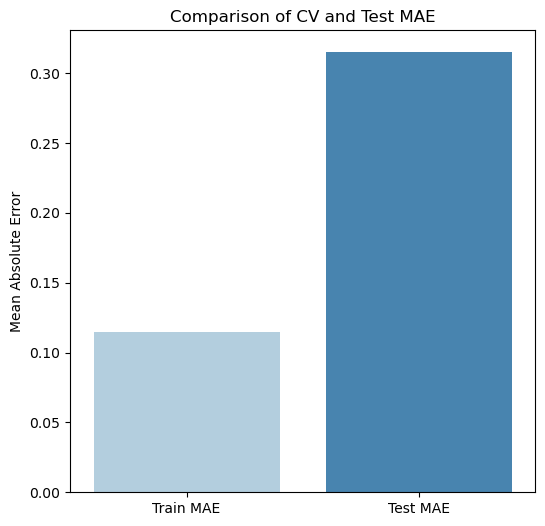

In [33]:
cv_mae = -np.mean(random_search.cv_results_["mean_test_score"])

# MAE Bar Chart with CV and Test MAE
plt.figure(figsize=(6,6))
sns.barplot(x=["Train MAE", "Test MAE"], y=[train_mae, test_mae], palette='Blues')
plt.ylabel("Mean Absolute Error")
plt.title("Comparison of CV and Test MAE")
plt.show()

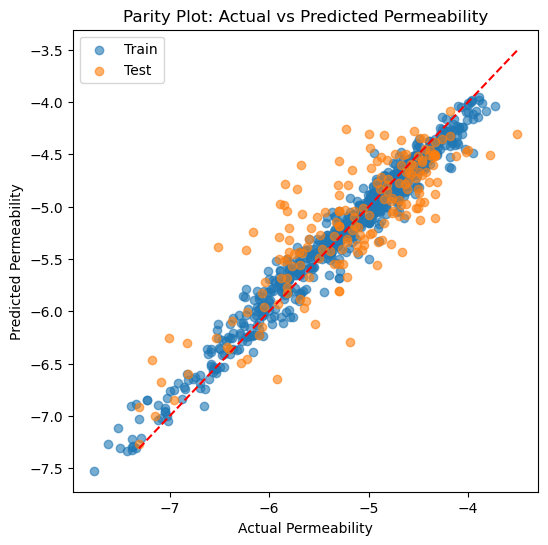

In [34]:
# --- Parity Plot ---
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_train_pred, label="Train", alpha=0.6)
plt.scatter(y_test, y_test_pred, label="Test", alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Permeability")
plt.ylabel("Predicted Permeability")
plt.title("Parity Plot: Actual vs Predicted Permeability")
plt.legend()
plt.show()

## Question - why is the test error so much worse than the training error?

Another new thing we can do is __model interpretation__ - this is where we see which of our features the model is using to make its decisions. This is performed using Shapely analysis - or SHAP. https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [36]:
## We install SHAP
%pip install shap

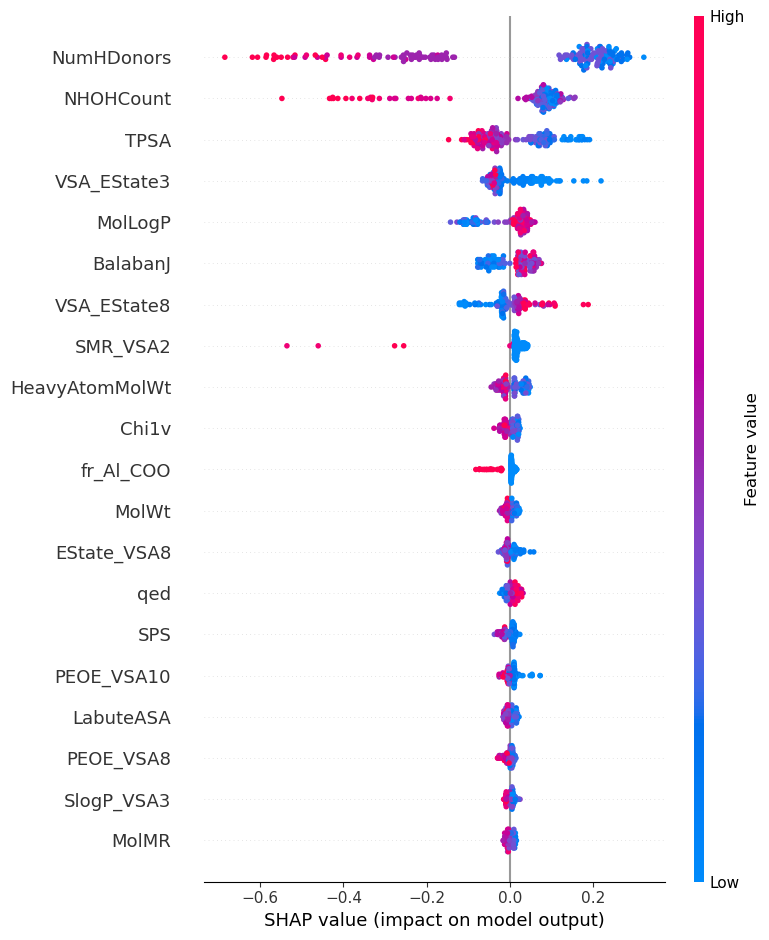

In [35]:
import shap

# We generate an "explainer" for our best model
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names = X.columns)


Features with "broad" SHAP values are very important for the predictive power of the model, and each dot in this plot represents a single sample and how much that parameter influenced the prediction of the model on it. Dots spreading to the right mean they increase the permeability value, and dots to the left decrease it.

## Question -  Do these results make sense?

 Our model is very overfit - one way we can try and reduce this is to remove features that are highly correlated to each other, and use PCA to reduce the number of features even further

#### Below is an attempt to reduce overfitting by removing features that are highly correlated with each other, then applying PCA to the remaining features to reduce them down to the minimum needed to retin 95% of the variation in the data. We then use a different type of random forest model called a HistGradientBooster model, which can potentially reduce overfitting.

In [37]:
# Identify and Remove Highly Correlated Features
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
highly_correlated_features = [column for column in upper.columns if any(upper[column] > 0.9)]
print(f"Removing highly correlated features: {highly_correlated_features}")
X = X.drop(columns=highly_correlated_features)
X_column = list(X.columns)

Removing highly correlated features: ['MaxEStateIndex', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'Kappa1', 'Kappa2', 'LabuteASA', 'SlogP_VSA6', 'VSA_EState10', 'HeavyAtomCount', 'NOCount', 'NumHDonors', 'NumHeteroatoms', 'NumSaturatedCarbocycles', 'MolMR', 'fr_Al_OH_noTert', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_Nhpyrrole', 'fr_amide', 'fr_benzene', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_ester']


In [38]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # Automatically choose number of components to retain 95% variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [39]:
# Load and set up a different type of random forest model
from sklearn.ensemble import HistGradientBoostingRegressor

# Define parameter grid for HistGradientBoostingRegressor
param_grid= {
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_leaf': [10, 20, 30],
    'early_stopping': [True],
    'tol': [1e-4, 1e-3]
}

# Perform random search for hyperparameter tuning
rf = HistGradientBoostingRegressor(random_state=42)
random_search = RandomizedSearchCV(rf, param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error', n_iter = 20)
random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=HistGradientBoostingRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'early_stopping': [True],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 10],
                                        'max_iter': [100, 200, 300],
                                        'min_samples_leaf': [10, 20, 30],
                                        'tol': [0.0001, 0.001]},
                   scoring='neg_mean_absolute_error')

In [40]:
# Best model after tuning
best_model = random_search.best_estimator_
print(f"Best Parameters: {random_search.best_params_}")

Best Parameters: {'tol': 0.0001, 'min_samples_leaf': 10, 'max_iter': 100, 'max_depth': 5, 'learning_rate': 0.1, 'early_stopping': True}


In [41]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")

Train MAE: 0.166
Test MAE: 0.322


/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_33145/1591788570.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Train MAE", "Test MAE"], y=[train_mae, test_mae], palette='Blues')


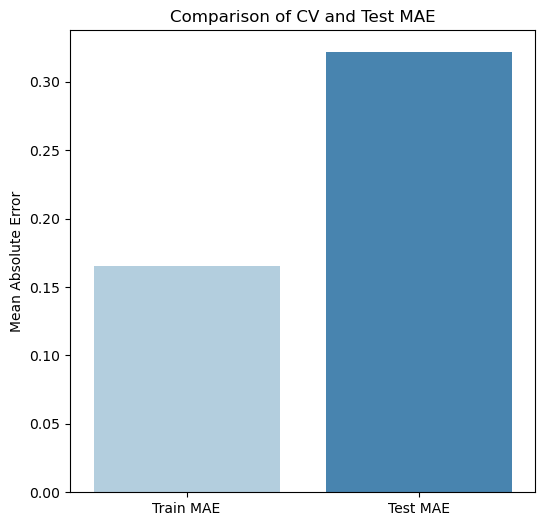

In [43]:
cv_mae = -np.mean(random_search.cv_results_["mean_test_score"])

# --- MAE Bar Chart with CV and Test MAE ---
plt.figure(figsize=(6,6))
sns.barplot(x=["Train MAE", "Test MAE"], y=[train_mae, test_mae], palette='Blues')
plt.ylabel("Mean Absolute Error")
plt.title("Comparison of CV and Test MAE")
plt.show()

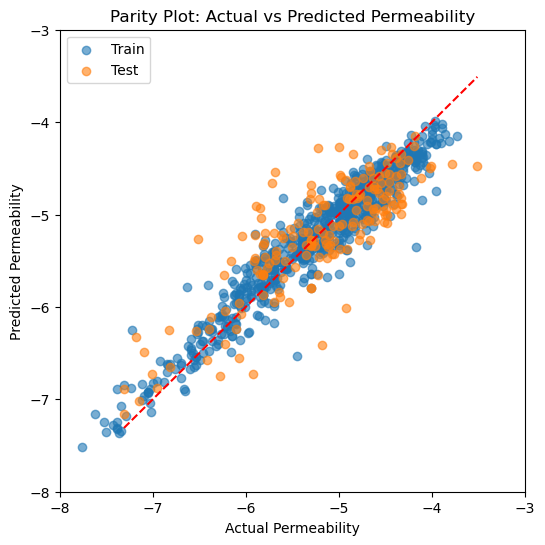

In [44]:
# --- Parity Plot ---
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_train_pred, label="Train", alpha=0.6)
plt.scatter(y_test, y_test_pred, label="Test", alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlim(-8, -3)
plt.ylim(-8, -3)
plt.xlabel("Actual Permeability")
plt.ylabel("Predicted Permeability")
plt.title("Parity Plot: Actual vs Predicted Permeability")
plt.legend()
plt.show()

### Whilst our model is still overfit, we have managed to reduce this (the difference between Train and Test MAEs is smaller) through the methods we used above. Reducing overfitting is called "regularisation" and is a key method in small scale datasets like those in pharmaceutics

## Section 3: Using molecular fingerprints

We now want to use a different method of representing our molecules to see if this improves our model at all.

The following code shows you how to compute the morgan fingerprint for our molecules, and produce a dataframe containing our permeability values followed by 2048 features representing the fingerprint of the molecule. 

### Task: Fit a model to this data, using cross validation and hyperparmameter tuning, see how accurate you can get it on the external test set - the best score I managed is: CV - 0.41, Test - 0.43

I have included a funtion below for calculating the morgan fingerprint for each molecule

In [45]:
drug_data = pd.read_excel("Drug_permeability.xlsx")

# Hardcoded data (if using google colab)

In [21]:
## If using google colab:

# Define the data
data = {'Drug_ID': ['(-)-epicatechin', '(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -ynamide', 'codeine', 'creatinine', 'danazol', 'dexamethasone b D glucoside', 'dexamethasone b D glucuronide', 'DMXAA-G', 'd-praeruptorin', 'echinacoside', 'EF5154', 'EF5170', 'EF5232', 'EF5242', 'EF5248', 'EF5249', 'EF5251', 'EF5261', 'EF5264', 'EF5265', 'EF5270', 'EF5278', 'EF5283', 'EF5292', 'elarofiban', '5-chlorosalicylic acid', 'epinephrine', 'eriodictyol ', 'erythromycin', 'famotidine', 'fexofenadine', 'fexofenadine hydrochloride', 'fluparoxan', 'AACV', 'glycerol', 'glycine-valine acyclovir', 'guanabenz', 'hesperetin ', 'hexapeptide 01', 'hexapeptide 03', 'hexapeptide 05', 'hexapeptide 06', 'hexapeptide 07', 'hexapeptide 08', 'hexapeptide 09', 'aceclofenac', 'hexapeptide 12', 'hexapeptide 13', 'hexapeptide 14', 'hexapeptide 18', 'hexapeptide 20', 'acetaminophen', 'hexapeptide 22', 'hexapeptide 23', 'hexapeptide 24', 'hexapeptide 25', 'hexapeptide 26', 'hexapeptide 27', 'hexapeptide 28', 'hexapeptide 29', 'hexapeptide 32', 'hexapeptide 33', 'hexapeptide 34', 'hexapeptide 37', 'hexapeptide 38', 'hexapeptide 41', 'hexapeptide 42', 'hexapeptide 47', 'hexapeptide 48', 'hexapeptide 52', 'hexapeptide 53', 'hexapeptide 54', 'hexapeptide 55', 'hexapeptide 56', 'hexapeptide 57', 'hexapeptide 58', 'hexapeptide 59', 'hexapeptide 60', 'hydralazine', 'hydrocortisone', 'IACV', 'alminoprofen', 'imipramine', 'indomethacin', 'isoquercitrin ', 'ketoconazole', 'lamotrigine', 'lansoprazole', 'Liquiritin apioside ', 'lisinopril', 'loracarbef', 'amfenac sodium', 'LY366659', 'LY366799', 'LY366853', 'LY366856', 'meloxicam', 'methylscopolamine', 'metolazone', 'amoxicillin', 'nadalol', 'naproxen', 'naproxen sodium', 'naringenin', 'N-carbobenzoxy-tryptophan', 'N-desmethylclozapine', 'neolignan smi02', 'neolignan smi05', 'ampicillin', 'neolignan smi08', 'neolignan smi09', 'oxacillin', 'oxprenolol ester', 'PNU200001', 'PNU200647', 'PNU200648', 'PNU200969', 'pravastatin', 'prazosin', 'prednisolone', 'preladenant', 'propranolol ester', 'puerarin ', 'quinidine', 'raffinose', 'artesunate', 'rapamycin', 'SACV', 'scopolamine', 'serotonin', 'sildenafil', 'atropine', 'sulfadiazine', 'sulfasalazine', 'tenidap', 'tenoxicam', 'theophylline', 'tiotidine', 'tryptophan', 'tryptophanamide', 'ursolic acid', 'VACV', 'verapamil', 'benzoic acid', 'vinblastine', 'VLA-4 antagonist 2', 'VLA-4 antagonist 3', 'VLA-4 antagonist 4', 'VLA-4 antagonist 5', 'VLA-4 antagonist 6', 'benzylpenicillin', 'zidovudine', 'CA-DADLE', 'CA-Leu-Enk', 'camptothecin', 'carboxamido 28', 'cefazolin', 'ceftriaxone', 'cephalexin', 'cephalexin acetylated', 'CFPN-PI', 'cimetidine', 'clozapine', '2', '34', '31', '20', '7', '6', 'Amiloride', 'Cimetidine', 'Lef53', '15j', '15f', '65', '32', 'Lobucavir', 'Metoprolol', '9', '4b', '2n', '2k', '2i', '2m', '2e', '2h', '2o', '2l', '2d', '1', '49', '48', '1', '17', '5', '22', '36', '34', '23', 'S-6j', '659-Harmane', '795-Coptisine chloride (COP)', "877-(2S,4S,5R)-2-[(4'-Chlorophenyl)-4-methyl-1,3-dioxan-5-yl]amine (5h)", "878-(2S,4S,5R)-2-[(4'-Nitrophenyl)-4-methyl-1,3-dioxan-5-yl]amine (5i)", '879-(cis)-[2-(E-Phenylvinyl)-1,3-dioxan-5-yl]amine (6a)', '880-(2S,4S,5R)-[2-(E-Phenylvinyl)-4-methyl-1,3-dioxan-5-yl]amine (6b)', '881-13h', '883-(cis)-[2-(E-Phenylvinyl)-1,3-dioxan-5-yl]phenylacetamide (14a)', '884-14b', '1029-Dihydrotetrabenazine isomer', '228-Raffinose', '234-Cortisone', '677-Prednisolone', '679-Captopril (Cap)', '732-Amitriptyline', '801-Yohimbine (YOH)', '808-Asn-Ala-NH2', '1033-Dextromethorphan (DEM)', '014-Ampicillin', '016-Ceftibuten', '107-zidovudine', '150-Artesunate', '167-cephradine', '170-Grepafloxacin hydrochloride (GRX)', '174-Guanabenz', '205-Fluoxetine', '243-Famotidine', '247-Lobucavir', '263-Amrinone', '285-Ephedrine', '403-Atorvastatin', '453-(2E,4E,8Z,10Z)-N-Isobutyldodeca-2,4,8,10-tetraenamide (5) mw=247', '643-(2E,4E,8Z)-N-isobutyldodeca-2,4,8-trienamide (6) mw = 249', 'Acrivastine', 'Aminopyrine', 'Amitriptyline', 'Amphetamine sulfate', 'Ampicillin', 'Artesunate', 'Astemizole', 'Atorvastatin', 'Betaxolol', 'Bicalutamide', 'Bisoprolol', 'Bromazepam', 'Bupropion', 'Camazepam', 'Captopril (Cap)', 'Cefuroxime', 'Celecoxib', 'Cetirizine', 'Chloroquine', 'Chlorpheniramine', 'Chlorprothixene', 'Chlortetracycline', 'Chlorzoxazone', 'Clarithromycin', 'Clozapine', 'Codeine', 'Cycloserine', 'Danazol', 'Dextromethorphan', 'Diclofenac', 'Digoxin', 'Diltiazem', 'Efavirenz', 'Emetine', 'Enalaprilat', 'Exemestane', 'Ethionamide', 'Fluoxetine', 'Fluparoxan (GR50360A)', 'Flupenthixol', 'Fluvastatin', 'Gancyclovir', 'Glipizide', 'Glutaminic Acid', 'Grepafloxacin HCl', 'Guanabenz', 'Haloperidol', 'Imatinib', 'Indinavir', 'Isoxicam', 'Ketanserin', 'Labetalol', 'Lamivudine', 'Lisinopril', 'Lomefloxacin', 'Loperamide HCl', 'Lobucavir', 'Losartan', 'Lovastatin', 'Loxoprofen', 'Mebendazole', 'Meloxicam', 'Methylprednisolone', 'Metolazone', 'Nelfinavir', 'Netivudine (882C87)', 'Nicardipine', 'Nifedipine', 'Nisoldipine', 'Nitrendipine', 'Olopatadine', 'Ouabain', 'Oxaprozin', 'Pentoxifylline', 'Phenobarbital', 'Piroxicam', 'Pravastatin', 'Prazocin', 'Pranoprofen; pyranoprofen', 'Prednisolone', 'Promazine', 'Promethazine', 'Pyrimethamine', 'Quinidine', 'Raloxifene HCl', 'Remikiren (Ro 42-5892)', 'Reserpine', 'Rifampicin', 'Rofecoxib', 'Saquinavir', 'Simvastatin', 'Sorivudine (BVaraU)', 'Sparfloxacin (SPX)', 'Spironolactone', 'Stavudine (d4T)', 'Sulfamethizole', 'Sumatriptan', 'Tacrolimus', 'Tamoxifen', 'Tenidap', 'Thalidomide', 'Tinidazole', 'Trazodone', 'Triazolam', 'Valproic acid', 'Valsartan', 'Yohimbine (YOH)', 'Zolpidem', 'Zomepirac', 'Flavone', 'Gly-Pro (glycylproline)', 'Phencyclidine (PCP)', 'DMP 851', 'N-Acetyl-D-alanyl-D-phenylalanine N-Methylamide (2)', 'N-Acetyl-D-valyl-D-phenylalanine N-Methylamide (3a)', 'N-Acetyl-D-phenylalanyl-D-phenylalanine N-Methylamide (5a)', 'N-Acetyl-D-cyclohexylalanyl-D-phenylalanine N-Methylamide (6)', 'N-Acetyl-D-alanine Phenethylamide (8)', 'N-Acetyl-D-leucine Phenethylamide (10)', 'N-Acetyl-D-phenylalanine Phenethylamide (11a)', 'N-Acetyl-D-cyclohexylalanine Phenethylamide (12)', '1', '2', '3', '4', '6', '7', '8', '9', '13', '16', 'Alprenolol ester', 'Betaxolol ester', 'Oxprenolol ester', 'Sulfasalazine', 'V', 'VIII', 'XI', 'XIV', 'DB75 [2,5-bis(4-amidinophenyl)furan]', 'Gomisin A', 'Epinephrine', 'Fleroxacin', 'Ceftriaxone', 'Penicillin G', 'BVaraU', 'Glutamine', 'LY334370', 'Dexamethasone-?-D-glucoside', 'Lactulose', 'PNU 200603', 'L-alanine', 'Tiotidine', 'Glycylsarcosine', 'MEN15596', '9-Nitrocamptothecin (9-NC)', 'H 95/71', 'H 244/45', 'Oxacillin', 'Cyclo(-PFwKTF-) (1)', 'Cyclo(-PFwKTMeF-) (3)', 'Cyclo(-PFMewKTF-) (4)', 'Cyclo(-PFMewMeKTF-) (6)', 'Ac-D-phe-NH2', 'Ac-D-phe2-NH2', 'Ac-D-phe2-(NMe-D-phe)-NH2', 'Ac-D-phe-(NMe-D-phe)2-NH2 {[14C]-Acf(N-Mef)2NH2 }', 'Ac-(NMe-D-phe)3-NH2', 'Ac-(NMe-D-phe)3-NHMe', 'BMS 189664', 'PNU200969', 'PNU-93936A', 'PNU-100766', 'PNU-184435', 'PNU-184249', 'PNU-184148', 'PNU-184147', 'PNU-184421', 'PNU-184470', 'PNU-179962', 'PNU-179399', 'NK1NK2 analogue 105 (MDL 105,212)', 'NK1NK2 analogue 212 (15d)', '366094', 'EI analogue 101 (MDL 101,146)', '354400', 'EI analogue 102 (MDL 102,111)', '368177', 'Thiamin (Vitamin B1)', '6MAQH (W2)', 'Bicyclol', "5'-L-phenylalanyl-floxuridine", "5'-L-isoleucyl-floxuridine", "5'-L-valyl-L-phenylalanyl-floxuridine", "5'-L-leucyl-L-glycyl-floxuridine", 'Tanshinol (TSL)', 'Salvianolic acid A (SAA)', 'Salvianolic acid D (SAD)', 'Lithospermic acid (LSA)', '14', 'Epimedin A', 'Epimedin B', 'Icariin', 'Baohuoside I', 'Umbelliferone', 'Angelol-A', 'Angelol-B', '8-Hydroxy-pentadeca-(9E,13Z)-dien-11-yn-2-one (2)', 'Pentadeca-(8Z,13Z)dien-11-yn-2-one (5)', 'Tetradec-(8Z)-ene-11,13-diyn-2-one (6)', 'SB639', 'PB-26', 'PB-27', 'PB-104', 'MEN14268', 'MEN14732', 'MEN14745', 'MEN15353', 'MEN15366', 'MEN15716', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', "4'-Cl BZT", "3',4''-diCl BZT", '7-MF', '5,7-DMF', "5,7,4'-TMF", "7,4'-DHF", 'Chrysin (5,7-DHF)', "Apigenin (5,7,4'-THF)", '12d', '12q', 'Biotin-Saquinavir', 'G6191', 'G6262', 'G6264', 'XP13512', '20(S)-camptothecin (CPT)', '353462', '366853', 'CPU-86017', 'Harmol', 'CF 1525 (p-Me)', 'CF 1523 (p-Cl)', 'CF 1517 (p-Br)', 'CF 1572 (p-I)', 'Roxithromycin', '2-Amino-1-methyl-6-phenylimidazo-[4,5-b]pyridine (PhIP)', '8', '10', '11', '12', '14', '15', '16', '14c', '21c', '25a', '25f', '48d', '48e', '20E 22-ethyl ether (5)', '20E 22-allyl ether (7)', '20E 25-methyl ether (10)', 'PoA 22-methyl ether (18)', '20-Hydroxyecdysone (25)', 'Muristerone A (28)', '(E)-4-(3,4-dimethoxyphenyl)but-3-en-1-yl linoleate (1)', '(E)-4-(3,4-dimethoxyphenyl)but-3-en-1-yl oleate (2)', 'Compound D', 'Rutaecarpine (RCP)', 'Evodiamine (EDM)', 'YH439', 'Choline', 'Cerulenin', 'Rebaudioside A', 'D-Phe-D-Ala-D-Ser-OH', "Dimethyl-4',4'-dimethoxy-5,6,5',6'-dimethylene dioxybiphenyl-2,2'-dicarboxylate (DDB)", 'Carbendazim', 'Dexloxiglumide', 'Lys-FITC-OCH3', 'Neostenine', 'Decursinol angelate (DA)', 'Imidacloprid (IMI)', 'Laudanosine (LAU)', 'Cepharanthine (CEP)', 'Corynanthine (COR)', 'Ac-Trp-Ala-Gly-Gly-Asp-Ala-NH2', 'Ac-Gly-Asn-Ala-NH2', 'Ac-Gly-Lys-Ala-NH2', 'cyclo[Trp-Ala-Gly-Gly-Asp-Ala]', 'Strychnine (Str)', 'Brucine (Bru)', 'Brucine N-oxide (B-N)', 'Pseudostrychnine (Psd)', 'Bilirubin', 'Bilirubin ditaurate', 'Biliverdin', '16', '32b', 'TMC435350 (32c)', '32f', '32g', '32h', 'DXG (9)', 'Isovitexin (10)', 'DG (13)', 'Kaempferol (16)', 'Tamarixetin (17)', 'Quercitrin (21)', 'Isoquercitrin (22)', 'IRR (23)', 'Eriodictyol (28)', 'Puerarin (34)', 'Isoliquiritigenin (35)', '(-)-Epicatechin (36)', '7d', '9', '10c', '10d', '11b', '11c', '11e', '12c', '12d', '3-[5-(4-hydroxyphenyl)-1,3-oxazol-2-yl]phenol (18)', 'N-(4-Chlorophenyl)-1-(2-(pyridin-4-yl)ethyl)-1H-pyrazole-5-carboxamide (11)', '19', '20', 'N-(4-(Chlorodifluoromethoxy)phenyl)-1-(2-(pyridin-4-yl)ethyl)-1H-pyrazole-5-carboxamide (22)', 'N-(4-tert-Butylphenyl)-1-(2-(pyridin-4-yl)ethyl)-1H-pyrazole-5-carboxamide (23)', '24', '1', '18 (5R,S)', '4-(Pyridin-4-ylmethylamino)-N-(3-(trifluoromethyl)phenyl)isothiazole-3-carboxamide (3)', '9', 'N-(3-tertbutylphenyl)-4-(pyridin-4-ylmethylamino)isothiazole-3-carboxamide (11)', '14', '22', '4-(quinolin-4-ylmethylamino)-N-(3-(trifluoromethyl)phenyl)isothiazole-3-carboxamide (30)', '6', '6b', '22', '24', '25', '26', '28', '30', '32', '34', '35', '36', '17d', 'KAR-2', '11-keto-beta-boswellic acid (KBA)', 'Bis(7)-tacrine (B7T)', '1', '3', "Quercetin 3,4'-diglucoside", 'D-Glu(OBzl)-Ala', 'D-Ser(Bzl)-Ala', 'Glycocholate', 'F-(S)-IZD', 'Cyclo(-PFMewKTMeF-) (7)', 'M1', 'Epigallocatechin (EGC)', 'Fluorescein', 'DB377 (4)', 'NS5B inhibitor 2', 'Deoxynivalenol (DON)', 'Putrescine', 'Met-enkephalin', '[D-Ala2]Met-enkephalin', 'Metkephamid', 'Oxazolidin-2-one (OXa)', 'OXb', 'OXc', 'OXd', 'OXe', 'OXf', 'OXh', 'OXo', 'OXn', 'Ac-Trp-Ala-Gly-Gly-Lys-Ala-NH2', 'Cytarabine (1)', "5'-L-valyl-cytarabine (2)", 'XM970', 'E15', 'E17', 'E23', 'E24', 'E25', 'E28', 'Naringin', 'N-desmethylclozapine', '13', '14', 'VX-950', 'BILN-2061', '2c', '4b', '4c', '4f', '4g', '4h', '4c', '1-naphthol', 'V', 'a', 'b', 'C', 'I-II', "5'-L-Val-FUdR", "5'-L-Leu-FUdR", 'Methylparaben', 'Propylparaben', 'Butylparaben', 'Octylparaben', 'Arzanol', '2', '4', '6', 'Pyrilamine Maleate', 'Org 12962', 'Org 5222', 'Org 33062', 'Org 25907', 'Org 13011', 'Org 34037', 'Org 23366', 'Org 34167', '21d', '2', '21e', 'Teniposide', '22', '25', '5m', '1', '13', '13d', '13e', '13g', '13i', '13j', '(E-Z)-19a', '(Z)-19b', '(Z)-19c', '(Z)-19d', '(Z)-19e', '(Z)-19g', 'T2000', 'T2007', 'Cycloastragenol', 'Byankangelicol', 'CD1', 'CD21', 'CD27', 'Zearalenone (ZEN)', 'a-Zearalenol (a-ZEL)', 'a-Zearalanol (a-ZAL)', 'Telaprevir', 'Tryptanthrin', '6', '8', '10', '11', '25', '45a', '45b', '45c', '51a', '51e', '60a', '60c', '67c', 'Amfenac', 'Levofloxacin', 'Paraoxon', 'Sulfasalamide', 'Amlodipine', 'Alfuzosin', 'Dronedarone', 'Trimethobenzamide', 'Desloratadine', 'Xaliproden (SR57746)', 'Setrobuvir (ANA598)', 'corticosterone', 'cymarin', 'daidzin ', 'desoxycarticosterone', '(2E,9Z)-N-(2-methylbutyl)pentadeca-2,9-diene-12,14-diynamide', 'EACV', '5-aminolevulinic acid', 'EF5289', 'enalapril', 'ganciclovir', 'hexapeptide 04', 'hexapeptide 15', 'hexapeptide 16', 'hexapeptide 19', 'hexapeptide 43', 'hexapeptide 51', 'indobufen', 'IRR ', 'isovitexin ', 'kaempferide ', 'LEF553', 'LY366092', 'methanol', 'N-acetyl-tryptophanamide', 'neolignan smi06', 'neolignan smi07', 'neolignan smi10', 'nitrendipine', 'omeprazole', 'ouabain', 'PNU200603', 'quercitrin ', 'saquinavir', 'SB209670', 'SDZ-RAD', 'sulfamethoxazole', 'betazolol', 'betazolol ester', 'caffeine', '4', '74', 'Verapamil', '2j', '2f', '2g', '31', '943-Ketotifen fumarate (38)', '882-13i', '061-Amiloride', '187-Saquinavir', 'Acyclovir', 'Atropine', 'Bendroflumethiazide', 'Cisapride', 'Cymarin', 'Diphenhydramine', 'Erlotinib', 'Furazolidone', 'Gefitinib', 'Ketoconazole', 'Ketotifen', 'Methadone', 'Methyldopa', 'Scopolamine', 'Talinolol', 'Terfenadine', 'Viloxazine', 'Maraviroc (UK-427,857)', 'Rhodamine 123 (Rho 123)', 'N-Acetyl-D-leucyl-D-phenylalanine N-Methylamide (4)', 'N-Acetylglycine Phenethylamide (7)', 'N-Acetyl-D-valine Phenethylamide (9a)', '10', 'Corticosterone', 'Sucrose', 'Doxorubicin', 'Propranolol ester', 'Proscillaridin', 'Dexamethasone-?-D-glucuronide', 'U-84656 (IV)', 'Ac-D-phe3-NH2', 'PNU200648', 'PNU200681', 'PNU-179450', 'PNU-182347', 'PNU-179397', 'PNU-182945', 'PNU-241028', 'NK1NK2 analogue 104 (15f)', '341908', 'UK 224,671', "5'-L-glycyl-L-leucyl-floxuridine", 'N-[5-[(4-Dimethylaminobenzoyl)amino]pentyl]-2-mercaptoacetamide (S2)', 'Vorinostat (SAHA-suberoylanilide hydroxamic acid)', '2', '11', '13', 'Sulfanilic acid', 'PB-43', 'PB-102', 'MEN14970', '-', '-', '-', '-', "3'-Cl BZT", "7,4'-DMF", '12g', '(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -ynamide (4) mw = 245', "2',3'-dideoxyinosine (ddI)", 'Val-ACV', 'CF 1526 (p-OMe)', 'S-nitrosylated captopril (CapNO)', '13', 'ME3229', '10b', '25c', '25e', '30d', '21b', '20E 22-methyl ether (4)', 'PoA 2-methyl ether (16)', 'PoA 3.22-dimethyl ether (20)', 'Ponasterone A (26)', 'Ergonovine', 'Folinic acid', 'Liquiritigenin (LG)', 'Ginsenoside Rg1 (Rg1)', 'Berberrubine (BRB)', 'Ajmalicine (AMC)', 'Ajmaline (AML)', 'Beta-colubrine (Col)', 'Icajine (Ica)', 'Pyr-His-Pro-NH2 (TRH)', 'Taxifolin (29)', '11d', '11f', 'C', 'D', '32', '3', '21', '23', '27', '29', '31', '3', 'L1 (1,2-dimethyl-3 hydroxypyridin-4-one)', 'Me-(S)-IZD', 'Acrylamide', 'Dihydrotetrabenazine isomer A', 'Ethylparaben', "5'-L-phenylalanyl-cytarabine (5)", 'Astilbin', 'Methyl gallate', 'Ketamine', '12', 'S1', 'S2', '4d', 'II', "3'-L-Ile-FUdR", "5'-L-Asp-FUdR", 'Acetyl-Trp-Ala-Gly-Gly-Asn-Ala-Amide', 'Daunorubicin', 'PDE-310', 'Cerivastatin', '23', '24', '5d', '13c', '13h', '(Z)-19f', 'MMMDPB', 'Ac-C8-Enk-NH (3)', 'Rivulobirin A', 'Capric acid (decanoic acid)', 'Apometzgerin (2)', '3', '51d', 'Cycloheximide'], 'Drug_SMILES': ['Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2', 'C/C=C\\C#CCC/C=C\\C=C\\C(=O)NCC(C)C', 'COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2)N(C)CC[C@]314', 'CN1CC(=O)NC1=N', 'C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(C)[C@H]3CC[C@@]21C', 'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)CO[C@H]1O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]1O', 'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)CO[C@H]1O[C@@H](C(=O)O)[C@H](O)[C@@H](O)[C@@H]1O', 'Cc1ccc2c(=O)c3cccc(CC(=O)OC4OC(C(=O)O)[C@@H](O)[C@@H](O)[C@@H]4O)c3oc2c1C', 'C/C=C(\\C)C(=O)O[C@H]1[C@@H](OC(C)=O)c2c(ccc3ccc(=O)oc23)OC1(C)C', 'C[C@@H]1O[C@@H](O[C@@H]2[C@@H](O)[C@H](OCCc3ccc(O)c(O)c3)O[C@H](CO[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)[C@H]2OC(=O)/C=C/c2ccc(O)c(O)c2)[C@H](O)[C@H](O)[C@H]1O', 'O=C(O)COc1ccc(C(=O)CN2CCN(C3CCNCC3)CC2=O)cc1', 'CCCCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCNCC3)CC2=O)cc1', 'CCCCC(C)OC(=O)COc1ccc(C(=O)CN2CCN(C3CCNCC3)CC2=O)cc1', 'CCCCCCC(C)OC(=O)COc1ccc(C(=O)CN2CCN(C3CCNCC3)CC2=O)cc1', 'CCCCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OCc4oc(=O)oc4C)CC3)CC2=O)cc1', 'Cc1oc(=O)oc1COC(=O)N1CCC(N2CCN(CC(=O)c3ccc(OCC(=O)OC4CCCCC4)cc3)C(=O)C2)CC1', 'CCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC(C)OC(C)=O)CC3)CC2=O)cc1', 'O=C(COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC/C=C4/OC(=O)c5ccccc54)CC3)CC2=O)cc1)OC1CCCCC1', 'CC(=O)OC(C)OC(=O)N1CCC(N2CCN(CC(=O)c3ccc(OCC(=O)OC4CCOCC4)cc3)C(=O)C2)CC1', 'CCOCC(COCC)OC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC(C)OC(C)=O)CC3)CC2=O)cc1', 'CCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC(OC(C)=O)C(C)(C)C)CC3)CC2=O)cc1', 'CCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC(OC(=O)C(C)(C)C)C(C)(C)C)CC3)CC2=O)cc1', 'CCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OC(C)OC(=O)C(C)(C)C)CC3)CC2=O)cc1', 'CC(C)(C)C(=O)OCOC(=O)N1CCC(N2CCN(CC(=O)c3ccc(OCC(=O)OC4CCCCC4)cc3)C(=O)C2)CC1', 'O=C(O)C[C@H](NC(=O)[C@@H]1CCCN(C(=O)CCC2CCNCC2)C1)c1cccnc1', 'O=C(O)c1cc(Cl)ccc1O', 'CNC[C@H](O)c1ccc(O)c(O)c1', 'O=C1C[C@@H](c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21', 'CC[C@@H]1OC(=O)[C@@H](C)[C@H](O[C@H]2C[C@](C)(OC)[C@@H](O)[C@H](C)O2)[C@@H](C)[C@@H](O[C@H]2O[C@H](C)C[C@@H](N(C)C)[C@H]2O)[C@@](C)(O)C[C@@H](C)C(=O)[C@H](C)[C@@H](O)[C@@]1(C)O', 'NC(N)=Nc1nc(CSCCC(N)=NS(N)(=O)=O)cs1', 'CC(C)(C(=O)O)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1', 'CC(C)(C(=O)O)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1.Cl', 'Fc1cccc2c1O[C@H]1CNC[C@@H]1O2', 'C=C1NC(N)=Nc2c1ncn2COCCOC(=O)[C@@H](C)N', 'OCC(O)CO', 'CC(=O)C(NC(=O)CN)c1ccc(O)cc1', 'NC(N)=N/N=C/c1c(Cl)cccc1Cl', 'COc1ccc([C@@H]2CC(=O)c3c(O)cc(O)cc3O2)cc1O', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'O=C(O)COC(=O)Cc1ccccc1Nc1c(Cl)cccc1Cl', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'CC(=O)Nc1ccc(O)cc1', 'C[C@@H]1NC(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@H]1C(=O)N[C@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N1C', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C1=O', 'C[C@H]1C(=O)N(C)[C@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N1C', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C1=O', 'C[C@H]1C(=O)N(C)[C@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N(C)[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N1C', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C1=O', 'C[C@H]1C(=O)N(C)[C@H](C)C(=O)N(C)[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N1C', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C1=O', 'C[C@H]1C(=O)N[C@H](C)C(=O)N(C)[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N(C)[C@H](C)C(=O)N(C)[C@@H](C)C(=O)N1C', 'NNc1nncc2ccccc12', 'C[C@]12C[C@@H](O)[C@@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@H]1CC[C@@]2(O)C(=O)CO', 'C=C1NC(N)=Nc2c1ncn2COCCOC(=O)[C@H](N)[C@H](C)CC', 'C=C(C)CNc1ccc(C(C)C(=O)O)cc1', 'CN(C)CCCN1c2ccccc2CCc2ccccc21', 'COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(Cl)cc1', 'O=c1c(OC2C(O)OC(CO)C(O)C2O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12', 'CC(=O)N1CCN(c2ccc(OC[C@H]3CO[C@](Cn4ccnc4)(c4ccc(Cl)cc4Cl)O3)cc2)CC1', 'Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1', 'Cc1c(OCC(F)(F)F)ccnc1CS(=O)c1nc2ccccc2[nH]1', 'O=c1cc(-c2ccc(O)cc2)oc2cc(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O[C@@H]3OC[C@](O)(CO)[C@H]3O)cc(O)c12', 'NCCCC[C@H](N[C@@H](CCc1ccccc1)C(=O)O)C(=O)N1CCC[C@H]1C(=O)O', 'N[C@@H](C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(Cl)CC[C@H]12)c1ccccc1.O', 'Nc1c(CC(=O)[O-])cccc1C(=O)c1ccccc1.O.[Na+]', 'CC(C)S(=O)(=O)n1c(N)nc2ccc(/C(=C/C(N)=O)c3c(F)c(F)cc(F)c3F)cc21', 'CC(C)S(=O)(=O)n1c(N)nc2ccc(/C(=C/C(N)=O)c3ccccc3F)cc21', 'C.CC(C)n1c(N)nc2ccc(/C(=C/C(N)=O)c3cccc(F)c3F)cc21', 'CC(C)S(=O)(=O)n1c(N)nc2ccc(/C(=C/C(N)=O)c3ccc(F)c(F)c3F)cc21', 'Cc1cnc(NC(=O)C2=C(O)c3ccccc3S(=O)(=O)N2C)s1', 'C[N+]1(C)[C@H]2CC(OC(=O)[C@H](CO)c3ccccc3)C[C@H]1C1OC12.[Br-]', 'Cc1ccccc1N1C(=O)c2cc(S(N)(=O)=O)c(Cl)cc2NC1C', 'CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)C(=O)N2[C@H]1C(=O)O', 'CC(C)(C)NCC(O)COc1cccc2c1CC(O)C(O)C2', 'COc1ccc2cc([C@H](C)C(=O)O)ccc2c1', 'COc1ccc2cc(C(C)C(=O)[O-])ccc2c1.[Na+]', 'O=C1C[C@@H](c2ccc(O)cc2)Oc2cc(O)cc(O)c21', 'O=C(NC(Cc1c[nH]c2ccccc12)C(=O)O)OCc1ccccc1', 'Clc1ccc2c(c1)N=C(N1CCNCC1)c1ccccc1N2', 'C/C=C/c1cc(OC)c2c(c1)C(C)C(c1cc(OC)c(O)c(OC)c1)O2', 'C=CCc1cc(OC)c(OC(C)Cc2cc(OC)c(OC)c(OC)c2)c(OC)c1', 'CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=O)N2[C@H]1C(=O)O', 'C=CCc1cc(OC)c(OC(C)C(O)c2cc(OC)c(OC)c(OC)c2)c(OC)c1', 'C=CCc1cc(OC)c(OC(C)C(O)c2ccc(O)c(OC)c2)c(OC)c1', 'Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12', 'C=CCOc1ccccc1OC[C@@H](CNC(C)C)OC(=O)C1CC1', 'N=C(N)c1ccc2[nH]c(Cc3nc4ccccc4[nH]3)nc2c1', 'N/C(=N/O)c1ccc2[nH]c(-c3ccccn3)nc2c1', 'Cc1ccnc2nc(Cc3nc4cc(C(=N)N)ccc4[nH]3)[nH]c12', 'CCOC(=O)NC(=N)c1ccc2[nH]c(Cc3nc4ccccc4[nH]3)nc2c1', 'CC[C@H](C)C(=O)O[C@H]1C[C@H](O)C=C2C=C[C@H](C)[C@H](CC[C@@H](O)C[C@@H](O)CC(=O)O)[C@H]21', 'COc1cc2nc(N3CCN(C(=O)c4ccco4)CC3)nc(N)c2cc1OC', 'C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO', 'COCCOc1ccc(N2CCN(CCn3ncc4c3nc(N)n3nc(-c5ccco5)nc43)CC2)cc1', 'CC(C)NC[C@H](COc1cccc2ccccc12)OC(=O)C1CC1', 'O=c1c(-c2ccc(O)cc2)coc2c([C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)c(O)ccc12', 'C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2ccc(OC)cc12', 'OC[C@H]1O[C@@](CO)(O[C@H]2O[C@H](CO[C@H]3O[C@H](CO)[C@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](O)[C@@H]1O', 'C[C@@H]1CC[C@H]2[C@@H](C)[C@H](OC(=O)CCC(=O)O)O[C@@H]3O[C@@]4(C)CC[C@@H]1[C@@]23OO4', 'CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(=O)N2CCCC[C@H]2C(=O)O[C@H]([C@H](C)C[C@@H]2CC[C@@H](O)[C@H](OC)C2)CC(=O)[C@H](C)/C=C(\\C)[C@@H](O)[C@@H](OC)C(=O)[C@H](C)C[C@H](C)/C=C/C=C/C=C/1C', 'C=C1NC(N)=Nc2c1ncn2COCCOC(=O)[C@H](N)CO', 'CN1[C@H]2CC(OC(=O)[C@H](CO)c3ccccc3)C[C@@H]1[C@H]1O[C@@H]21', 'NCCc1c[nH]c2ccc(O)cc12', 'CCCc1nn(C)c2c(=O)nc(-c3cc(S(=O)(=O)N4CCN(C)CC4)ccc3OCC)[nH]c12', 'CN1[C@H]2CC[C@@H]1CC(OC(=O)C(CO)c1ccccc1)C2', 'Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1', 'O=C(O)c1cc(/N=N/c2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O', 'NC(=O)N1C(=O)C(C(=O)c2cccs2)c2cc(Cl)ccc21', 'COc1cc2nc(N3CCN(C(=O)C4CCCO4)CC3)nc(N)c2cc1OC', 'Cn1c(=O)c2[nH]cnc2n(C)c1=O', 'C/N=C(\\NC#N)NCCSCc1csc(N=C(N)N)n1', 'NC(Cc1c[nH]c2ccccc12)C(=O)O', 'NC(=O)C(N)Cc1c[nH]c2ccccc12', 'C[C@@H]1[C@H]2C3=CC[C@@H]4[C@@]5(C)CC[C@H](O)C(C)(C)[C@@H]5CC[C@@]4(C)[C@]3(C)CC[C@@]2(C(=O)O)CC[C@H]1C', 'C=C1NC(N)=Nc2c1ncn2COCCOC(=O)[C@H](N)C(C)C', 'COc1ccc(CCN(C)CCCC(C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC', 'O=C(O)c1ccccc1', 'CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)[C@H]3[C@@](O)(C(=O)OC)[C@H](OC(C)=O)[C@]5(CC)C=CCN6CC[C@]43[C@@H]65)C2)C1', 'CCOC(=O)[C@H](Cc1ccc(OC(=O)N(C)C)cc1)NC(=O)[C@H]1N(S(=O)(=O)c2cnn(C)c2)CSC1(C)C', 'CC(C)OC(=O)[C@H](Cc1ccc(OC(=O)N(C)C)cc1)NC(=O)[C@H]1N(S(=O)(=O)c2cnn(C)c2)CSC1(C)C', 'CN(C)C(=O)Oc1ccc(C[C@H](NC(=O)[C@H]2N(S(=O)(=O)c3cnn(C)c3)CSC2(C)C)C(=O)OCC(C)(C)C)cc1', 'CN(C)C(=O)Oc1ccc(C[C@H](NC(=O)[C@H]2N(S(=O)(=O)c3cnn(C)c3)CSC2(C)C)C(=O)OCOC(=O)C(C)(C)C)cc1', 'COCCOCCOC(=O)[C@H](Cc1ccc(OC(=O)N(C)C)cc1)NC(=O)[C@H]1N(S(=O)(=O)c2cnn(C)c2)CSC1(C)C', 'CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@H]1C(=O)O', 'Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(=O)[nH]c1=O', 'CC(C)C[C@H]1NC(=O)[C@@H](Cc2ccccc2)NC(=O)CNC(=O)[C@@H](C)NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)/C=C\\c2ccccc2OC1=O', 'CC(C)C[C@H]1NC(=O)[C@@H](CC2CCCCC2)NC(=O)CNC(=O)[C@@H](C)NC(=O)[C@H](Cc2ccc(O)cc2)NC(=O)/C=C\\c2ccccc2OC1=O', 'CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1', 'CC(C)(C)CC(=O)Nc1c(F)cc(C(=O)Nc2nccs2)cc1F', 'Cc1nnc(SCC2=C(C(=O)O)N3C(=O)[C@@H](NC(=O)Cn4cnnn4)[C@H]3SC2)s1', 'CO/N=C(\\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc(=O)c(=O)[nH]n3C)CS[C@H]12)c1csc(N)n1', 'CC1=C(C(=O)O)N2C(=O)C(NC(=O)C(N)c3ccccc3)C2SC1', 'CC(=O)NC(C(=O)NC1C(=O)N2C(C(=O)O)=C(C)CSC12)c1ccccc1', 'CC/C=C(\\C(=O)N[C@@H]1C(=O)N2C(C(=O)OCOC(=O)C(C)(C)C)=C(COC(N)=O)CS[C@H]12)c1csc(N)n1.Cl.O', 'C/N=C(\\NC#N)NCCSCc1[nH]cnc1C', 'CN1CCN(C2=Nc3cc(Cl)ccc3Nc3ccccc32)CC1', 'CN(C(=O)[C@H](Cc1ccc(C(=N)N)cc1)NS(=O)(=O)c1ccc2ccccc2c1)C1CCCC1', 'NCc1cccc(Cc2ncccn2)c1', 'NC(=O)c1cccc(Cc2ncccn2)c1', 'N#Cc1cccc(Cc2ncccn2)c1', 'CNS(=O)(=O)c1ccc(Cl)cc1', 'NS(=O)(=O)c1ccc(Cl)cc1', 'N=C(N)NC(=O)c1nc(Cl)c(N)nc1N', 'CN/C(=N\\CCSCc1nc[nH]c1C)NC#N', 'NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](Cc1ccccc1)NC(=O)[C@H](CCCN=C(N)N)NC(=O)[C@@H](N)Cc1ccc(O)cc1', 'COc1cccc(-n2c(=O)n(Cc3c(F)cccc3Br)c(=O)n(C[C@H](N)c3ccccc3)c2=O)c1F', 'COc1cccc(-n2c(=O)n(Cc3ccccc3C#N)c(=O)n(C[C@H](N)c3ccccc3)c2=O)c1F', 'CC(=O)c1sc(NC(=O)N[C@@H]2CCCC[C@H]2CN2CCC[C@@H](Cc3ccc(F)cc3)C2)nc1C', 'CC(=O)c1cccc(NC(=O)N[C@@H]2CCCC[C@H]2CN2CCC[C@@H](Cc3ccc(F)cc3)C2)c1', 'Nc1nc(O)c2ncn([C@@H]3C[C@H](CO)[C@H]3CO)c2n1', 'COCCc1ccc(OCC(O)CNC(C)C)cc1', 'CC(C)CNC(=O)[C@H](C)NC[C@H](Cc1ccccc1)NC(=O)c1cc(CCC2C[C@@H]2C)cc(N(C)S(C)(=O)=O)c1', 'CC(C)CNC(=O)[C@H](C)NC[C@H](Cc1ccccc1)NC(=O)c1cc(C(=O)N[C@H](C)c2ccc(F)cc2)cc(N(C)S(C)(=O)=O)c1', 'CCOC(=O)c1c(Cl)cccc1-c1cnc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'C[C@@H](NC(=O)C1(NC(=O)C(F)(F)F)CC1)c1ccc(-c2cc(Cl)cc(F)c2-c2nnn(C)n2)cc1F', 'Cc1nc(-c2c(Cl)cc(Cl)cc2-c2ccc([C@@H](C)NC(=O)C3(NC(=O)C(F)(F)F)CC3)c(F)c2)no1', 'COC(=O)c1c(Cl)cc(Cl)cc1-c1cnc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'C[C@@H](NC(=O)C1(NC(=O)C(F)(F)F)CC1)c1ccc(-c2cc(Cl)ccc2-c2nnn(C)n2)cc1F', 'CCOC(=O)c1c(Cl)cc(Cl)cc1-c1ccc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'CCOC(=O)c1c(Cl)cc(Cl)cc1-c1cnc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'COC(=O)c1c(Cl)cccc1-c1cnc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'Cc1nc(-c2ccc(Cl)cc2-c2ccc([C@@H](C)NC(=O)C3(NC(=O)C(F)(F)F)CC3)c(F)c2)no1', 'COC(=O)c1c(Cl)cccc1-c1ccc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'O=C(N[C@@H]1CCOC[C@@H]1C(=O)NO)c1ccc(Cc2c(C(F)(F)F)nn3ccccc23)cc1', 'CC(C)(C)c1nn2ccccc2c1Cc1ccc(C(=O)N[C@@H]2CCOC[C@@H]2C(=O)NO)cc1', 'CCCN(Cc1ccoc1)C(=O)c1cc(C)cc(OCC2(CON=C(N)N)CC2)c1', 'Cc1ccc(C(F)(F)CNc2ccc(C#N)c(CC(=O)NCCONC(=N)N)c2F)nc1', 'N#Cc1ccc(NCC(F)(F)c2ccccc2)c(F)c1CC(=O)NCCONC(=N)N', 'N#Cc1ccc(NCC(F)(F)c2cccc(F)c2)c(F)c1CC(=O)NCCONC(=N)N', 'Cc1nc(N)ccc1CNC(=O)Cc1c(C#N)ccc(NCC(F)(F)c2ccccn2)c1F', 'CN(OCCNC(=O)Cc1c(C#N)ccc(NCC(F)(F)c2ccccn2)c1F)C(=N)N', 'N#Cc1ccc(NCC(F)(F)c2ccc(F)c(F)c2)c(F)c1CC(=O)NCCONC(=N)N', 'c1csc([C@]23CNC[C@H]2C3)c1', 'Cc1nccc2c1[nH]c1ccccc12', '[Cl-].c1c2c(cc3c1OCO3)-c1cc3ccc4c(c3c[n+]1CC2)OCO4', 'C[C@@H]1O[C@@H](c2ccc(Cl)cc2)OC[C@H]1N', 'C[C@@H]1O[C@@H](c2ccc(N(O)O)cc2)OC[C@H]1N', 'C=C(c1ccccc1)C1OCC(N)CO1', 'C=C(c1ccccc1)[C@H]1OC[C@@H](N)[C@H](C)O1', 'C[C@@H]1O[C@@H](c2ccc(Cl)cc2)OC[C@H]1NC(=O)Cc1ccccc1', 'C=C(c1ccccc1)C1OCC(NC(=O)Cc2ccccc2)CO1', 'C=C(c1ccccc1)[C@H]1OC[C@@H](NC(=O)Cc2ccccc2)[C@H](C)O1', 'COc1cc2c(cc1OC)C1CC(O)C(CC(C)C)CN1CC2', 'OC[C@H]1O[C@@](CO)(OC2O[C@H](COC3O[C@H](CO)[C@H](O)[C@H](O)[C@H]3O)[C@@H](O)[C@H](O)[C@H]2O)[C@@H](O)[C@@H]1O', 'C[C@@]12CCC(=O)C=C1CC[C@H]1[C@@H]3CC[C@](O)(C(=O)CO)[C@@]3(C)CC(=O)[C@H]12', 'C[C@@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[C@@]2(C)[C@H]1CC[C@]2(O)C(=O)CO', 'C[C@H](CS)C(=O)N1CCC[C@@H]1C(=O)O', 'CN(C)CCC=C1c2ccccc2CCc2ccccc21', 'COC(=O)[C@@H]1[C@H](O)CC[C@@H]2CN3CCc4c([nH]c5ccccc45)[C@H]3C[C@H]21', 'CC(NC(=O)C(N)CC(N)=O)C(N)=O', 'COc1ccc2c(c1)[C@@]13CCCC[C@@H]1[C@@H](C2)N(C)CC3', 'CC1(C)S[C@]2(C)[C@H](NC(=O)[C@H](N)c3ccccc3)C(=O)N2[C@H]1C(=O)O', 'Nc1nc(/C(=C\\CC(=O)O)C(=O)NC2C(=O)N3C(C(=O)O)=CCSC23)cs1', 'Cc1cn([C@H]2C[C@H]([N-][NH+]=N)[C@@H](CO)O2)c(=O)[nH]c1=O', 'C[C@@H]1CC[C@H]2[C@@H](C)[C@@H](OC(=O)CCC(=O)O)O[C@@H]3OC4(C)CC[C@@H]1[C@@]23OO4', 'CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@@H](N)C3=CCC=CC3)[C@H]2SC1', 'Cc1c(F)c(N2CCNC(C)C2)cc2c1C(=O)C(C(=O)O)CN2C1CC1', 'NC(N)=N/N=C/c1c(Cl)cccc1Cl', 'CNCCC(Oc1ccc(C(F)(F)F)cc1)c1ccccc1', 'NC(N)=Nc1nc(CSCC/C(N)=N\\S(N)(=O)=O)cs1', 'Nc1nc(=O)c2ncn([C@@H]3C[C@H](CO)[C@H]3CO)c2[nH]1', 'Nc1cc(-c2ccncc2)c[nH]c1=O', 'CN[C@@H](C)[C@@H](O)c1ccccc1', 'CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@H](O)C[C@H](O)CC(=O)O', 'C/C=C\\C=C/CC/C=C/C=C/C(=O)NCC(C)C', 'CCC/C=C\\CC/C=C/C=C/C(=O)NCC(C)C', 'Cc1ccc(/C(=C/CN2CCCC2)c2cccc(/C=C/C(=O)O)n2)cc1', 'Cc1c(N(C)C)c(=O)n(-c2ccccc2)n1C', 'CN(C)CCC=C1c2ccccc2CCc2ccccc21', 'C[C@H](N)Cc1ccccc1', 'CC1(C)SC2C(NC(=O)C(N)c3ccccc3)C(=O)N2C1C(=O)O', 'CC1CCC2C(C)C(OC(=O)CCC(=O)O)OC3OC4(C)CCC1C32OO4', 'COc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1', 'CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F)cc2)n1CC[C@@H](O)C[C@@H](O)CC(=O)O', 'CC(C)NCC(O)COc1ccc(CCOCC2CC2)cc1', 'CC(O)(CS(=O)(=O)c1ccc(F)cc1)C(=O)Nc1ccc(C#N)c(C(F)(F)F)c1', 'CC(C)NCC(O)COc1ccc(COCCOC(C)C)cc1', 'O=C1CN=C(c2ccccn2)c2cc(Br)ccc2N1', 'CC(NC(C)(C)C)C(=O)c1cccc(Cl)c1', 'CN(C)C(=O)OC1N=C(c2ccccc2)c2cc(Cl)ccc2N(C)C1=O', 'C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O', 'CON=C(C(=O)NC1C(=O)N2C(C(=O)O)=C(COC(N)=O)CSC12)c1ccco1', 'Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1', 'O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1', 'CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12', 'CN(C)CCC(c1ccc(Cl)cc1)c1ccccn1', 'CN(C)CC/C=C1/c2ccccc2Sc2ccc(Cl)cc21', 'CN(C)[C@@H]1C(=O)C(C(N)=O)=C(O)[C@@]2(O)C(=O)C3=C(O)c4c(O)ccc(Cl)c4[C@@](C)(O)[C@H]3C[C@@H]12', 'O=c1[nH]c2cc(Cl)ccc2o1', 'CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(OC)[C@@H](O)[C@H](C)O2)[C@H](C)[C@@H](O[C@@H]2O[C@H](C)C[C@H](N(C)C)[C@H]2O)[C@](C)(OC)C[C@@H](C)C(=O)[C@H](C)[C@@H](O)[C@]1(C)O', 'CN1CCN(C2=c3ccccc3=Nc3ccc(Cl)cc3N2)CC1', 'COc1ccc2c3c1OC1C(O)C=CC4C(C2)N(C)CCC341', 'NC1CONC1=O', 'C#C[C@@]1(O)CC[C@@H]2[C@H]3CCC4=Cc5oncc5C[C@@]4(C)[C@@H]3CC[C@]21C', 'COc1ccc2c(c1)C13CCCCC1C(C2)N(C)CC3', 'O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl', 'C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[C@@H](O)C[C@H](O[C@H]4CC[C@@]5(C)[C@H]6C[C@@H](O)[C@]7(C)C(C8=CC(=O)OC8)CC[C@]7(O)[C@@H]6CC[C@@H]5C4)O[C@@H]3C)O[C@@H]2C)C[C@H](O)[C@@H]1O', 'COc1ccc([C@@H]2Sc3ccccc3N(CCN(C)C)C(=O)[C@@H]2OC(C)=O)cc1', 'O=C1Nc2ccc(Cl)cc2[C@@](C#CC2CC2)(C(F)(F)F)O1', 'CC[C@H]1CN2CCc3cc(OC)c(OC)cc3[C@@H]2C[C@@H]1C[C@H]1NCCc2cc(OC)c(OC)cc21', 'C[C@H](N[C@H](CCc1ccccc1)C(=O)O)C(=O)N1CCC[C@@H]1C(=O)O', 'C=C1C[C@@H]2[C@H](CC[C@]3(C)C(=O)CC[C@@H]23)[C@@]2(C)C=CC(=O)C=C12', 'CCc1cc(C(N)=S)ccn1', 'CNCCC(Oc1ccc(C)cc1)c1ccccc1', 'Fc1cccc2c1O[C@H]1CNC[C@H]1O2', 'OCCN1CCN(CC/C=C2/c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1', 'CC(C)n1c(/C=C/[C@H](O)C[C@H](O)CC(=O)O)c(-c2ccc(F)cc2)c2ccccc21', 'Nc1nc2c(ncn2COC(CO)CO)c(=O)[nH]1', 'Cc1cnc(C(=O)NCCc2ccc(S(=O)(=O)NC(=O)NC3CCCCC3)cc2)cn1', 'NC(CCC(=O)O)C(=O)O', 'Cc1c(F)c(N2CCNC(C)C2)cc2c1c(=O)c(C(=O)O)cn2C1CC1', 'NC(N)=NN=Cc1c(Cl)cccc1Cl', 'O=C(CCCN1CCC(O)(c2ccc(Cl)cc2)CC1)c1ccc(F)cc1', 'Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc(-c2cccnc2)n1', 'CC(C)(C)NC(=O)[C@@H]1CN(Cc2cccnc2)CCN1C[C@@H](O)C[C@@H](Cc1ccccc1)C(=O)N[C@H]1c2ccccc2C[C@H]1O', 'Cc1cc(NC(O)=C2C(=O)c3ccccc3S(=O)(=O)N2C)no1', 'O=C(c1ccc(F)cc1)C1CCN(CCn2c(=O)[nH]c3ccccc3c2=O)CC1', 'CC(CCc1ccccc1)NCC(O)c1ccc(O)c(C(N)=O)c1', 'Nc1ccn([C@@H]2CS[C@H](CO)O2)c(=O)n1', 'NCCCC[C@H](N[C@@H](CCc1ccccc1)C(=O)O)C(=O)N1CCC[C@@H]1C(=O)O', 'CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c21', 'CN(C)C(=O)C(CCN1CCC(O)(c2ccc(Cl)cc2)CC1)(c1ccccc1)c1ccccc1', 'Nc1nc2c(ncn2C2[C@@H](CO)C[C@@H]2CO)c(=O)[nH]1', 'CCCCc1nc(Cl)c(CO)n1Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1', 'CCC(C)C(=O)OC1CC(C)C=C2C=CC(C)C(CCC3CC(O)CC(=O)O3)C21', 'CC(C(=O)O)c1ccc(CC2CCCC2=O)cc1', 'COC(=O)Nc1nc2ccc(C(=O)c3ccccc3)cc2[nH]1', 'Cc1cnc(N/C(O)=C2/C(=O)c3ccccc3S(=O)(=O)N2C)s1', 'C[C@H]1C[C@H]2[C@@H]3CC[C@](O)(C(=O)CO)[C@@]3(C)C[C@H](O)[C@@H]2[C@@]2(C)C=CC(=O)C=C12', 'Cc1ccccc1N1C(=O)c2cc(S(N)(=O)=O)c(Cl)cc2N[C@H]1C', 'Cc1c(O)cccc1C(=O)N[C@@H](CSc1ccccc1)[C@H](O)CN1C[C@H]2CCCC[C@H]2C[C@H]1C(=O)NC(C)(C)C', 'CC#Cc1cn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)[nH]c1=O', 'COC(=O)C1=C(C)NC(C)=C(C(=O)OCCN(C)Cc2ccccc2)C1c1cccc(N(O)O)c1', 'COC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1ccccc1N(O)O', 'COC(=O)C1=C(C)NC(C)=C(C(=O)OCC(C)C)C1c1ccccc1N(O)O', 'CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(N(O)O)c1', 'CN(C)CC/C=C1/c2ccccc2COc2ccc(CC(=O)O)cc21', 'C[C@@H]1O[C@@H](O[C@H]2C[C@@H](O)[C@@]3(CO)[C@H]4[C@H](O)C[C@]5(C)[C@@H](C6=CC(=O)OC6)CC[C@]5(O)[C@@H]4CC[C@]3(O)C2)[C@H](O)[C@H](O)[C@H]1O', 'O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1', 'CC(=O)CCCCn1c(=O)c2c(ncn2C)n(C)c1=O', 'CCC1(c2ccccc2)C(=O)NC(=O)NC1=O', 'CN1C(C(=O)Nc2ccccn2)=C(O)c2ccccc2S1(=O)=O', 'CCC(C)C(=O)O[C@@H]1C[C@@H](O)C=C2C=C[C@@H](C)[C@@H](CC[C@@H](O)C[C@@H](O)CC(=O)O)[C@@H]21', 'COc1cc2nc(N3CCN(C(=O)c4occc4Cl)CC3)nc(N)c2cc1OC', 'CC(C(=O)O)c1ccc2c(c1)Cc1cccnc1O2', 'C[C@]12CC(O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@@]43C)[C@@H]1CC[C@]2(O)C(=O)CO', 'CN(C)CCCN1c2ccccc2Sc2ccccc21', 'CC(CN1c2ccccc2Sc2ccccc21)N(C)C', 'CCc1nc(N)nc(N)c1-c1ccc(Cl)cc1', 'C=C[C@H]1CN2CC[C@H]1C[C@@H]2C(O)c1ccnc2ccc(OC)cc12', 'O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2cc(O)ccc12', 'CC(C)(C)S(=O)(=O)C[C@H](Cc1ccccc1)C(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@H](CC1CCCCC1)[C@@H](O)[C@H](O)C1CC1', 'COC(=O)[C@H]1[C@H]2C[C@@H]3c4[nH]c5cc(OC)ccc5c4CCN3C[C@H]2C[C@@H](OC(=O)c2cc(OC)c(OC)c(OC)c2)[C@@H]1OC', 'CO[C@@H]1C=CO[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C(=O)/C(=C\\NN2CCN(C)CC2)C(=C4O)NC(=O)C(C)=CC=C[C@@H](C)[C@H](O)[C@H](C)[C@H](O)[C@@H](C)[C@@H](OC(C)=O)[C@@H]1C', 'NS(=O)(=O)c1ccc(C2=C(c3ccccc3)C(=O)OC2)cc1', 'CC(C)(C)NC(=O)C1CC2CCCCC2CN1CC(O)C(Cc1ccccc1)NC(=O)C(CC(N)=O)NC(=O)c1ccc2ccccc2n1', 'CCC(C)(C)C(=O)O[C@@H]1C[C@H](C)C=C2C=C[C@@H](C)[C@@H](CC[C@@H]3C[C@H](O)CC(=O)O3)[C@@H]21', 'O=c1[nH]c(=O)n([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)cc1/C=C/Br', 'C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c3c2F)C[C@@H](C)N1', 'C=C[C@@H]1CN2CC[C@@H]1C[C@H]2[C@H](O)c1ccnc2ccc(OC)cc12', 'Cc1cn([C@H]2C=C[C@@H](CO)O2)c(=O)[nH]c1=O', 'Cc1nnc(NS(=O)(=O)c2ccc(N)cc2)s1', 'CNS(=O)(=O)Cc1ccc2[nH]cc(CCN(C)C)c2c1', 'C=CC[C@@H]1/C=C(\\C)C[C@H](C)C[C@H](OC)[C@H]2O[C@@](O)(C(=O)C(=O)N3CCCC[C@H]3C(=O)O[C@H](/C(C)=C/[C@@H]3CC[C@@H](O)[C@H](OC)C3)[C@H](C)[C@@H](O)CC1=O)[C@H](C)C[C@@H]2OC', 'CC/C(=C(/c1ccccc1)c1ccc(OCCN(C)C)cc1)c1ccccc1', 'NC(=O)n1c(O)c(C(=O)c2cccs2)c2cc(Cl)ccc21', 'O=C1CCC(N2C(=O)c3ccccc3C2=O)C(=O)N1', 'CCS(=O)(=O)CCn1c(N(O)O)cnc1C', 'O=c1n(CCCN2CCN(c3cccc(Cl)c3)CC2)nc2ccccn12', 'Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2', 'CCCC(CCC)C(=O)O', 'CCCCC(=O)N(Cc1ccc(-c2ccccc2-c2nnn[nH]2)cc1)[C@H](C(=O)O)C(C)C', 'COC(=O)C1C(O)CCC2CN3CCc4c([nH]c5ccccc45)C3CC21', 'Cc1ccc(-c2nc3ccc(C)cn3c2CC(=O)N(C)C)cc1', 'Cc1cc(CC(=O)O)n(C)c1C(=O)c1ccc(Cl)cc1', 'O=c1cc(-c2ccccc2)oc2ccccc12', 'NCC(=O)N1CCC[C@H]1C(=O)O', 'c1ccc(C2(N3CCCCC3)CCCCC2)cc1', 'CCCCN1C(=O)N(Cc2ccc3[nH]nc(N)c3c2)[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@H]1Cc1ccccc1', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](C)NC(C)=O', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@H](NC(C)=O)C(C)C', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](Cc1ccccc1)NC(C)=O', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](CC1CCCCC1)NC(C)=O', 'CC(=O)N[C@H](C)C(=O)NCCc1ccccc1', 'CC(=O)N[C@H](CC(C)C)C(=O)NCCc1ccccc1', 'CC(=O)N[C@H](Cc1ccccc1)C(=O)NCCc1ccccc1', 'CC(=O)N[C@H](CC1CCCCC1)C(=O)NCCc1ccccc1', 'CC1CCN(C(=O)CC(Cc2cccc(C(=N)N)c2)NS(=O)(=O)c2ccc3ccccc3c2)CC1', 'N=C(N)c1cccc(CC(CC(=O)N2CCCCC2C(=O)O)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'COC(=O)C1CCCCN1C(=O)CC(Cc1cccc(C(=N)N)c1)NS(=O)(=O)c1ccc2ccccc2c1', 'N=C(N)c1cccc(CC(CC(=O)N2CCCC(C(=O)O)C2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'N=C(N)c1cccc(CC(CC(=O)N2CCC(C(=O)O)CC2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'COC(=O)C1CCN(C(=O)CC(Cc2cccc(C(=N)N)c2)NS(=O)(=O)c2ccc3ccccc3c2)CC1', 'N=C(NO)c1cccc(CC(CC(=O)N2CCC(C(=O)O)CC2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'CNC(=N)c1cccc(CC(CC(=O)N2CCC(C(=O)O)CC2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'CC1CCN(C(=O)CC(Cc2cccc(N)c2)NS(=O)(=O)c2ccc3ccccc3c2)CC1', 'CNC(=N)c1cccc(CC(CC(=O)N2CCC(C)CC2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'C=CCc1ccccc1OCC(CNC(C)C)OC(=O)C1CC1', 'CC(C)NCC(COc1ccc(CCOCC2CC2)cc1)OC(=O)C1CC1', 'C=CCOc1ccccc1OCC(CNC(C)C)OC(=O)C1CC1', 'O=C(O)C1=C/C(=N\\Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)C=CC1=O', 'CCOc1cccc(NC(=O)OCCN2CCCC2)c1', 'CCCOc1cccc(NC(=O)OCCN2CCCC2)c1', 'CCCCOc1cccc(NC(=O)OCCN2CCCC2)c1', 'CCCCCOc1cccc(NC(=O)OCCN2CCCC2)c1', 'N=C(N)c1ccc(-c2ccc(-c3ccc(C(=N)N)cc3)o2)cc1', 'COc1cc2c(c(OC)c1OC)-c1c(cc3c(c1OC)OCO3)C[C@H](C)[C@@](C)(O)C2', 'CNCC(O)c1ccc(O)c(O)c1', 'CN1CCN(c2c(F)cc3c(=O)c(C(=O)O)cn(CCF)c3c2F)CC1', 'CO/N=C(/C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(CSc3nc(=O)c(=O)[nH]n3C)CS[C@H]12)c1csc(N)n1', 'CC1(C)S[C@H]2[C@@H](NC(=O)Cc3ccccc3)C(=O)N2[C@@H]1C(=O)O', 'O=c1[nH]c(=O)n([C@H]2O[C@@H](CO)[C@H](O)[C@H]2O)cc1/C=C/Br', 'NC(=O)CC[C@H](N)C(=O)O', 'CN1CCC(c2c[nH]c3ccc(NC(=O)c4ccc(F)cc4)cc23)CC1', 'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)COC1O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]1O', 'OC[C@@H]1O[C@@](O)(CO)[C@H](O)[C@H]1O[C@@H]1O[C@H](CO)[C@H](O)[C@H](O)[C@H]1O', 'N=C(N)c1ccc2nc(-c3ccccn3)[nH]c2c1', 'C[C@H](N)C(=O)O', 'C/N=C(\\NC#N)NCCSCc1csc(N=C(N)N)n1', 'CN(CC(=O)O)C(=O)CN', 'Cc1ccc2cc(C(=O)NC3(C(=O)N[C@H](Cc4ccccc4)C(=O)NCC4CCN(CC5CCOCC5)CC4)CCCC3)sc2c1', 'CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(N(O)O)cccc3nc2-1', 'CC(C)NCC(O)COc1ccc(NC=O)cc1', 'CCC(=O)Nc1ccc(OCC(O)CNC(C)C)cc1', 'Cc1onc(-c2ccccc2)c1C(=O)N[C@@H]1C(=O)N2[C@@H](C(=O)O)C(C)(C)S[C@H]12', 'C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC1=O', 'C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)N(C)C1=O', 'C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)NC(=O)[C@@H](Cc2c[nH]c3ccccc23)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC1=O', 'C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)N(C)C(=O)[C@@H](Cc2c[nH]c3ccccc23)N(C)C(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)NC1=O', 'CC(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccccc1)C(N)=O', 'CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccccc1)C(=O)N(C)[C@@H](Cc1ccccc1)C(N)=O', 'CC(=O)N[C@@H](Cc1ccccc1)C(=O)N(C)[C@H](Cc1ccccc1)C(=O)N(C)[C@@H](Cc1ccccc1)C(N)=O', 'CC(=O)N(C)[C@@H](Cc1ccccc1)C(=O)N(C)[C@H](Cc1ccccc1)C(=O)N(C)[C@@H](Cc1ccccc1)C(N)=O', 'CNC(=O)[C@H](Cc1ccccc1)N(C)C(=O)[C@@H](Cc1ccccc1)N(C)C(=O)[C@H](Cc1ccccc1)N(C)C(C)=O', 'CS(=O)(=O)N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)NCC1CCN(C(=N)N)CC1', 'CCOC(=O)NC(=N)c1ccc2nc(Cc3nc4ccccc4[nH]3)[nH]c2c1', 'CC(=O)NCC1CN(c2cc(F)c(-c3ccncc3)c(F)c2)C(=O)O1', 'CC(=O)NC[C@H]1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1', 'CC(=S)NC[C@H]1CN(c2ccc(N3CCCS(=O)CC3)c(F)c2)C(=O)O1', 'CCC(=S)NC[C@H]1CN(c2ccc(N3CCN(C=O)CC3)c(F)c2)C(=O)O1', 'O=C(CO)N1CCN(c2ccc(N3C[C@H](CNC(=S)C4CC4)OC3=O)cc2F)CC1', 'CCC(=S)NC[C@H]1CN(c2ccc(N3CCN(C(=O)CO)CC3)c(F)c2)C(=O)O1', 'CC(=O)NC[C@H]1CN(c2ccc(-c3ccc(C#N)nc3)c(F)c2)C(=O)O1', 'CC(=S)NC[C@H]1CN(c2ccc(N3CCCS(=O)(=O)CC3)c(F)c2)C(=O)O1', 'CC(=O)NC[C@H]1CN(c2ccc(-c3nnc(CC/C(C)=N\\O)s3)c(F)c2)C(=O)O1', 'NC(=S)NC[C@H]1CN(c2ccc(C3CCS(=O)(=O)CC3)c(F)c2)C(=O)O1', 'COc1cc(C(=O)N2CC[C@](CCN3CCC(C(N)=O)(c4ccccc4)CC3)(c3ccc(Cl)c(Cl)c3)C2)cc(OC)c1OC', 'COc1cc(C(=O)N2CC[C@](CCN3CCC(C(=O)N4CCOCC4)(c4ccccc4)CC3)(c3ccc(Cl)c(Cl)c3)C2)cc(OC)c1OC', 'CNC(=O)C(c1ccc2nc(N)n(C(C)C)c2c1)c1cccc(F)c1F', 'CC(C)C(NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)c1ccc(C(=O)N2CCOCC2)cc1)C(C)C)C(=O)C(F)(F)C(F)(F)F', 'CC(C)NS(=O)(=O)n1c(N)nc2ccc(C(C(N)=O)c3cc(F)ccc3F)cc21', 'CC(C)C(NC(=O)[C@@H]1CCCN1C(=O)[C@@H](NC(=O)N1CCOCC1)C(C)C)C(=O)C(F)(F)C(F)(F)F', 'CNC(=O)C(c1ccc2nc(N)n(C3CCCC3)c2c1)c1ccccc1F', 'Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1', 'O=C(CS)NCCCCCC(=O)Nc1cccc2cccnc12', 'COC(=O)c1cc(OC)c2c(c1-c1c(CO)cc(OC)c3c1OCO3)OCO2', 'NC(Cc1ccccc1)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CCC(C)C(N)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CC(C)C(N)C(=O)NC(Cc1ccccc1)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CC(C)CC(N)C(=O)NCC(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'O=C(O)C(O)Cc1ccc(O)c(O)c1', 'O=C(/C=C/c1ccc(O)c(O)c1/C=C/c1ccc(O)c(O)c1)OC(Cc1ccc(O)c(O)c1)C(=O)O', 'O=C(O)Cc1c(/C=C/C(=O)OC(Cc2ccc(O)c(O)c2)C(=O)O)ccc(O)c1O', 'O=C(/C=C/c1ccc(O)c2c1C(C(=O)O)C(c1ccc(O)c(O)c1)O2)OC(Cc1ccc(O)c(O)c1)C(=O)O', 'CCCCCCC(N)C(=O)N[C@@H](Cc1c(C)cc(O)cc1C)C(=O)N1CCC[C@@H]1C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'COc1ccc(-c2oc3c(CC=C(C)C)c(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)ccc3c(=O)c2O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O[C@@H]2O[C@@H](C)[C@H](O)[C@@H](O)[C@H]2O)cc1', 'COc1ccc(-c2oc3c(CC=C(C)C)c(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)cc(O)c3c(=O)c2O[C@H]2O[C@H](C)[C@@H](O)[C@H](O)[C@@H]2O[C@H]2OC[C@H](O)[C@@H](O)[C@@H]2O)cc1', 'COc1ccc(-c2oc3c(CC=C(C)C)c(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)cc(O)c3c(=O)c2O[C@H]2O[C@H](C)[C@@H](O)[C@H](O)[C@@H]2O)cc1', 'COc1ccc(-c2oc3c(CC=C(C)C)c(O)cc(O)c3c(=O)c2O[C@H]2O[C@H](C)[C@@H](O)[C@H](O)[C@@H]2O)cc1', 'O=c1ccc2ccc(O)cc2o1', 'C/C=C(/C)C(=O)O[C@H](c1cc2ccc(=O)oc2cc1OC)[C@H](O)C(C)(C)O', 'C/C=C(/C)C(=O)O[C@@H]([C@@H](O)c1cc2ccc(=O)oc2cc1OC)C(C)(C)O', 'C/C=C\\C#C/C=C/C(O)CCCCCC(C)=O', 'C/C=C\\C#CC/C=C\\CCCCCC(C)=O', 'C#CC#CC/C=C\\CCCCCC(C)=O', 'O=C(/C=C/c1ccc2c(c1)nc(CCc1ccccc1)n2CCN1CCCC1)NO', 'Cn1cncc1CN1CC(N(Cc2cccc(-n3cccc3)c2)S(=O)(=O)c2ccccn2)Cc2cc(C#N)ccc21', 'Cn1cncc1CN1CC(N(Cc2ccccn2)S(=O)(=O)c2ccccn2)Cc2cc(C#N)ccc21', 'CCOC(=O)N1CCC(CN(C2Cc3cc(C#N)ccc3N(Cc3cncn3C)C2)S(=O)(=O)c2ccccn2)CC1', 'O=C(NC1(C(=O)N[C@@H](Cc2ccccc2)C(=O)NCCCN2CCOCC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCCN2CCOCC2)CCCC1)c1ccc(-c2ccccc2)cc1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCCN2CCOCC2)CCCC1)c1cc2ccccc2o1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NC2CCN(CC3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCC2CCN(CC3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'CCN(CC)c1ccc2cc(C(=O)NC3(C(=O)N[C@H](Cc4ccccc4)C(=O)NCC4CCN(CC5CCOCC5)CC4)CCCC3)sc2c1', 'O=C(O)c1ccncc1', 'Nc1cccnc1', 'NC(=O)c1ccncc1', 'Clc1ccncc1', 'OCc1ccncc1', 'c1ccc(-c2ccncc2)cc1', 'Nc1ccncc1', 'CCc1ccncc1', 'c1ccncc1', 'Cc1ccncc1', 'c1ccc(-c2cccnc2)cc1', 'CN1C2CC[C@@H]1CC(OC(c1ccccc1)c1ccc(Cl)cc1)C2', 'CN1C2CC[C@@H]1CC(OC(c1ccc(Cl)cc1)c1cccc(Cl)c1)C2', 'COc1ccc2c(=O)cc(-c3ccccc3)oc2c1', 'COc1cc(OC)c2c(=O)cc(-c3ccccc3)oc2c1', 'COc1ccc(-c2cc(=O)c3c(OC)cc(OC)cc3o2)cc1', 'O=c1cc(-c2ccc(O)cc2)oc2cc(O)ccc12', 'O=c1cc(-c2ccccc2)oc2cc(O)cc(O)c12', 'O=c1cc(-c2ccc(O)cc2)oc2cc(O)cc(O)c12', 'Cn1cnc(S(=O)(=O)N(CCN(Cc2cncn2C)c2ccc(C#N)cc2)Cc2ccccc2)c1', 'Cn1cnc(S(=O)(=O)N(CCN(Cc2cncn2C)c2ccc(C#N)cc2)CC2CCCCC2)c1', 'CC(C)(C)NC(=O)[C@@H]1CC2CCCCC2CN1CC(OC(=O)CCCCC1SCC2NC(=O)NC21)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(N)=O)NC(=O)c1ccc2ccccc2n1', 'CN1C(=O)CN(CCC(=O)O)C(=O)c2cc(NCc3ccc(C(=N)N)cc3)ccc21', 'CCOC(=O)CCN1CC(=O)N(C)c2ccc(OCc3ccc(C(=N)N)cc3)cc2C1=O', 'CCOC(=O)CCN1CC(=O)N(C)c2ccc(NCc3ccc(C(=N)N)cc3)cc2C1=O', 'CC(OC(=O)NCC1(CC(=O)O)CCCCC1)OC(=O)C(C)C', 'CC[C@]1(O)C(=O)OCc2c1cc1n(c2=O)-c2cc3ccccc3nc2C1', 'CN(C)C(=O)NS(=O)(=O)n1c(N)nc2ccc(C(C(N)=O)c3cccc(F)c3)cc21', 'CC(C)n1c(N)nc2ccc(C(C(N)=O)c3cccc(F)c3F)cc21', 'COc1ccc2c(c1OC)C[N+]1(Cc3ccc(Cl)cc3)CCc3cc4c(cc3C1C2)OCO4.[Cl-]', 'Cc1nccc2c1[nH]c1cc(O)ccc12', 'COC(=O)C(C)NP(=O)(OC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=O)O1)Oc1ccc(C)cc1', 'COC(=O)C(C)NP(=O)(OC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=O)O1)Oc1ccc(Cl)cc1', 'COC(=O)C(C)NP(=O)(OC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=O)O1)Oc1ccc(Br)cc1', 'COC(=O)C(C)NP(=O)(OC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=O)O1)Oc1ccc(I)cc1', 'CC[C@@H]1OC(=O)[C@@H](C)[C@H](O[C@@H]2C[C@](C)(OC)[C@H](O)[C@@H](C)O2)[C@H](C)[C@H](O[C@@H]2O[C@H](C)C[C@H](N(C)C)[C@H]2O)[C@@](C)(O)C[C@@H](C)/C(=N\\OCOCCOC)[C@H](C)[C@@H](O)[C@@]1(C)O', 'Cn1c(N)nc2ncc(-c3ccccc3)cc21', 'COc1cc(C)ccc1S(=O)(=O)NC(=O)C(c1ccc2c(c1)OCO2)c1cn(C)c2cc(C#N)ccc12', 'COc1cc(C)ccc1S(=O)(=O)NC(=O)C(c1ccc2c(c1)OCO2)c1cn(C)c2cc(F)ccc12', 'COc1cc(C)ccc1S(=O)(=O)NC(=O)C(c1ccc2c(c1)OCO2)c1cn(C)c2cc(C(C)=O)ccc12', 'COCc1ccc2c(C(C(=O)NS(=O)(=O)c3ccc(C)cc3OC)c3ccc4c(c3)OCO4)cn(C)c2c1', 'Cc1ccc(S(=O)(=O)NC(=O)C(c2ccc3c(c2)OCO3)c2cn(C)c3cc(CO)ccc23)cc1', 'COCCn1cc(C(C(=O)NS(=O)(=O)c2ccc(C)cc2OC)c2ccc3c(c2)OCO3)c2ccc(COC)cc21', 'COCCn1cc(C(C(=O)NS(=O)(=O)c2ccc(C)cc2OC)c2ccc3c(c2)OCO3)c2ccc(F)cc21', 'Cn1c(C(=O)NC2(C(=O)N[C@H](Cc3ccccc3)C(=O)NCCCN3CCOCC3)CCCC2)cc2ccccc21', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCCN2CCC(O)CC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCCC(=O)N2CCC(N3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCC(=O)N2CCN(C3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCC2CCN(CC3CCOCC3)CC2)CCCC1)c1cc2ccc(C(F)(F)F)cc2s1', 'COc1ccc2cc(C(=O)NC3(C(=O)N[C@H](Cc4ccccc4)C(=O)NCC4CCN(CC5CCOCC5)CC4)CCCC3)sc2c1', 'CCO[C@H](CCC(C)(C)O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'C=CCO[C@H](CCC(C)(C)O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'COC(C)(C)CC[C@@H](O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'CO[C@H](CCC(C)C)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'CC(C)(O)CC[C@@H](O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'CC(C)CC[C@@H](O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@]4(O)C[C@@H](O)[C@@H](O)C[C@@]4(C)C3[C@@H](O)C[C@]12C', 'CCCCC/C=C\\C/C=C\\CCCCCCCC(=O)OCC/C=C/c1ccc(OC)c(OC)c1', 'CCCCCCCC/C=C\\CCCCCCCC(=O)OCC/C=C/c1ccc(OC)c(OC)c1', 'COc1ccc(/C=C/CCO)cc1OC', 'O=c1c2ccccc2nc2n1CCc1c-2[nH]c2ccccc12', 'CN1c2ccccc2C(=O)N2CCc3c([nH]c4ccccc34)C21', 'Cc1csc(NC(=O)C(C(=O)OC(C)C)=C2SCS2)n1', 'C[N+](C)(C)CCO', 'C/C=C/C/C=C/CCC(=O)[C@@H]1O[C@@H]1C(N)=O', 'C=C1C[C@]23CC[C@H]4[C@@](C)(CCC[C@@]4(C)C(=O)OC4O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]4O)C2CC(O[C@H]2O[C@@H](CO)[C@H](O)C(O[C@H]4O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]4O)[C@@H]2O[C@H]2O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]2O)[C@H]1C3', 'C[C@H](NC(=O)[C@H](N)Cc1ccccc1)C(=O)N[C@H](CO)C(=O)O', 'COC(=O)c1cc(OC)c2c(c1-c1c(C(=O)OC)cc(OC)c3c1OCO3)OCO2', 'COC(=O)Nc1nc2ccccc2[nH]1', 'CCCCCN(CCCOC)C(=O)[C@@H](CCC(=O)O)NC(=O)c1ccc(Cl)c(Cl)c1', 'COC(=O)[C@H](N)CCCCNC(=S)Nc1ccc2c(c1)C(=O)OC21c2ccc(O)cc2Oc2cc(O)ccc21', 'CC[C@@H]1C2CCCCN3CCC(C23)[C@@H]2[C@H](C)C(=O)O[C@H]12', 'CC(C)=CC(=O)O[C@@H]1Cc2cc3ccc(=O)oc3cc2OC1(C)C', 'ON(O)NC1=NCCN1Cc1ccc(Cl)nc1', 'COc1ccc(CC2c3cc(OC)c(OC)cc3CCN2C)cc1OC', 'COc1ccc2cc1Oc1ccc(cc1)CC1c3c(cc4c(c3Oc3cc5c(cc3OC)CCN(C)C5C2)OCO4)CCN1C', 'COC(=O)[C@H]1[C@H](O)CC[C@@H]2CN3CCc4c([nH]c5ccccc45)[C@H]3C[C@H]21', 'CC(=O)NC(Cc1c[nH]c2ccccc12)C(=O)NC(C)C(=O)NCC(=O)NCC(=O)NC(CC(=O)O)C(=O)NC(C)C(N)=O', 'CC(=O)NCC(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](C)C(N)=O', 'CC(=O)NCC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(N)=O', 'CC1NC(=O)C(CC(=O)O)NC(=O)CNC(=O)CNC(=O)C(C)NC(=O)C(Cc2c[nH]c3ccccc23)NC1=O', 'O=C1C[C@@H]2OCC=C3CN4CC[C@]56c7ccccc7N1[C@H]5[C@H]2[C@H]3C[C@H]46', 'COc1cc2c(cc1OC)[C@]13CCN4CC5=CCO[C@@H]6CC(=O)N2[C@@H]1[C@@H]6[C@@H]5C[C@@H]43', 'COc1cc2c(cc1OC)[C@]13CC[N+]4([O-])CC5=CCO[C@@H]6CC(=O)N2[C@@H]1[C@@H]6[C@@H]5C[C@H]34', 'O=C1C[C@H]2OCC=C3CN4C[C@H](O)C56c7ccccc7N1[C@@H]5[C@H]2[C@H]3CC46', 'C=CC1=C(C)/C(=C\\c2[nH]c(Cc3[nH]c(/C=C4/NC(=O)C(C)=C4C=C)c(C)c3CCC(=O)O)c(CCC(=O)O)c2C)NC1=O', 'C=CC1=C(C)/C(=C\\c2[nH]c(Cc3[nH]c(/C=C4/NC(=O)C(C)=C4C=C)c(C)c3CCC(=O)NCCS(=O)(=O)O)c(CCC(=O)NCCS(=O)(=O)O)c2C)NC1=O', 'C=CC1=C(C)/C(=C\\C2=N/C(=C\\c3[nH]c(/C=C4/NC(=O)C(C)=C4C=C)c(C)c3CCC(=O)O)C(CCC(=O)O)=C2C)NC1=O', 'COc1cnn(C)c(=O)c1-c1ccc(C[C@@H](CO)NC(=O)c2c(Cl)cccc2Cl)cc1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)cc(-c3nc(C(C)C)cs3)nc2c1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)cc(-c3nc(C(C)C)cs3)nc2c1C', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)cc(-c3nc(C(C)C)cs3)nc2c1Cl', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)cc(-n3ccc(C(C)C)n3)nc2c1C', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)cc(-c3cccc(C(C)C)n3)nc2c1C', 'COc1ccc(-c2cc(=O)c3c(O)cc(OC4O[C@H](CO[C@@H]5OC[C@@H](O)[C@H](O)[C@H]5O)[C@@H](O)[C@H](O)[C@H]4O)cc3o2)cc1O', 'O=c1cc(-c2ccc(O)cc2)oc2cc(O)c([C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)c(O)c12', 'COc1ccc(-c2cc(=O)c3c(O)cc(O[C@@H]4O[C@H](CO)[C@@H](O)[C@H](O)[C@H]4O)cc3o2)cc1O', 'O=c1c(O)c(-c2ccc(O)cc2)oc2cc(O)cc(O)c12', 'COc1ccc(-c2oc3cc(O)cc(O)c3c(=O)c2O)cc1O', 'C[C@@H]1O[C@@H](Oc2c(-c3ccc(O)c(O)c3)oc3cc(O)cc(O)c3c2=O)[C@@H](O)[C@H](O)[C@@H]1O', 'O=c1c(O[C@@H]2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12', 'COc1cc(-c2oc3cc(O)cc(O)c3c(=O)c2OC2O[C@H](CO[C@H]3O[C@H](C)[C@@H](O)[C@H](O)[C@@H]3O)[C@@H](O)[C@H](O)[C@H]2O)ccc1O', 'O=C1CC(c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21', 'O=c1c(-c2ccc(O)cc2)coc2c(C3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)c(O)ccc12', 'O=C(/C=C/c1ccc(O)cc1)c1ccc(O)cc1O', 'Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@H](O)C2', 'Cc1ccc(N2CCN(C(=O)[C@H](C)Cc3ccc(Cl)cc3)CC2)c([C@@H](N)C(C)C)c1', 'CNCCN[C@H](c1cc(C)ccc1N1CCN(C(=O)[C@H](C)Cc2ccc(Cl)cc2F)CC1)C(C)C', 'CNCC(=O)N[C@H](c1cccc(F)c1N1CCN(C(=O)[C@H](C)Cc2ccc(Cl)cc2Cl)CC1)C(C)C', 'CC(C)[C@H](NC(=O)CCN(C)C)c1cccc(F)c1N1CCN(C(=O)[C@H](C)Cc2ccc(Cl)cc2)CC1', 'Cc1ccc(N2CCN(C(=O)[C@H](C)Cc3ccc(Cl)cc3)CC2)c([C@@H](NC(=O)CCN)C(C)C)c1', 'CNCCC(=O)N[C@H](c1cc(C)ccc1N1CCN(C(=O)[C@H](C)Cc2ccc(Cl)cc2)CC1)C(C)C', 'Cc1ccc(N2CCN(C(=O)[C@H](C)Cc3ccc(Cl)cc3F)CC2)c([C@@H](NC(=O)CCN(C)C)C(C)C)c1', 'COc1cc(Cl)ccc1C[C@@H](C)C(=O)N1CCN(c2ccc(Cl)cc2[C@@H](NC(=O)C(C)N)C(C)C)CC1', 'CC(C)[C@H](NC(=O)CCN(C)C)c1cc(Cl)ccc1N1CCN(C(=O)[C@H](C)Cc2ccc(Cl)cc2)CC1', 'Oc1ccc(-c2cnc(-c3cccc(O)c3)o2)cc1', 'O=C(Nc1ccc(Cl)cc1)c1ccnn1CCc1ccncc1', 'CCc1ccc(NC(=O)c2ccnn2CCc2ccncc2)cc1', 'O=C(Nc1ccc(OC(F)(F)F)cc1)c1ccnn1CCc1ccncc1', 'O=C(Nc1ccc(OC(F)(F)Cl)cc1)c1ccnn1CCc1ccncc1', 'CC(C)(C)c1ccc(NC(=O)c2ccnn2CCc2ccncc2)cc1', 'CC(C)c1ccc(NC(=O)c2ccnn2CCc2ccncc2)cc1', 'Cc1cc(COc2ccc(C(=O)N[C@@H]3CC4(C[C@@H]3C(=O)NO)OCCO4)cc2)c2ccccc2n1', 'Cc1cc(COc2ccc(C(=O)N[C@@H]3C[C@@]4(CCCO4)C[C@@H]3C(=O)NO)cc2)c2ccccc2n1', 'O=C(Nc1cccc(C(F)(F)F)c1)c1nscc1NCc1ccncc1', 'O=C(Nc1cccc(OC(F)(F)F)c1)c1nscc1NCc1ccncc1', 'CC(C)(C)c1cccc(NC(=O)c2nscc2NCc2ccncc2)c1', 'O=C(Nc1cccc(Br)c1)c1nscc1NCc1ccncc1', 'Cc1ccc(NC(=O)c2nscc2NCc2ccncc2)cc1C(F)(F)F', 'O=C(Nc1cccc(C(F)(F)F)c1)c1nscc1NCc1ccnc2ccccc12', 'Cn1c(NCCCN2CCC(CN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'CN(CCCN1CCC(CN2c3ccccc3Sc3ccc(C(=O)O)cc32)CC1)c1cc(=O)n(C)c(=O)n1C', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4c(C(=O)O)cccc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCN(CCN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCN(CCCCN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(CC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(CCC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(C(C)(C)C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(OCC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4ccc(/C=C/C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(C2=CCN(CCCN3c4ccccc4Sc4ccc(CC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'CC(C)[C@@H](C(=O)N[C@H](C)Cc1ccc(O)c(C(C)(C)C)c1)N(C)C(=O)[C@@H](N)Cc1ccccc1', 'CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](C(=O)OC)(c3cc4c(cc3OC)N(C)[C@H]3[C@@]5(C[C@]6(CC)C=CCN7CC[C@]43[C@@H]76)OC(=O)N(CCCl)C5=O)C2)C1', 'C[C@H]1C[C@@]2(C)C(=CC(=O)[C@@H]3[C@]4(C)CC[C@@H](O)[C@@](C)(C(=O)O)[C@H]4CC[C@]32C)[C@@H]2[C@@H](C)[C@H](C)CC[C@H]12', 'c1ccc2c(NCCCCCCCNc3c4c(nc5ccccc35)CCCC4)c3c(nc2c1)CCCC3', 'Cc1c(O)c2c(c(C)c1CCO)C(=O)C(C)(C)C2', 'Cc1c(O)c2c(c(C)c1CCO[C@@H]1O[C@H](CO)[C@@H](O)[C@H](O)[C@H]1O)C(=O)C(C)(C)C2', 'O=c1c(OC2O[C@H](CO)[C@@H](O)[C@H](O)[C@H]2O)c(-c2ccc(OC3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)c(O)c2)oc2cc(O)cc(O)c12', 'CC(NC(=O)[C@@H](N)CCC(=O)OCc1ccccc1)C(=O)O', 'CC(NC(=O)[C@@H](N)COCc1ccccc1)C(=O)O', 'C[C@H](CCC(=O)NCC(=O)[O-])[C@H]1CC[C@H]2[C@H]3[C@H](C[C@H](O)[C@@]21C)[C@@]1(C)CC[C@@H](O)C[C@H]1C[C@H]3O', 'O=C1C[C@@H](c2ccc(C[C@H](NS(=O)(=O)c3ccccc3)c3nc4ccccc4[nH]3)cc2F)S(=O)([O-])=N1', 'C[C@@H](O)[C@@H]1NC(=O)[C@H](CCCCN)N(C)C(=O)[C@@H](Cc2c[nH]c3ccccc23)NC(=O)[C@H](Cc2ccccc2)NC(=O)[C@@H]2CCCN2C(=O)[C@H](Cc2ccccc2)N(C)C1=O', 'CN(C)CC1CCCCC1(O)c1cccc(O)c1', 'Oc1cc(O)c2c(c1)O[C@H](c1cc(O)c(O)c(O)c1)[C@H](O)C2', 'O=C(O)c1ccccc1-c1c2ccc(=O)cc-2oc2cc(O)ccc12', 'CCO/N=C(\\N)c1ccc(-c2ccc(-c3ccc(/C(N)=N/OCC)cc3)o2)cc1', 'CC(C)CCn1c(=O)c(C2=NS(=O)(=O)c3ccccc3N2)c(O)c2cccn21', 'CC1=C[C@@H]2O[C@@H]3[C@@H](O)C[C@](C)([C@]34CO4)[C@]2(CO)[C@@H](O)C1=O', 'NCCCCN', 'CSCC[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)CNC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)O', 'CSCC[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)[C@@H](C)NC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)O', 'CN[C@@H](CCSC)C(=O)NC(=O)[C@H](Cc1ccccc1)NC(=O)CNC(=O)[C@@H](C)NC(=O)[C@@H](N)Cc1ccc(O)cc1', 'CC(=O)NCC1CN(c2ccc(C(C)=O)cc2)C(=O)O1', 'CC(=O)c1ccc(N2CC(CO)OC2=O)cc1', 'CC(=O)c1ccc(N2CC(CN)OC2=O)cc1', 'CCCOCOCC1CN(c2ccc(C(C)=O)cc2)C(=O)O1', 'CC(=O)NC(O)CNc1ccc(C(C)=O)cc1', 'CC(=O)NCC1CN(c2ccc(C(C)=O)cc2)S(=O)N1C', 'CC(=O)NCC1CN(c2ccc(C(C)O)cc2)C(=O)N1', 'CC(=O)NCC1CN(S(=O)(=O)c2ccc(C)cc2)C(=O)O1', 'CC(=O)c1ccc2c(c1)N1C(=O)OCC1CC2', 'CC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](C)C(=O)NCC(=O)NCC(=O)N[C@@H](CCCCN)C(=O)N[C@@H](C)C(N)=O', 'O=c1nc(O)ccn1[C@@H]1O[C@H](CO)[C@@H](O)[C@@H]1O', 'CC(C)[C@H](N)C(=O)OC[C@H]1O[C@@H](n2ccc(O)nc2=O)[C@@H](O)[C@@H]1O', 'CCCCC(=O)NS(=O)(=O)c1ccccc1-c1ccc(Cn2c(CCC)nc(CC)c2C(=O)O)c(F)c1', 'CC(C)S(=O)(=O)n1c(N)nc2ccc(/C(=C/C(N)=O)c3c(F)c(F)c(F)c(F)c3F)cc21', 'CC(C)S(=O)(=O)n1c(N)nc2ccc(/C(=C/C(N)=O)c3cc(F)c(F)c(F)c3)cc21', 'CNC(=O)/C=C(\\c1cccc(F)c1)c1ccc2nc(N)n(S(=O)(=O)NC(=O)N3CCOCC3)c2c1', 'CNC(=O)/C=C(\\c1cccc(F)c1)c1ccc2nc(N)n(S(=O)(=O)NC(=O)N3CCCC3)c2c1', 'NC(=O)/C=C(\\c1cccc(F)c1)c1ccc2nc(N)n(S(=O)(=O)NC(=O)N3CCOCC3)c2c1', 'CNC(=O)/C=C(/c1ccc2nc(N)n(C3CCCC3)c2c1)c1ccccc1F', 'C[C@@H]1O[C@@H](O[C@H]2[C@H](Oc3cc(O)c4c(c3)O[C@H](c3ccc(O)cc3)CC4=O)O[C@H](CO)[C@@H](O)[C@@H]2O)[C@H](O)[C@H](O)[C@H]1O', 'Clc1ccc2c(c1)NC(N1CCNCC1)=c1ccccc1=N2', 'CCCCCCCCCC(=O)Nc1ccc(S(=O)(=O)Nc2nncs2)cc1', 'CCCCCCCCCCCCc1ccc(S(=O)(=O)Nc2nncs2)cc1', 'CCC[C@H](NC(=O)C1[C@H]2CCC[C@H]2CN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)c1cnccn1)C1CCCCC1)C(C)(C)C)C(=O)C(=O)NC1CC1', 'COc1ccc2c(O[C@@H]3CC4C(=O)N[C@]5(C(=O)O)C[C@@H]5/C=C\\CCCCC[C@H](NC(=O)OC5CCCC5)C(=O)N4C3)cc(-c3csc(NC(C)C)n3)nc2c1', 'N=C(N)c1cccc(-n2nc(C(F)(F)F)cc2C(=O)Nc2ncc(-c3ccccc3S(N)(=O)=O)cn2)c1', 'Cc1cc(C(=O)Nc2ccc(-c3ccccc3S(N)(=O)=O)cc2F)n(-c2cccc(CN)c2)n1', 'Cc1cc(C(=O)Nc2ccc(-c3ccccc3S(C)(=O)=O)cc2)n(-c2cccc(CN)c2)n1', 'NCc1cccc(-n2nc(C(F)(F)F)cc2C(=O)Nc2ccc(-c3ccccc3S(N)(=O)=O)cc2F)c1', 'CS(=O)(=O)c1ccccc1-c1ccc(NC(=O)c2cc(C(F)(F)F)nn2-c2cccc(CN)c2)cc1', 'CS(=O)(=O)c1ccccc1-c1ccc(NC(=O)c2cc(C(F)(F)F)nn2-c2cccc(CN)c2)c(F)c1', 'COC(=O)/C=C/CNC(=O)CN1C(=O)[C@@H](COC(=O)Nc2ccc(Cl)cc2C(F)(F)F)N=C(c2ccccc2)c2ccccc21', 'Oc1cccc2ccccc12', 'CC(C)C[C@H](O)[C@H](O)[C@H](CC1CCCCC1)NC(=O)CCCCCc1ccccc1', 'O=C(O)CC(CC1CCN(C(=O)CCc2ccc3c(n2)NCCC3)CC1)c1cnc2ccccc2c1', 'O=C(O)CC(CC1CCN(C(=O)CCc2ccc3c(n2)NCCC3)CC1)C1CNc2ccccc2C1', 'O=C(O)CC(C1CCN(C(=O)CCCc2ccc3c(n2)NCCC3)CC1)C1CNc2ccccc2C1', 'O=C(O)C[C@@H](c1cnc2ccccc2c1)N1CC[C@@H](CCCc2ccc3c(n2)NCCC3)C1=O', 'CC(C)C(N)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CC(C)[C@H](N)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'COC(=O)c1ccc(O)cc1', 'CCCOC(=O)c1ccc(O)cc1', 'CCCCOC(=O)c1ccc(O)cc1', 'CCCCCCCCOC(=O)c1ccc(O)cc1', 'CCc1oc(O)c(Cc2c(O)c(CC=C(C)C)c(O)c(C(C)=O)c2O)c(=O)c1C', 'NC(=O)c1c(F)ccc(OCc2nc3cc(Cl)cnc3s2)c1F', 'CC(=O)N[C@H](Cc1ccccc1)C(=O)N(C)[C@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccccc1)C(N)=O', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](Cc1ccccc1)NC(C)=O', 'COc1ccc(CN(CCN(C)C)c2ccccn2)cc1', 'FC(F)(F)c1ccc(N2CCNCC2)nc1Cl', 'CN1C[C@@H]2c3ccccc3Oc3ccc(Cl)cc3[C@H]2C1', 'CC1(C)CC(=O)N(CCCCN2CCN(c3ncccn3)CC2)C(=O)C1', 'CC1(C)CC(=O)N(CCCCN2CCN(c3ncccn3)CC2)C(=O)C1O', 'O=C1CCCN1CCCCN1CCN(c2cc(C(F)(F)F)ccn2)CC1', 'Clc1ccc(C2CN3CCN=C3c3ccccc32)cc1', 'O=C(CCCN1CCC(=C(c2ccc(F)cc2)c2ccc(F)cc2)CC1)N1CCCC1', 'C=CCC(N)c1ccccc1-c1noc2ccccc12', 'CC(C)[C@H](NC(=O)[C@H](OCc1ccccc1)[C@H](O)[C@@H](O)[C@@H](OCc1ccccc1)C(=O)N[C@H]1c2ccccc2C[C@H]1O)C(=O)NCCF', 'CNC(=O)[C@@H](NC(=O)[C@H](OCc1ccccc1)[C@H](O)[C@@H](O)[C@@H](OCc1ccccc1)C(=O)N[C@H]1c2ccccc2C[C@H]1O)C(C)C', 'CC(C)[C@H](NC(=O)[C@H](OCc1ccccc1)[C@H](O)[C@@H](O)[C@@H](OCc1ccccc1)C(=O)N[C@H]1c2ccccc2C[C@H]1O)C(=O)NCC(F)(F)F', 'COc1cc([C@@H]2c3cc4c(cc3[C@@H](OC3OC5COC(c6cccs6)OC5C(O)C3O)[C@H]3COC(=O)[C@H]23)OCO4)cc(OC)c1O', 'O=C1NCC2(CCCNC2)c2[nH]c(-c3ccnc(-c4cc5ccccc5o4)n3)cc21', 'COCCCOc1ccc(-c2nccc(-c3cc4c([nH]3)C3(CCCNC3)CNC4=O)n2)cn1', 'c1ccc(Cn2nnnc2C(c2ccc(Cn3cncn3)cc2)N2CCCN(C3CCC3)CC2)cc1', 'CN1C(=O)CC(N2CCN(CCCN3c4ccccc4Sc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCN(CCCN3c4ccccc4COc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CCCN3c4ccccc4COc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CC(C(=O)O)c1ccc2c(c1)N(CCCN1CCCN(C3CC(=O)N(C)C(=O)N3C)CC1)c1ccccc1CO2', 'CN1C(=O)CC(N2CCCN(CCCN3c4ccccc4COc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CCCN3c4ccccc4CCc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CCCN3c4ccccc4CCc4ccc(C(C)(C)C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCN(CC/C=C3/c4ccccc4COc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CC/C=C3/c4ccccc4COc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCN(CC/C=C3/c4ccccc4COc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CC/C=C3/c4ccccc4COc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCN(CC/C=C3/c4ccccc4CCc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CC/C=C3/c4ccccc4CCc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'COCN1C(=O)N(COC)C(=O)C(c2ccccc2)(c2ccccc2)C1=O', 'O=C1NC(=O)C(c2ccccc2)(c2ccccc2)C(=O)N1', 'CC1(C)C2[C@@H](O)C[C@@H]3C4(CC[C@]5(C)[C@@H]([C@]6(C)CC[C@H](C(C)(C)O)O6)[C@@H](O)C[C@@]35C)CC24CC[C@@H]1O', 'COc1c2ccoc2c(OCC2OC2(C)C)c2oc(=O)ccc12', 'CCCCCCCCCC(=O)OC', 'CCCCCCCCCC(=O)NN', 'CCCCCCCCCC(=O)N1CCNCC1', 'CC1CCC(=O)CCC/C=C/c2cc(O)cc(O)c2C(=O)OC1', 'CC1CCC(O)CCC/C=C/c2cc(O)cc(O)c2C(=O)OC1', 'CC1CCC(O)CCCCCc2cc(O)cc(O)c2C(=O)OC1', 'CCC[C@H](NC(=O)[C@@H]1[C@H]2CCC[C@H]2CN1C(=O)[C@@H](NC(=O)[C@@H](NC(=O)c1cnccn1)C1CCCCC1)C(C)(C)C)C(=O)C(=O)NC1CC1', 'O=C1c2ccccc2-n2c1nc1ccccc1c2=O', 'COC(=O)C[C@@H](C(=O)NN(Cc1ccc(Br)cc1)C[C@@](O)(Cc1ccccc1)C(=O)NC1CCOC1)C(C)(C)C', 'COCCNC(=O)[C@H](NC(=O)[C@](O)(Cc1ccccc1)CN(Cc1ccc(Br)cc1)NC(=O)[C@H](CC(=O)OC)C(C)(C)C)C(C)C', 'CNC(=O)[C@H](NC(=O)[C@](O)(Cc1ccccc1)CN(Cc1ccc(Br)cc1)NC(=O)[C@H](CC(=O)OC)C(C)(C)C)C(C)(C)C', 'CNC(=O)[C@H](NC(=O)[C@](O)(Cc1ccccc1)CN(Cc1ccc(-c2ccccn2)cc1)NC(=O)[C@H](CC(=O)OC)C(C)(C)C)C(C)(C)C', 'CN1CCCC/C=C\\[C@@H]2C[C@@]2(C(=O)NS(=O)(=O)C2CC2)NC(=O)[C@@H]2C[C@@H](Oc3nc(-c4ccccc4)nc4ccccc34)C[C@H]2C1=O', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3ccccc3)nc2c1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3nc(C(C)C)cs3)nc2c1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3ccc(F)cc3)nc2c1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3ccccc3)nc2c1C', 'COc1ccc(-c2nc(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)c3ccc(OC)c(C)c3n2)cc1', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCCN(C)C(=O)[C@@H]4C3)nc(-c3ccccc3)nc2c1C', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3ccc(F)cc3)nc2c1C', 'COc1ccc2c(O[C@H]3C[C@H]4C(=O)NCCCCC/C=C\\[C@@H]5C[C@@]5(C(=O)NS(=O)(=O)C5CC5)NC(=O)[C@@H]4C3)nc(-c3ccc(F)cc3)nc2c1C', 'Nc1c(CC(=O)O)cccc1C(=O)c1ccccc1', 'C[C@H]1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23', 'CCOP(=O)(OCC)Oc1ccc(N(O)O)cc1', 'NC(=O)Cc1cc(/N=N/c2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O', 'CCOC(=O)C1=C(COCCN)NC(C)=C(C(=O)OC)C1c1ccccc1Cl', 'COc1cc2nc(N(C)CCCNC(=O)C3CCCO3)nc(N)c2cc1OC', 'CCCCc1oc2ccc(NS(C)(=O)=O)cc2c1C(=O)c1ccc(OCCCN(CCCC)CCCC)cc1', 'COc1cc(C(=O)NCc2ccc(OCCN(C)C)cc2)cc(OC)c1OC', 'Clc1ccc2c(c1)CCc1cccnc1C2=C1CCNCC1', 'FC(F)(F)c1cccc(C2=CCN(CCc3ccc4ccccc4c3)CC2)c1', 'CS(=O)(=O)Nc1ccc2c(c1)S(=O)(=O)N/C(=C1\\C(=O)[C@@H]3[C@H]4CC[C@H](C4)[C@@H]3N(Cc3ccc(F)cc3)C1=O)N2', 'C[C@]12C[C@@H](O)[C@@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@H]1CC[C@H]2C(=O)CO', 'CO[C@H]1C[C@H](O[C@H]2CC[C@]3(C=O)[C@H]4CC[C@]5(C)[C@@H](C6=CC(=O)OC6)CC[C@]5(O)[C@@H]4CC[C@]3(O)C2)O[C@H](C)[C@H]1O', 'O=c1c(-c2ccc(O)cc2)coc2cc(OC3OC(CO)C(O)C(O)C3O)ccc12', 'C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@H]2C(=O)CO', 'C#CC#CC/C=C\\CCCCC/C=C/C(=O)NCC(C)CC', 'C=C1NC(N)=Nc2c1ncn2COCCOC(=O)CC[C@@H](N)C(=O)O', 'NCC(=O)CCC(=O)O', 'CCOC(=O)COc1ccc(C(=O)CN2CCN(C3CCN(C(=O)OCOC(=O)C(C)(C)C)CC3)CC2=O)cc1', 'CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[C@H]1C(=O)O', 'Nc1nc(=O)c2ncn(COC(CO)CO)c2[nH]1', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)NC(=O)[C@@H](C)NC(=O)[C@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)NC1=O', 'C[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@@H](C)N(C)C(=O)[C@H](C)N(C)C(=O)[C@@H](C)NC(=O)[C@@H](C)N(C)C1=O', 'CCC(C(=O)O)c1ccc(N2Cc3ccccc3C2=O)cc1', 'COc1cc(-c2oc3cc(O)cc(O)c3c(=O)c2O[C@@H]2O[C@H](CO[C@@H]3O[C@@H](C)[C@H](O)[C@@H](O)[C@H]3O)[C@@H](O)[C@H](O)[C@H]2O)ccc1O', 'O=c1cc(-c2ccc(O)cc2)oc2cc([O-])c(C3OC(CO)C(O)C(O)C3O)c(O)c12', 'COc1ccc(-c2oc3cc(O)cc(O)c3c(=O)c2O)cc1', 'N=C(N)NCCC[C@@H](NC(=O)[C@@H](N)Cc1ccc(O)cc1)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'CNC(=O)/C=C(/c1ccc2nc(N)n(S(=O)(=O)C(C)C)c2c1)c1ccccc1-c1cccc2ccccc12', 'CO', 'CC(=O)NC(=O)[C@@H](N)Cc1c[nH]c2ccccc12', 'C=CCc1cc(OC)c(OC(C)C(OC(C)=O)c2ccc(OC)c(OC)c2)c(OC)c1', 'C=CCc1cc(OC)c(OC(C)C(O)c2ccc(OC)c(OC)c2)c(OC)c1', 'C=CCc1cc(OC)c(OC(C)C(O)c2cc(O)cc(OC)c2)c(OC)c1', 'CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc([N+](=O)[O-])c1', 'COc1ccc2[nH]c(S(=O)Cc3ncc(C)c(OC)c3C)nc2c1', 'C[C@@H]1O[C@@H](O[C@H]2C[C@@H](O)[C@]3(CO)[C@H]4[C@H](O)C[C@]5(C)[C@@H](C6=CC(=O)OC6)CC[C@]5(O)[C@@H]4CC[C@]3(O)C2)[C@H](O)[C@H](O)[C@H]1O', 'N=C(N)c1ccc2[nH]c(-c3ccccn3)nc2c1', 'C[C@@H]1O[C@@H](Oc2c(-c3ccc(O)c(O)c3)oc3cc(O)cc(O)c3c2=O)[C@H](O)[C@H](O)[C@H]1O', 'CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)[C@H](CC(N)=O)NC(=O)c1ccc2ccccc2n1', 'CCCOc1ccc2c(c1)[C@@H](c1ccc(OC)cc1OCC(=O)O)[C@H](C(=O)O)C2', 'CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(O2)C(=O)C(=O)N2CCCC3[C@H](C[C@@H]4CC[C@@H](OCCO)[C@H](OC)C4)[C@H](CC(=O)[C@H](C)/C=C(\\C)[C@@H](O)[C@@H](OC)C(=O)[C@H](C)CC[C@H](C)/C=C/C=C/C=C/1C)OC(=O)[C@H]32', 'Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1', 'CC(C)NC[C@@H](O)COc1ccc(CCOCC2CC2)cc1', 'CC(C)NC[C@H](COc1ccc(CCOCC2CC2)cc1)OC(=O)C1CC1', 'Cn1c(=O)c2c(ncn2C)n(C)c1=O', 'CN(C(=O)[C@H](Cc1ccc(CN)cc1)NS(=O)(=O)c1ccc2ccccc2c1)C1CCCC1', 'Cn1nnnc1-c1cccc(NC(=O)N[C@@H]2CCCC[C@H]2CN2CCC[C@@H](Cc3ccc(F)cc3)C2)c1', 'COc1ccc(CCN(C)CCC[C@](C#N)(c2ccc(OC)c(OC)c2)C(C)C)cc1OC', 'C[C@@H](NC(=O)C1(NC(=O)C(F)(F)F)CC1)c1ccc(-c2cc(Cl)cc(Cl)c2-c2nnn(C)n2)cc1F', 'COC(=O)c1c(Cl)cc(Cl)cc1-c1ccc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'COC(=O)c1c(F)cc(Cl)cc1-c1ccc([C@@H](C)NC(=O)C2(NC(=O)C(F)(F)F)CC2)c(F)c1', 'CNCc1cnc(C)cc1Oc1ccccc1Oc1ccccc1', 'CN1CCC(=C2c3ccccc3CC(=O)c3sccc32)CC1', 'C[C@@H]1O[C@@H](c2ccc(N(O)O)cc2)OC[C@H]1NC(=O)Cc1ccccc1', 'NC(N)=NC(=O)c1nc(Cl)c(N)nc1N', 'CC(C)(C)NC(=O)[C@H]1C[C@H]2CCCC[C@H]2CN1C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)[C@@H](CC(N)=O)NC(=O)c1ccc2ccccc2n1', 'Nc1nc(=O)c2ncn(COCCO)c2[nH]1', 'CN1[C@@H]2CC[C@@H]1CC(OC(=O)C(CO)c1ccccc1)C2', 'NS(=O)(=O)c1cc2c(cc1C(F)(F)F)NC(Cc1ccccc1)NS2(=O)=O', 'COc1cc(N)c(Cl)cc1C(=O)NC1CCN(CCCOc2ccc(F)cc2)CC1OC', 'COC1CC(OC2CCC3(C=O)C4CCC5(C)C(C6=CC(=O)OC6)CCC5(O)C4CCC3(O)C2)OC(C)C1O', 'CN(C)CCOC(c1ccccc1)c1ccccc1', 'C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1', 'O=C1OCCN1/N=C/c1ccc(N(O)O)o1', 'COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1', 'CC(=O)N1CCN(c2ccc(OC[C@@H]3CO[C@@](Cn4ccnc4)(c4ccc(Cl)cc4Cl)O3)cc2)CC1', 'CN1CCC(=C2c3ccccc3CC(=O)c3sccc32)CC1', 'CCC(=O)C(CC(C)N(C)C)(c1ccccc1)c1ccccc1', 'C[C@@](N)(Cc1ccc(O)c(O)c1)C(=O)O', 'CN1C2CC(OC(=O)C(CO)c3ccccc3)CC1C1OC12', 'CC(C)(C)NCC(O)COc1ccc(NC(=O)NC2CCCCC2)cc1', 'CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccccc3)CC2)cc1', 'CCOc1ccccc1OCC1CNCCO1', 'Cc1nnc(C(C)C)n1C1CC2CCC(C1)N2CC[C@H](NC(=O)C1CCC(F)(F)CC1)c1ccccc1', 'COC(=O)c1ccccc1-c1c2ccc(=N)cc-2oc2cc(N)ccc12', 'CNC(=O)[C@@H](Cc1ccccc1)NC(=O)[C@@H](CC(C)C)NC(C)=O', 'CC(=O)NCC(=O)NCCc1ccccc1', 'CC(=O)N[C@@H](C(=O)NCCc1ccccc1)C(C)C', 'N=C(N)c1cccc(CC(CC(=O)N2CCNCC2)NS(=O)(=O)c2ccc3ccccc3c2)c1', 'C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@H]2C(=O)CO', 'OC[C@H]1O[C@H](O[C@]2(CO)O[C@H](CO)[C@@H](O)[C@@H]2O)[C@H](O)[C@@H](O)[C@@H]1O', 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@](O)(C(=O)CO)C[C@H]3O[C@@H]1C[C@@H](N)[C@@H](O)[C@@H](C)O1', 'CC(C)NCC(COc1cccc2ccccc12)OC(=O)C1CC1', 'CC1OC(O[C@@H]2C=C3CC[C@@H]4[C@H](CC[C@]5(C)[C@@H](c6ccc(=O)oc6)CC[C@]45O)[C@@]3(C)CC2)C(O)C(O)C1O', 'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)COC1O[C@@H](CC(=O)O)[C@H](O)[C@@H](O)[C@@H]1O', 'CNC(=O)[C@@H]1Cc2cn(cn2)CC(=O)N2CCC[C@H]2C(=O)N[C@@H](C)C(=O)N1C', 'CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'Cc1ccnc2nc(Cc3nc4ccc(C(=N)N)cc4[nH]3)[nH]c12', 'Cc1ccnc2[nH]c(Cc3nc4ccc(/C(N)=N\\O)cc4[nH]3)nc12', 'CCC(=O)NC[C@H]1CN(c2ccc(-c3nncs3)c(F)c2)C(=O)O1', 'CC(=S)NC[C@H]1CN(c2ccc(-c3nnc(CN)s3)c(F)c2)C(=O)O1', 'CCC(=O)NC[C@H]1CN(c2ccc(-n3cc(C#N)cn3)c(F)c2)C(=O)O1', 'CNCc1nnc(-c2ccc(N3C[C@H](CNC(C)=S)OC3=O)cc2F)s1', 'CC(=S)NC[C@H]1CN(c2ccc(-c3nnc(CNS(C)(=O)=O)s3)c(F)c2)C(=O)O1', 'COc1cc(C(=O)N2CC[C@](CCN3CCC(C(=O)N4CCN(C)CC4)(c4cccnc4)CC3)(c3ccc(Cl)c(Cl)c3)C2)cc(OC)c1OC', 'CC(C)NS(=O)(=O)n1c(N)nc2ccc(C(C(N)=O)c3cccc(F)c3)cc21', 'NS(=O)(=O)N1CCN(C2CN(CC[C@]3(c4ccc(Cl)c(Cl)c4)CCC(=O)N(CC4CC4)C3)C2)CC1', 'CC(C)CC(NC(=O)CN)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CN(C)c1ccc(C(=O)NCCCCCNC(=O)CS)cc1', 'O=C(CCCCCCC(=O)Nc1ccccc1)NO', 'CCCCCCC(N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N1CCC[C@@H]1C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'CCCCCCC(N)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N1CCC[C@@H]1C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H]1O[C@H](C(N)=O)[C@@H](O)C(O)C1O', 'Cc1cc(O)cc(C)c1C[C@H](N)C(=O)N1CCC[C@@H]1C(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](Cc1ccccc1)C(N)=O', 'Nc1ccc(S(=O)(=O)O)cc1', 'Cn1cncc1CN1CC(N(CCn2cccc2)S(=O)(=O)c2ccccn2)Cc2cc(C#N)ccc21', 'CC(C)COC(=O)N1CCC(CN(C2Cc3cc(C#N)ccc3N(Cc3cncn3C)C2)S(=O)(=O)c2ccccn2)CC1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCCN2CCOCC2)CCCC1)c1ccc(-c2ccccc2)s1', 'O=Cc1ccncc1', 'Oc1ccncc1', 'c1ccc(Cc2ccncc2)cc1', 'Fc1ccncc1', 'CN1C2CC[C@@H]1CC(OC(c1ccccc1)c1cccc(Cl)c1)C2', 'COc1ccc(-c2cc(=O)c3ccc(OC)cc3o2)cc1', 'Cn1cncc1CN(CCN(Cc1ccccc1)S(=O)(=O)c1ccccn1)c1ccc(C#N)cc1', 'C/C=C/C#CCC/C=C\\C=C\\C(=O)NCC(C)C', 'OC[C@@H]1CC[C@H](n2cnc3c(O)ncnc32)O1', 'CC(C)C(N)C(=O)OCCOCn1cnc2c(=O)[nH]c(N)nc21', 'COC(=O)C(C)NP(=O)(OC[C@@H]1C=C[C@H](n2cc(C)c(=O)[nH]c2=O)O1)Oc1ccc(OC)cc1', 'C[C@H](CSN=O)C(=O)N1CCC[C@@H]1C(=O)O', 'CCOC(=O)c1ccc2c(C(C(=O)NS(=O)(=O)c3ccc(C)cc3OC)c3ccc4c(c3)OCO4)cn(C)c2c1', 'CCCCOC(=O)COc1ccc(C(=O)CNC(=O)c2cc3c(s2)CCNC3)cc1OCC(=O)OCCCC', 'CC(C)(NC(=O)c1cc2ccccc2s1)C(=O)N[C@H](Cc1ccccc1)C(=O)NCCCN1CCOCC1', 'CN1CCN(C(=O)CCNC(=O)[C@@H](Cc2ccccc2)NC(=O)C2(NC(=O)c3cc4ccccc4s3)CCCC2)CC1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCCC(=O)N2CCN(CC3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'O=C(NC1(C(=O)N[C@H](Cc2ccccc2)C(=O)NCC2CCN(C3CCOCC3)CC2)CCCC1)c1cc2ccccc2s1', 'CC1CN(CCCNC(=O)[C@@H](Cc2ccccc2)NC(=O)C2(NC(=O)c3cc4ccccc4s3)CCCC2)CC(C)N1', 'CO[C@H](CCC(C)(C)O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'CO[C@H]1C[C@]2(C)C3CC[C@]4(C)[C@@H]([C@@](C)(O)[C@H](O)CCC(C)C)CC[C@@]4(O)C3=CC(=O)[C@@H]2C[C@H]1O', 'CO[C@@H]1C[C@H]2C(=O)C=C3C(CC[C@]4(C)[C@@H]([C@@](C)(O)[C@@H](CCC(C)C)OC)CC[C@@]34O)[C@]2(C)C[C@@H]1O', 'CC(C)CC[C@@H](O)[C@](C)(O)[C@H]1CC[C@@]2(O)C3=CC(=O)[C@@H]4C[C@@H](O)[C@@H](O)C[C@@]4(C)C3CC[C@]12C', 'CC(CO)NC(=O)C1C=C2c3cccc4[nH]cc(c34)CC2N(C)C1', 'Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1)N2C=O', 'O=C1CC(c2ccc(O)cc2)Oc2cc(O)ccc21', 'CC(C)=CCC[C@](C)(O[C@@H]1O[C@@H](CO)[C@@H](O)[C@H](O)[C@H]1O)[C@H]1CC[C@]2(C)[C@@H]1[C@H](O)C[C@@H]1[C@@]3(C)CC[C@H](O)C(C)(C)[C@@H]3C(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)[C@H]3O)C[C@]12C', 'COc1ccc2cc3[n+](cc2c1O)CCc1cc2c(cc1-3)OCO2', 'COC(=O)C1=CO[C@@H](C)[C@H]2CN3CCc4c([nH]c5ccccc45)[C@@H]3C[C@@H]12', 'CC[C@H]1[C@@H]2C[C@@H]3[C@@H]4N(C)c5ccccc5[C@]45C[C@@H](C2[C@@H]5O)N3[C@@H]1O', 'COc1ccc2c(c1)[C@]13CCN4CC5=CCO[C@@H]6CC(=O)N2[C@@H]1[C@@H]6[C@@H]5C[C@@H]43', 'CN1CC[C@]23C(=O)C[C@@H]4C(=CCO[C@H]5CC(=O)N(c6ccccc62)[C@@H]3[C@@H]54)C1', 'NC(=O)[C@H]1CCCN1C(=O)[C@@H](Cc1c[nH]cn1)NC(=O)[C@H]1CCC(=O)N1', 'O=C1c2c(O)cc(O)cc2OC(c2ccc(O)c(O)c2)C1O', 'Cc1ccc(N2CCN(C(=O)[C@H](C)Cc3ccc(Cl)cc3)CC2)c([C@@H](NC(=O)CCN(C)C)C(C)C)c1', 'Cc1ccc(N2CCN(C(=O)[C@H](C)Cc3ccc(Cl)cc3C)CC2)c([C@@H](NC(=O)CCN(C)C)C(C)C)c1', 'O=C(Nc1cccc(C(F)(F)F)c1)c1ccccc1NCc1ccncc1', 'CC1(C)CNc2cc(NC(=O)c3cccnc3NCc3ccncc3)ccc21', 'O=C(Nc1ccc(C(F)(F)F)c(Cl)c1)c1ccnn1CCc1ccncc1', 'Cn1c(NCCCN2CCC(Oc3ccc(Cl)c(Cl)c3)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCN(CCCN3c4ccccc4Sc4ccc(C(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCCN(CCCN3c4ccccc4Sc4cccc(C(=O)O)c43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCN(CCCN3c4ccccc4Sc4ccc(CC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'Cn1c(N2CCN(CCCN3c4ccccc4Sc4ccc(CCC(=O)O)cc43)CC2)cc(=O)n(C)c1=O', 'CC(C(=O)O)c1ccc2c(c1)N(CCCN1CCCN(c3cc(=O)n(C)c(=O)n3C)CC1)c1ccccc1S2', 'CSc1nc2cc(C(=O)N3CCC(C)CC3)ccc2[nH]1', 'Cc1c(O)c(=O)ccn1C', 'Cc1cc(C[C@H](NS(=O)(=O)c2ccccc2)c2nc3ccccc3[nH]2)ccc1[C@@H]1CC(=O)N=S1(=O)[O-]', 'C=CC(N)=O', 'COc1cc2c(cc1OC)[C@H]1C[C@H](O)[C@@H](CC(C)C)CN1CC2', 'CCOC(=O)c1ccc(O)cc1', 'N[C@@H](Cc1ccccc1)C(=O)OC[C@H]1O[C@@H](n2ccc(O)nc2=O)[C@@H](O)[C@@H]1O', 'C[C@@H]1O[C@@H](O[C@@H]2C(=O)c3c(O)cc(O)cc3O[C@H]2c2ccc(O)c(O)c2)[C@H](O)[C@H](O)[C@H]1O', 'COC(=O)c1cc(O)c(O)c(O)c1', 'CNC1(c2ccccc2Cl)CCCCC1=O', 'COCCOCCOCC(=O)Nc1ccc(S(=O)(=O)Nc2nncs2)cc1', 'C=CCNC(=O)C(=O)C(CCC)NC(=O)C1CC2CN1C(=O)C(C1CCCCC1)NC(=O)Cc1cccc(c1)OCCC(C)(C)O2', 'C=CCNC(=O)C(=O)C(CCC)NC(=O)C1C2C(CN1C(=O)C(NC(=O)NC(C(=O)C(C)C)C(C)C)C(C)(C)C)C2(C)C', 'Cc1cc(C(=O)Nc2ccc(-c3ccccc3S(C)(=O)=O)cc2F)n(-c2cccc(CN)c2)n1', 'CC(C)C[C@H](O)[C@H](O)[C@H](CC1CCCCC1)NC(=O)OC(C)(C)C', 'CC[C@H](C)[C@H](N)C(=O)O[C@@H]1C[C@@H](n2cc(F)c(=O)[nH]c2=O)O[C@H]1CO', 'NC(CC(=O)O)C(=O)OC[C@@H]1O[C@H](n2cc(F)c(=O)[nH]c2=O)C[C@H]1O', 'CC(=O)N[C@@H](Cc1c[nH]c2ccccc12)C(=O)N[C@@H](C)C(=O)NCC(=O)NCC(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](C)C(N)=O', 'COc1cccc2c1C(=O)c1c(O)c3c(c(O)c1C2=O)C[C@@](O)(C(C)=O)C[C@@H]3O[C@H]1C[C@H](N)[C@H](O)[C@H](C)O1', 'ON1C=CC=C(c2cc3nccc(-c4ccc(OC(F)F)c(OCC5CC5)c4)n3n2)C1', 'COCc1c(C(C)C)nc(C(C)C)c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c1-c1ccc(F)cc1', 'O=C1NCC2(CCCNC2)c2[nH]c(-c3ccnc(-c4ccc5c(c4)OCO5)n3)cc21', 'COc1cncc(-c2nccc(-c3cc4c([nH]3)C3(CCCNC3)CNC4=O)n2)c1', 'CN1CCN(Cc2ccc(C(c3nnnn3Cc3ccccc3)N3CCCN(C4CCC4)CC3)cc2)CC1', 'CN1C(=O)CC(N2CCN(CCCN3c4ccccc4COc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CCCN3c4ccccc4CCc4ccc(C(=O)O)cc43)CC2)N(C)C1=O', 'CN1C(=O)CC(N2CCCN(CC/C=C3/c4ccccc4CCc4ccc(CC(=O)O)cc43)CC2)N(C)C1=O', 'COCN1C(=O)NC(=O)C(c2ccccc2)(c2ccccc2)C1=O', 'CCCCCC[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)NCC(=O)NCC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](CC(C)C)C(N)=O', 'C=C(C)C(COc1c2occc2cc2ccc(=O)oc12)OC(C)(C)C(O)COc1c2occc2cc2ccc(=O)oc12', 'CCCCCCCCCC(=O)O', 'COc1cc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc(O)c1OC', 'COC(=O)C[C@@H](C(=O)NN(Cc1ccc(/C=C\\c2ccccc2)cc1)C[C@@](O)(Cc1ccccc1)C(=O)NC1c2ccccc2C[C@H]1O)C(C)(C)C', 'COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=O)(=O)C6CC6)C[C@H]5/C=C\\CCCCN(C)C(=O)[C@@H]4C3)nc(-c3cccc(F)c3)nc2c1C', 'C[C@H]1C[C@H](C)C(=O)[C@H]([C@H](O)CC2CC(=O)NC(=O)C2)C1'], 'Drug_Permeability': [-6.2199998, -3.8599999, -4.0900002, -5.935409099999998, -4.8400002, -6.54, -6.119999900000002, -6.52, -4.579999900000002, -6.650000099999999, -6.119999900000002, -5.79, -5.29, -4.7399998, -4.3499999, -4.3099999, -4.2800002, -4.4000001, -4.5100002, -4.150000100000002, -4.02, -4.0, -4.139999899999999, -4.4400001, -6.21, -4.98, -6.125, -5.2800002, -5.7800002, -6.0700002, -6.5100002, -5.6999998, -4.099999899999998, -5.6900001, -4.829999900000002, -5.2800002, -4.6799998, -4.7399998, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.3000002, -4.4099998, -5.8200002, -5.8200002, -5.8200002, -5.3000002, -5.8200002, -4.4400001, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.3000002, -5.3000002, -5.0, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.8200002, -5.2600002, -5.8200002, -5.3000002, -5.3000002, -4.6999998, -5.3000002, -5.0, -5.3000002, -5.0999999, -5.1500001, -5.3000002, -5.3000002, -5.3000002, -5.170000099999998, -4.6599998, -5.6799998, -4.3400002, -4.8509998, -4.6900001, -6.170000099999998, -4.9299998, -4.3899999, -4.110000100000001, -7.119999900000002, -7.389999900000001, -7.3400002, -4.52, -4.1999998, -4.54, -5.3000002, -4.329999900000002, -4.71, -6.1599998, -5.21, -6.1524997, -5.4109998, -4.6599998, -4.329999900000002, -4.6550002, -5.8000002, -4.6799998, -5.3400002, -4.73, -5.6999998, -4.5500002, -4.5100002, -5.579999900000002, -4.545000099999998, -6.6999998, -4.6500001, -7.0500002, -6.1500001, -5.8400002, -4.987, -4.7199998, -5.3499999, -4.5100002, -6.4000001, -4.6900001, -7.619999900000002, -5.4000001, -4.96, -5.329999900000002, -4.928, -4.8600001, -4.5100002, -4.6999998, -4.75, -5.378171, -4.5700002, -4.6100001, -4.3499999, -5.880000099999998, -5.3899999, -4.920000099999998, -5.5500002, -5.3499999, -4.579999900000002, -4.0050001, -5.48, -5.369999900000002, -5.170000099999998, -5.3400002, -5.5999999, -5.6900001, -6.0250001, -5.0599999, -5.880000099999998, -6.4699998, -4.110000100000001, -4.059999899999998, -6.23, -6.764999900000001, -6.3600001, -6.630000099999998, -5.1100001, -5.9000001, -4.5100002, -6.6989698, -4.5968795, -4.4609237, -4.1758742, -4.186419, -4.2620125, -6.251812, -6.0420098, -7.4317985, -4.856985099999998, -4.5917602, -5.221849, -4.9586072, -6.0555172, -4.3493013, -4.6197886, -5.0, -4.5528421, -4.6382723, -4.6382723, -4.5376019, -4.5528421, -4.6020598, -4.6020598, -4.6020598, -4.508638400000001, -4.468521099999998, -5.7447276, -5.3665314, -5.387216099999999, -6.188375, -5.647924400000001, -5.741402099999998, -5.1474957, -6.3723636, -5.9430285, -4.7544875, -5.223299, -4.9574246, -4.9279342, -4.888569400000002, -4.9913998, -4.9880071, -4.9920392, -5.0498786, -5.050365900000001, -4.598685700000001, -7.309804, -4.508638400000001, -5.4436975, -4.8153086, -3.9006648, -4.8124795, -6.5885487, -4.628932, -6.1023731, -6.0604806, -5.1850867, -5.4001169, -5.6925039, -4.9825492, -4.363411900000001, -4.9299622, -5.9488473, -6.0555172, -4.7544875, -4.9913998, -5.309804, -4.2441254, -4.6989698, -5.720623000000002, -4.389419599999999, -4.2600002, -4.3899999, -6.0700002, -5.4000001, -5.1500001, -5.3099999, -4.3156309, -4.6599998, -4.7600002, -4.4000001, -3.9519544, -4.46, -4.8200002, -6.29, -4.8050604, -5.5, -4.5500002, -4.2800002, -4.7399998, -6.3200002, -4.190000100000002, -5.4699998, -4.5100002, -4.2800002, -5.4400001, -4.561461, -4.7399998, -4.460681, -5.6316042, -4.4043612, -4.0500002, -5.6900001, -5.880000099999998, -4.329999900000002, -4.4000001, -4.5500002, -3.729485, -4.8899999, -5.6999998, -6.1012278, -4.7199998, -6.0700002, -4.8899999, -4.329999900000002, -4.71, -5.3899999, -5.6900001, -4.6100001, -4.4400001, -4.895062, -5.420000099999998, -6.6599998, -4.8000002, -4.9699998, -6.0599999, -6.0727587, -4.8400002, -4.3499999, -4.5100002, -4.7058601, -5.1161518, -5.304920200000002, -6.1500001, -5.1687455, -4.9305754, -4.3319983, -4.6999998, -4.6200309, -5.0100002, -6.9593034, -4.48, -4.1799998, -4.630000099999998, -4.4490995, -5.869999900000002, -4.8899999, -4.3899999, -5.369999900000002, -4.380000099999998, -3.7777722, -4.23, -4.6799998, -5.7227535, -6.1300907, -5.369999900000002, -5.399786, -4.619999900000002, -6.2800002, -5.170000099999998, -5.3899999, -4.7784066, -4.5008955, -5.3483939, -5.8393164, -5.6828976, -5.1500001, -4.3221111, -4.3103647, -4.6999998, -4.52, -4.619999900000002, -4.5500002, -4.3200002, -6.2600002, -4.8099999, -4.5, -4.6100001, -3.9201083, -5.2123351, -4.48, -5.678890200000001, -5.7484403, -5.3900242, -5.0499268, -5.141333599999999, -4.6095328, -4.513246499999998, -4.4210458, -4.351765599999998, -6.8762317, -7.381499799999999, -7.1178856, -7.382024799999999, -7.3390937, -7.0912943, -7.3677616, -7.1487603, -4.997839, -6.850390400000001, -4.1507826, -4.1300812, -4.1920457, -6.5171175, -4.5500002, -4.5700002, -4.5900002, -4.77, -6.4201083, -4.5693183, -6.0188646, -4.8099742, -6.604713, -5.8697934, -5.3989701, -6.0702906, -5.3211966, -6.3982739, -6.5364394, -6.4579659, -5.4201083, -5.658788700000001, -4.9000001, -5.291214900000001, -5.198543099999998, -5.4279842, -5.2198415, -4.879711599999998, -6.2209244, -6.3005152, -6.3989701, -6.742363900000001, -5.10009, -5.6994848, -5.3484769, -4.922927400000002, -4.693780400000001, -4.494889700000001, -6.561124799999999, -6.152451, -4.29, -4.678890200000001, -5.338621099999999, -4.4579659, -4.4308991, -4.7423639, -4.3783755, -4.6391363, -5.250906, -5.8880281, -5.4105153, -5.081413700000001, -5.0, -5.098455, -4.5388007, -4.517849900000001, -4.907450700000001, -5.2685814, -4.8496218, -4.7979398, -5.389138200000001, -5.590880400000001, -6.080461, -5.4206805, -5.9118199, -7.2277412, -7.179570699999998, -7.0891552, -6.222376799999998, -6.491072200000001, -6.5595455, -6.2292061, -5.8378239, -4.571013900000001, -4.8123703, -4.8499289, -4.3099017, -5.0, -4.492425, -5.5207167, -5.6391363, -5.7979398, -5.587513400000002, -5.0478787, -4.7399998, -5.2209244, -5.0700002, -5.4094677, -4.997839, -5.1900001, -4.5380535, -4.2782722, -4.220202, -4.0902224, -4.0680037, -4.0202255, -3.9723473, -3.9703081, -3.9612868, -3.8880284, -4.9114642, -5.597582800000001, -4.6479459, -4.6313224, -4.5595455, -5.2123351, -5.0105972, -4.9821801, -5.9593034, -5.8219547, -6.4094677, -6.4579659, -6.3682656, -6.8519359, -4.5093193, -4.3318486, -4.1700001, -5.187450900000001, -6.2314224, -5.302258999999999, -5.8474512, -5.732878700000001, -5.6954093, -5.130000099999998, -5.739718900000002, -4.820511799999998, -5.1011863, -4.6994848, -5.8519359, -5.3005152, -5.769775900000001, -5.7979398, -5.720623000000002, -4.9723473, -5.8519359, -5.769775900000001, -5.8880281, -5.1919103, -5.9593034, -4.8600001, -4.6900001, -4.7600002, -4.579999900000002, -4.79, -4.9000001, -4.8498521, -5.0101638, -4.8428431, -5.0582528, -4.632256, -4.5100002, -4.9521427, -5.4224062, -6.9593034, -6.2819986, -4.1687455, -4.1011863, -5.140130999999998, -5.8313413, -4.919867500000001, -4.9204097, -4.6677732, -4.5497985, -4.1877432, -4.729893700000001, -7.4981046, -6.5900002, -7.0100002, -7.0307584, -4.5086198, -4.7786422, -5.46, -4.600162999999998, -6.1314831, -6.0594678, -5.6290045, -5.6010299, -4.8880281, -5.0778604, -5.238286, -4.8219547, -4.9204097, -6.1599998, -6.2003298, -6.9204097, -4.9899998, -5.0013065, -6.0999999, -6.27, -6.5388007, -5.2800002, -6.3989701, -4.8378239, -6.4311924, -5.3000002, -5.52, -5.6999998, -5.0, -5.521439099999998, -4.9204097, -4.4308991, -5.521439099999998, -5.0478787, -5.1011863, -5.1590075, -5.0116143, -5.1515226, -5.3275695, -5.1295056, -5.0886235, -5.7423639, -5.6319547, -5.158072, -5.100363300000001, -5.2516832, -5.2606096, -5.2295737, -5.5700002, -5.8989701, -5.7209244, -4.828950900000001, -5.8005152, -5.3099999, -4.6900001, -5.2600002, -5.1100001, -5.0, -5.8005152, -4.6493707, -4.828950900000001, -4.9186072, -4.8616409, -5.8000002, -5.441246499999999, -4.7597256, -6.0107207, -7.0478787, -5.6912522, -5.9906998, -5.7141905, -6.521439099999998, -6.570000200000001, -4.7799463, -6.8284068, -4.77, -5.2295737, -4.9593034, -5.3005152, -4.5179658, -7.380000099999998, -7.02, -7.309999900000001, -4.5900002, -4.1799998, -4.8499999, -3.95, -5.2199998, -5.119999900000002, -5.6999998, -4.7199998, -4.0100002, -7.309999900000001, -6.0999999, -5.23, -5.1999998, -4.1999998, -4.329999900000002, -4.3899999, -4.099999899999998, -4.7399998, -5.1500001, -6.820000200000001, -4.6799998, -5.46, -5.3200002, -5.3200002, -5.6599998, -7.0, -6.0, -5.9000001, -6.0, -5.5, -5.3000002, -5.420000099999998, -4.4899998, -5.1500001, -5.8899999, -5.5999999, -5.2199998, -5.6900001, -5.29, -6.0100002, -4.46, -4.3899999, -4.4899998, -4.880000099999998, -4.71, -4.3099999, -5.0900002, -5.380000099999998, -4.6599998, -4.5999999, -4.73, -4.6999998, -4.8899999, -4.7399998, -4.7199998, -5.0599999, -4.869999900000002, -5.8000002, -5.8499999, -5.54, -6.0500002, -5.8200002, -5.380000099999998, -6.3000002, -4.9099998, -5.119999900000002, -5.8000002, -5.7199998, -5.5, -5.5900002, -5.2450004, -5.1399999, -5.4000001, -5.0700002, -5.420000099999998, -4.829999900000002, -5.1599998, -4.4499998, -4.46, -4.5, -4.3000002, -3.51, -4.1199999, -3.8199999, -4.98, -5.27, -4.8200002, -5.3899999, -4.1999998, -4.9699998, -5.3200002, -5.5999999, -5.4699998, -4.6799998, -4.8899999, -5.2199998, -4.6999998, -4.8899999, -5.0500002, -4.5900002, -4.4899998, -4.4899998, -4.52, -4.5500002, -4.6900001, -5.7088718, -4.670000099999998, -5.6399999, -4.52, -4.96, -4.059999899999998, -4.73, -5.8899999, -4.4850001, -5.6999998, -6.3600001, -4.670000099999998, -4.4299998, -5.8099999, -5.3400002, -4.2600002, -5.6719999, -6.369999900000002, -5.8200002, -5.8200002, -5.3000002, -5.8200002, -5.8200002, -5.3000002, -4.3899999, -6.54, -6.1999998, -5.1900001, -7.7600002, -4.0300002, -4.4899998, -5.619999900000002, -4.5900002, -4.619999900000002, -4.6500001, -4.8499999, -4.1700001, -7.23, -6.4699998, -6.0999999, -6.2600002, -5.23, -4.630000099999998, -4.880000099999998, -4.8099999, -4.52, -4.3400002, -4.9586072, -5.6989698, -4.961279900000001, -4.5528421, -4.7447276, -4.5686364, -4.8399267, -3.9546771, -4.9846401, -5.5642352, -5.8616972, -5.9899998, -4.7016673, -5.8899999, -4.52, -5.579999900000002, -4.27, -4.4699998, -4.9899998, -4.48, -4.7538648, -4.9499998, -4.6599998, -6.619894, -4.724059099999999, -4.9684534, -5.2600002, -4.3899999, -6.0, -5.9411516, -5.2142239, -4.6597776, -4.4610906, -7.0312262, -4.3887606, -5.9186072, -6.5900002, -4.1608586, -6.2299852, -5.979651, -5.8998151, -5.764868700000001, -7.0478787, -6.6994848, -4.4308991, -4.8219547, -4.3099999, -4.769775900000001, -5.619894, -5.1382737, -4.331273599999999, -5.8969545, -5.2006745, -5.1324477, -5.629466099999999, -5.4504986, -5.79, -6.298784700000001, -5.4299998, -4.9099998, -5.1224694, -4.9309068, -4.180557299999998, -4.1089525, -3.9978395, -3.8897052, -4.662271, -4.6010299, -5.5514212, -4.0, -5.6708102, -5.669776000000001, -5.9819288, -4.5, -4.6994848, -5.1011863, -5.328950900000001, -5.6994848, -5.5693183, -5.7979398, -5.9593034, -4.79, -4.6999998, -4.5380535, -4.7199998, -5.1684265, -7.5214391, -4.8000002, -6.5883503, -4.8815303, -4.8187928, -4.9387093, -4.5717444, -4.5816798, -6.8313413, -6.5093193, -4.388608000000001, -4.7979398, -5.158072, -5.489058, -5.3400002, -4.8783755, -5.0, -5.8005152, -4.9099998, -5.29, -5.1599998, -4.5418172, -4.8885303, -6.3989701, -4.5693183, -4.6799998, -4.8102908, -5.6999998, -6.820000200000001, -5.3899999, -4.2600002, -6.2399998, -5.0300002, -5.29, -5.5, -4.1799998, -5.5599999, -6.4899998, -7.29, -6.0999999, -4.71, -5.27, -5.4699998, -5.6999998, -6.0999999, -5.52, -5.3600001, -5.3200002, -4.5, -5.9699998, -4.48, -4.6799998, -4.9499998, -5.079999900000002, -5.3000002, -4.8400002]}

# Create the DataFrame
drug_data = pd.DataFrame(data)

In [22]:
drug_data.head()

,Drug_ID,Drug_SMILES,Drug_Permeability
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.220000
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.860000
2,codeine,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,-4.090000
3,creatinine,CN1CC(=O)NC1=N,-5.935409
4,danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,-4.840000


In [46]:
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

# Function to compute descriptors
def compute_morgan_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = GetMorganFingerprintAsBitVect(mol, radius =2, nBits=2048)
    arr = np.zeros((1, 2048), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr[0])
    return arr[0]

In [47]:
fingerprints = np.array(drug_data["Drug_SMILES"].apply(compute_morgan_fingerprint).tolist())
fingerprint_columns = [f"FP_{i}" for i in range(fingerprints.shape[1])]
fp_df = pd.DataFrame(fingerprints, columns=fingerprint_columns)
morgan_fingerprint = pd.concat([drug_data, fp_df], axis=1)

In [48]:
morgan_fingerprint

,Drug_ID,Drug_SMILES,Drug_Permeability,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.220000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.860000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,codeine,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,-4.090000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,creatinine,CN1CC(=O)NC1=N,-5.935409,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,-4.840000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,Capric acid (decanoic acid),CCCCCCCCCC(=O)O,-4.680000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
906,Apometzgerin (2),COc1cc(-c2cc(=O)c3c(O)cc(O)cc3o2)cc(O)c1OC,-4.950000,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
907,3,COC(=O)C[C@@H](C(=O)NN(Cc1ccc(/C=C\c2ccccc2)cc...,-5.080000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
908,51d,COc1ccc2c(O[C@@H]3C[C@H]4C(=O)N[C@]5(C(=O)NS(=...,-5.300000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Question: You should find that this model is less overfit (the CV and Test scores are more similar). Which model would you choose in the future to predict the permeability of molecules?